In [2]:
# ===== Cell 1: Installs (Colab) =====
!pip install --quiet torch torchvision torchaudio
!pip install --quiet pandapower tqdm matplotlib scipy numpy pandas seaborn scikit-learn
!pip install lxml --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 10.3 MB/s eta 0:00:00


In [3]:
# ===== Cell 2: Imports, config, seeding =====
import os, copy, math
from typing import Tuple, Optional

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pandapower as pp
import pandapower.networks as pn

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import euclidean_distances
from scipy.optimize import linear_sum_assignment

# Reproducibility
def set_seed(seed: int = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

CONFIG = {
    "system": "case33bw",              # You can switch later to case24 or case118 analogs if available
    "num_samples": 5000,              # N: ground-truth OPF samples
    "num_synthetic_samples": 1000,    # M: samples to generate (used in Part 2)
    "diffusion_steps": 1000,          # T
    "beta_start": 1e-4,
    "beta_end": 0.02,
    "hidden_dim": 256,
    "depth": 5,
    "batch_size": 64,
    "epochs": 2000,
    "lr": 1e-4,
    "lambda_guidance": 1e-2,         # within 1e-4 .. 1e-2 range in paper
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
}

set_seed(CONFIG["seed"])
print(f"Using device: {CONFIG['device']}")


Using device: cuda


In [4]:
# ===== Cell 3: Diffusion schedule & normalization =====

def make_beta_schedule(T: int, beta_start=1e-4, beta_end=0.02, schedule='linear'):
    """
    Noise schedule as in DDPM (Ho et al., 2020).
    Returns betas, alphas, and cumulative alpha_bar (all torch 1D).
    """
    if schedule == 'linear':
        betas = torch.linspace(beta_start, beta_end, T, dtype=torch.float32)
    elif schedule == 'cosine':
        s = 0.008
        x = torch.linspace(0, T, T + 1, dtype=torch.float32)
        alphas_cumprod = torch.cos(((x / T) + s) / (1 + s) * math.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        betas = torch.clip(betas, beta_start, beta_end)
    else:
        raise ValueError("schedule must be 'linear' or 'cosine'")

    alphas = 1.0 - betas
    alpha_bar = torch.cumprod(alphas, dim=0)
    return betas, alphas, alpha_bar


class MinMaxNorm:
    """
    Min-max normalization to [-1, 1] across all variables (Sec. V-B).
    Important: we keep a *single* mapping so the sampling/guidance can denorm to physical units,
    evaluate physics in p.u., and let autograd handle the chain rule automatically.
    """
    def __init__(self, xmin: torch.Tensor, xmax: torch.Tensor, eps: float = 1e-8):
        self.xmin = xmin.clone().detach().float()
        self.xmax = xmax.clone().detach().float()
        self.eps = eps
        self.range = torch.clamp(self.xmax - self.xmin, min=eps)

    def norm(self, x: torch.Tensor) -> torch.Tensor:
        return 2 * (x - self.xmin.to(x.device)) / self.range.to(x.device) - 1

    def denorm(self, x: torch.Tensor) -> torch.Tensor:
        return ((x + 1) / 2) * self.range.to(x.device) + self.xmin.to(x.device)


In [5]:
# ===== Cell 4: Physics: Ybus (p.u.) and residuals RH, RG =====

def build_Ybus_torch(net, device: str = "cpu") -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Build Y-bus (per-unit) and return (G, B) as torch.float32 tensors on 'device'.

    We run a power flow once to let pandapower populate the internal ppc.
    The Ybus is independent of the operating point for fixed topology, but
    pandapower builds it inside ppc after 'runpp'.
    """
    # Ensure ppc/Ybus exists
    pp.runpp(net, numba=False, calculate_voltage_angles=True)
    Ybus = net._ppc['internal']['Ybus']  # scipy sparse in p.u.
    G_np = Ybus.real.toarray().astype(np.float32)
    B_np = Ybus.imag.toarray().astype(np.float32)
    G = torch.tensor(G_np, dtype=torch.float32, device=device)
    B = torch.tensor(B_np, dtype=torch.float32, device=device)
    return G, B


def power_flow_residual(x_phys: torch.Tensor,
                        G: torch.Tensor,
                        B: torch.Tensor,
                        sn_mva: float) -> torch.Tensor:
    """
    AC nodal balance residuals in *per unit* (Sec. III-B, eqs. (8)-(9)).
    x_phys: [batch, 4B] packs [p(MW), q(MVAr), v(pu), theta(rad)].
    G, B: [B, B] in p.u. (torch).
    sn_mva: scalar system base (float).
    Returns: [batch, 2B] concatenating ΔP_pu, ΔQ_pu.
    """
    device = x_phys.device
    Bdim = G.shape[0]

    # split variables
    p_mw = x_phys[:, :Bdim]
    q_mvar = x_phys[:, Bdim:2*Bdim]
    v = x_phys[:, 2*Bdim:3*Bdim]
    theta = x_phys[:, 3*Bdim:4*Bdim]

    # convert injections to per-unit
    sn = torch.as_tensor(sn_mva, dtype=x_phys.dtype, device=device)
    p = p_mw / sn
    q = q_mvar / sn

    # broadcast to [batch, B, B]
    v_i = v.unsqueeze(2)
    v_j = v.unsqueeze(1)
    th_i = theta.unsqueeze(2)
    th_j = theta.unsqueeze(1)
    dth = th_i - th_j

    # P, Q injections in p.u. via Y-bus (eq. (9))
    P_calc = torch.sum(v_i * v_j * (G * torch.cos(dth) + B * torch.sin(dth)), dim=2)
    Q_calc = torch.sum(v_i * v_j * (G * torch.sin(dth) - B * torch.cos(dth)), dim=2)

    dP = p - P_calc
    dQ = q - Q_calc
    return torch.cat([dP, dQ], dim=-1)


def inequality_residual(x_phys: torch.Tensor,
                        net,
                        p_bounds: Optional[Tuple[np.ndarray, np.ndarray]] = None,
                        q_bounds: Optional[Tuple[np.ndarray, np.ndarray]] = None) -> torch.Tensor:
    """
    Inequality residual RG = ||max(G(x),0)||^2 (Sec. IV) for simple bounds.
    Enforces voltage bounds from net and optional p/q bounds (dataset-based or equipment limits).
    """
    device = x_phys.device
    dtype = x_phys.dtype
    Bdim = len(net.bus)

    p_mw = x_phys[:, :Bdim]
    q_mvar = x_phys[:, Bdim:2*Bdim]
    v = x_phys[:, 2*Bdim:3*Bdim]

    viol = []

    # Voltage limits (always available in pandapower)
    vmin = torch.tensor(net.bus.min_vm_pu.values, device=device, dtype=dtype)
    vmax = torch.tensor(net.bus.max_vm_pu.values, device=device, dtype=dtype)
    viol += [torch.relu(vmin - v), torch.relu(v - vmax)]

    # Optional p, q bounds (e.g., from dataset min/max)
    if p_bounds is not None:
        pmin, pmax = p_bounds
        pmin = torch.as_tensor(pmin, device=device, dtype=dtype)
        pmax = torch.as_tensor(pmax, device=device, dtype=dtype)
        viol += [torch.relu(pmin - p_mw), torch.relu(p_mw - pmax)]

    if q_bounds is not None:
        qmin, qmax = q_bounds
        qmin = torch.as_tensor(qmin, device=device, dtype=dtype)
        qmax = torch.as_tensor(qmax, device=device, dtype=dtype)
        viol += [torch.relu(qmin - q_mvar), torch.relu(q_mvar - qmax)]

    if not viol:
        return torch.tensor(0.0, device=device, dtype=dtype)

    g = torch.cat(viol, dim=-1)
    return (g ** 2).sum()


In [6]:
# ===== Cell 5: Ground-truth dataset via AC-OPF =====

def ensure_costs_for_opp(net):
    """
    Pandapower OPF requires cost tables. If missing, attach simple linear costs
    (cp1 * P + cp0) to generators and ext_grids. This matches the paper's use
    of OPF to *enforce feasibility* rather than to model economics precisely.
    """
    if 'poly_cost' not in net or len(net.poly_cost) == 0:
        if len(net.gen):
            for idx in net.gen.index:
                pp.create_poly_cost(net, idx, 'gen', cp1_eur_per_mw=1.0, cp0_eur=0.0)
        if len(net.ext_grid):
            for idx in net.ext_grid.index:
                pp.create_poly_cost(net, idx, 'ext_grid', cp1_eur_per_mw=1.0, cp0_eur=0.0)


def make_dataset(net_fn, N=500, scale_range=(0.8, 1.0), seed=0) -> torch.Tensor:
    """
    Sec. VI-A dataset creation:
    - Sample loads uniformly in [0.8, 1.0] of nominal.
    - Solve AC-OPF to guarantee feasibility.
    - Extract (p, q, v, theta) per bus; p,q in MW/MVAr; v in p.u.; theta in rad.
    Returns a torch.float32 tensor of shape [N_eff, 4B].
    """
    set_seed(seed)
    base = net_fn()
    ensure_costs_for_opp(base)

    base_load_p = base.load["p_mw"].values.copy()
    base_load_q = base.load["q_mvar"].values.copy()

    samples = []
    for _ in tqdm(range(N), desc="Generating OPF data"):
        net = copy.deepcopy(base)

        # Random load scaling
        sp = np.random.uniform(scale_range[0], scale_range[1], size=len(net.load))
        sq = np.random.uniform(scale_range[0], scale_range[1], size=len(net.load))
        net.load["p_mw"] = base_load_p * sp
        net.load["q_mvar"] = base_load_q * sq

        try:
            pp.runopp(net, verbose=False)
            if getattr(net, "OPF_converged", False):
                p_mw = net.res_bus.p_mw.values
                q_mvar = net.res_bus.q_mvar.values
                v_pu = net.res_bus.vm_pu.values
                th_rad = np.deg2rad(net.res_bus.va_degree.values)
                x = np.concatenate([p_mw, q_mvar, v_pu, th_rad])
                samples.append(x)
        except Exception:
            # Skip infeasible / failed cases; OPF guarantees constraints when converged
            continue

    X = torch.tensor(np.array(samples), dtype=torch.float32)
    print(f"OPF dataset size (converged): {len(X)}")
    return X


In [7]:
# ===== Cell 6: Model: time embedding + decoupled denoisers =====

class SinusoidalTimeEmbedding(nn.Module):
    """
    Classic sinusoidal time-step embedding. Inputs are integer steps t \in [0, T-1].
    """
    def __init__(self, dim: int = 128):
        super().__init__()
        self.dim = dim

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        # t: [batch] int/float
        device = t.device
        half = self.dim // 2
        # Frequencies as in transformer PE (no learnable params)
        freq = torch.exp(torch.arange(half, device=device, dtype=torch.float32) *
                         -(math.log(10000.0) / max(half - 1, 1)))
        ang = t.float().unsqueeze(-1) * freq.unsqueeze(0)  # [B, half]
        return torch.cat([torch.sin(ang), torch.cos(ang)], dim=-1)  # [B, dim]


class DenoiserMLP(nn.Module):
    """
    ε_θ network: predicts noise for DDPM.
    We use a lightweight MLP with LayerNorm & SiLU and concatenate a time embedding.
    Two copies of this model will be used:
        - one for (p, θ)
        - one for (q, v)
    """
    def __init__(self, dim_in: int, hidden: int = 256, depth: int = 5, time_embed_dim: int = 128):
        super().__init__()
        self.time_embed = SinusoidalTimeEmbedding(time_embed_dim)

        layers = []
        for i in range(depth):
            in_dim = dim_in + time_embed_dim if i == 0 else hidden
            out_dim = hidden if i < depth - 1 else dim_in
            layers.append(nn.Linear(in_dim, out_dim))
            if i < depth - 1:
                layers.append(nn.SiLU())
                layers.append(nn.LayerNorm(out_dim))
        self.net = nn.Sequential(*layers)

        # Good practice initialization
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        te = self.time_embed(t)
        h = torch.cat([x, te], dim=-1)
        return self.net(h)


<>:5: SyntaxWarning: invalid escape sequence '\i'
<>:5: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-2652646984.py:5: SyntaxWarning: invalid escape sequence '\i'
  Classic sinusoidal time-step embedding. Inputs are integer steps t \in [0, T-1].


In [8]:
# ===== Cell 7: Training (Alg. 1 with variable decoupling, Sec. V-A) =====

def train_model(data: torch.Tensor, B: int, config: dict):
    """
    Train two denoisers on decoupled variables:
        x1 := (p, θ), x2 := (q, v)
    Loss = MSE on predicted noise for each part (sum).
    Saves a checkpoint with normalizer and model weights.
    """
    device = config["device"]
    T = config["diffusion_steps"]

    # Normalizer over the full [p, q, v, θ] vector as in Sec. V-B
    data_min = data.min(0).values
    data_max = data.max(0).values

    # guard against constant columns
    data_range = data_max - data_min
    constant_mask = data_range < 1e-6
    if constant_mask.any():
        print(f"Warning: {constant_mask.sum().item()} near-constant features; expanding their range slightly.")
        data_min[constant_mask] -= 1e-4
        data_max[constant_mask] += 1e-4

    normer = MinMaxNorm(data_min, data_max)
    data_norm = normer.norm(data)

    # Data loader
    loader = DataLoader(TensorDataset(data_norm), batch_size=config["batch_size"], shuffle=True, drop_last=True)

    # Diffusion schedule (moved to device)
    betas, alphas, alpha_bar = make_beta_schedule(T, config["beta_start"], config["beta_end"])
    betas = betas.to(device); alphas = alphas.to(device); alpha_bar = alpha_bar.to(device)

    # Models
    den1 = DenoiserMLP(2*B, config["hidden_dim"], config["depth"]).to(device)  # (p, θ)
    den2 = DenoiserMLP(2*B, config["hidden_dim"], config["depth"]).to(device)  # (q, v)

    # Optimizer & scheduler
    opt = torch.optim.AdamW(list(den1.parameters()) + list(den2.parameters()),
                            lr=config["lr"], weight_decay=1e-5)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=config["epochs"])

    # Train
    loss_hist = []
    print("Starting training...")
    for ep in range(config["epochs"]):
        ep_loss, nb = 0.0, 0
        for (xb,) in tqdm(loader, desc=f"Epoch {ep+1}/{config['epochs']}"):
            xb = xb.to(device)  # [batch, 4B]

            # Split per Sec. V-A
            x1 = torch.cat([xb[:, :B], xb[:, 3*B:4*B]], dim=-1)    # (p, θ)
            x2 = torch.cat([xb[:, B:2*B], xb[:, 2*B:3*B]], dim=-1)  # (q, v)

            # Random time indices
            t = torch.randint(0, T, (xb.size(0),), device=device)

            # Forward diffusion (eq. (3))
            sqrt_ab = torch.sqrt(alpha_bar[t]).unsqueeze(-1)
            sqrt_one_minus = torch.sqrt(1 - alpha_bar[t]).unsqueeze(-1)

            eps1 = torch.randn_like(x1)
            eps2 = torch.randn_like(x2)
            x1_t = sqrt_ab * x1 + sqrt_one_minus * eps1
            x2_t = sqrt_ab * x2 + sqrt_one_minus * eps2

            # Predict noise
            pred1 = den1(x1_t, t)
            pred2 = den2(x2_t, t)

            # MSE losses (eq. (5))
            loss1 = ((eps1 - pred1) ** 2).mean()
            loss2 = ((eps2 - pred2) ** 2).mean()
            loss = loss1 + loss2

            if torch.isnan(loss).item():
                raise RuntimeError("NaN loss detected.")

            opt.zero_grad()
            loss.backward()
            # Optional stability: clip
            torch.nn.utils.clip_grad_norm_(list(den1.parameters()) + list(den2.parameters()), max_norm=1.0)
            opt.step()

            ep_loss += loss.item(); nb += 1

        sched.step()
        avg = ep_loss / max(nb, 1)
        loss_hist.append(avg)
        print(f"Epoch {ep+1}: loss={avg:.6f} | lr={sched.get_last_lr()[0]:.2e}")

    # Save checkpoint
    ckpt = {
        "den1": den1.state_dict(),
        "den2": den2.state_dict(),
        "xmin": normer.xmin.cpu(),
        "xmax": normer.xmax.cpu(),
        "range": normer.range.cpu(),
        "B": B,
        "config": {k: v for k, v in config.items() if k != "device"},
    }
    torch.save(ckpt, "checkpoint.pth")
    print("Saved checkpoint to checkpoint.pth")
    return den1, den2, normer, loss_hist


Using system: case33bw with 33 buses, S_base=10.0 MVA
Y-bus built (p.u.).


Generating OPF data: 100%|██████████| 5000/5000 [37:07<00:00,  2.24it/s]


OPF dataset size (converged): 5000

Dataset shape: torch.Size([5000, 132])
P [MW] min/max: -3.68 / 0.42
Q [MVAr] min/max: -2.32 / 0.60
V [p.u.] min/max: 0.919 / 1.000
θ [rad] min/max: -0.011 / 0.011
Ground-truth mismatch (p.u.) on 10 samples: mean=1.048e-01 ± 1.8e-03
Starting training...


Epoch 1/2000: 100%|██████████| 78/78 [00:01<00:00, 57.59it/s]


Epoch 1: loss=3.104173 | lr=1.00e-04


Epoch 2/2000: 100%|██████████| 78/78 [00:00<00:00, 194.09it/s]


Epoch 2: loss=1.784387 | lr=1.00e-04


Epoch 3/2000: 100%|██████████| 78/78 [00:00<00:00, 187.97it/s]


Epoch 3: loss=1.520219 | lr=1.00e-04


Epoch 4/2000: 100%|██████████| 78/78 [00:00<00:00, 190.87it/s]


Epoch 4: loss=1.303833 | lr=1.00e-04


Epoch 5/2000: 100%|██████████| 78/78 [00:00<00:00, 189.81it/s]


Epoch 5: loss=1.100830 | lr=1.00e-04


Epoch 6/2000: 100%|██████████| 78/78 [00:00<00:00, 137.23it/s]


Epoch 6: loss=0.940314 | lr=1.00e-04


Epoch 7/2000: 100%|██████████| 78/78 [00:00<00:00, 142.42it/s]


Epoch 7: loss=0.805948 | lr=1.00e-04


Epoch 8/2000: 100%|██████████| 78/78 [00:00<00:00, 142.37it/s]


Epoch 8: loss=0.718892 | lr=1.00e-04


Epoch 9/2000: 100%|██████████| 78/78 [00:00<00:00, 136.33it/s]


Epoch 9: loss=0.625087 | lr=1.00e-04


Epoch 10/2000: 100%|██████████| 78/78 [00:00<00:00, 187.95it/s]


Epoch 10: loss=0.566185 | lr=1.00e-04


Epoch 11/2000: 100%|██████████| 78/78 [00:00<00:00, 190.27it/s]


Epoch 11: loss=0.509237 | lr=1.00e-04


Epoch 12/2000: 100%|██████████| 78/78 [00:00<00:00, 192.82it/s]


Epoch 12: loss=0.481752 | lr=1.00e-04


Epoch 13/2000: 100%|██████████| 78/78 [00:00<00:00, 195.27it/s]


Epoch 13: loss=0.455461 | lr=1.00e-04


Epoch 14/2000: 100%|██████████| 78/78 [00:00<00:00, 188.08it/s]


Epoch 14: loss=0.427031 | lr=1.00e-04


Epoch 15/2000: 100%|██████████| 78/78 [00:00<00:00, 192.34it/s]


Epoch 15: loss=0.432141 | lr=1.00e-04


Epoch 16/2000: 100%|██████████| 78/78 [00:00<00:00, 190.40it/s]


Epoch 16: loss=0.407515 | lr=1.00e-04


Epoch 17/2000: 100%|██████████| 78/78 [00:00<00:00, 194.78it/s]


Epoch 17: loss=0.383775 | lr=1.00e-04


Epoch 18/2000: 100%|██████████| 78/78 [00:00<00:00, 195.90it/s]


Epoch 18: loss=0.387611 | lr=1.00e-04


Epoch 19/2000: 100%|██████████| 78/78 [00:00<00:00, 189.33it/s]


Epoch 19: loss=0.387024 | lr=1.00e-04


Epoch 20/2000: 100%|██████████| 78/78 [00:00<00:00, 190.78it/s]


Epoch 20: loss=0.374045 | lr=1.00e-04


Epoch 21/2000: 100%|██████████| 78/78 [00:00<00:00, 189.82it/s]


Epoch 21: loss=0.377791 | lr=1.00e-04


Epoch 22/2000: 100%|██████████| 78/78 [00:00<00:00, 193.20it/s]


Epoch 22: loss=0.382150 | lr=1.00e-04


Epoch 23/2000: 100%|██████████| 78/78 [00:00<00:00, 195.82it/s]


Epoch 23: loss=0.379138 | lr=1.00e-04


Epoch 24/2000: 100%|██████████| 78/78 [00:00<00:00, 183.02it/s]


Epoch 24: loss=0.359677 | lr=1.00e-04


Epoch 25/2000: 100%|██████████| 78/78 [00:00<00:00, 192.96it/s]


Epoch 25: loss=0.358264 | lr=1.00e-04


Epoch 26/2000: 100%|██████████| 78/78 [00:00<00:00, 191.21it/s]


Epoch 26: loss=0.336910 | lr=1.00e-04


Epoch 27/2000: 100%|██████████| 78/78 [00:00<00:00, 194.48it/s]


Epoch 27: loss=0.355991 | lr=1.00e-04


Epoch 28/2000: 100%|██████████| 78/78 [00:00<00:00, 195.65it/s]


Epoch 28: loss=0.348670 | lr=1.00e-04


Epoch 29/2000: 100%|██████████| 78/78 [00:00<00:00, 187.18it/s]


Epoch 29: loss=0.357519 | lr=9.99e-05


Epoch 30/2000: 100%|██████████| 78/78 [00:00<00:00, 180.93it/s]


Epoch 30: loss=0.358510 | lr=9.99e-05


Epoch 31/2000: 100%|██████████| 78/78 [00:00<00:00, 189.19it/s]


Epoch 31: loss=0.339653 | lr=9.99e-05


Epoch 32/2000: 100%|██████████| 78/78 [00:00<00:00, 191.12it/s]


Epoch 32: loss=0.337206 | lr=9.99e-05


Epoch 33/2000: 100%|██████████| 78/78 [00:00<00:00, 193.41it/s]


Epoch 33: loss=0.349481 | lr=9.99e-05


Epoch 34/2000: 100%|██████████| 78/78 [00:00<00:00, 134.48it/s]


Epoch 34: loss=0.335715 | lr=9.99e-05


Epoch 35/2000: 100%|██████████| 78/78 [00:00<00:00, 147.22it/s]


Epoch 35: loss=0.330687 | lr=9.99e-05


Epoch 36/2000: 100%|██████████| 78/78 [00:00<00:00, 135.76it/s]


Epoch 36: loss=0.332119 | lr=9.99e-05


Epoch 37/2000: 100%|██████████| 78/78 [00:00<00:00, 134.96it/s]


Epoch 37: loss=0.341700 | lr=9.99e-05


Epoch 38/2000: 100%|██████████| 78/78 [00:00<00:00, 187.18it/s]


Epoch 38: loss=0.333933 | lr=9.99e-05


Epoch 39/2000: 100%|██████████| 78/78 [00:00<00:00, 193.46it/s]


Epoch 39: loss=0.329588 | lr=9.99e-05


Epoch 40/2000: 100%|██████████| 78/78 [00:00<00:00, 185.37it/s]


Epoch 40: loss=0.324371 | lr=9.99e-05


Epoch 41/2000: 100%|██████████| 78/78 [00:00<00:00, 177.04it/s]


Epoch 41: loss=0.319257 | lr=9.99e-05


Epoch 42/2000: 100%|██████████| 78/78 [00:00<00:00, 178.06it/s]


Epoch 42: loss=0.316628 | lr=9.99e-05


Epoch 43/2000: 100%|██████████| 78/78 [00:00<00:00, 189.81it/s]


Epoch 43: loss=0.327846 | lr=9.99e-05


Epoch 44/2000: 100%|██████████| 78/78 [00:00<00:00, 193.25it/s]


Epoch 44: loss=0.320546 | lr=9.99e-05


Epoch 45/2000: 100%|██████████| 78/78 [00:00<00:00, 185.34it/s]


Epoch 45: loss=0.325325 | lr=9.99e-05


Epoch 46/2000: 100%|██████████| 78/78 [00:00<00:00, 192.92it/s]


Epoch 46: loss=0.314998 | lr=9.99e-05


Epoch 47/2000: 100%|██████████| 78/78 [00:00<00:00, 184.16it/s]


Epoch 47: loss=0.326003 | lr=9.99e-05


Epoch 48/2000: 100%|██████████| 78/78 [00:00<00:00, 194.57it/s]


Epoch 48: loss=0.313246 | lr=9.99e-05


Epoch 49/2000: 100%|██████████| 78/78 [00:00<00:00, 192.00it/s]


Epoch 49: loss=0.306400 | lr=9.99e-05


Epoch 50/2000: 100%|██████████| 78/78 [00:00<00:00, 184.66it/s]


Epoch 50: loss=0.315867 | lr=9.98e-05


Epoch 51/2000: 100%|██████████| 78/78 [00:00<00:00, 191.11it/s]


Epoch 51: loss=0.325574 | lr=9.98e-05


Epoch 52/2000: 100%|██████████| 78/78 [00:00<00:00, 183.97it/s]


Epoch 52: loss=0.316506 | lr=9.98e-05


Epoch 53/2000: 100%|██████████| 78/78 [00:00<00:00, 187.24it/s]


Epoch 53: loss=0.316833 | lr=9.98e-05


Epoch 54/2000: 100%|██████████| 78/78 [00:00<00:00, 186.75it/s]


Epoch 54: loss=0.313297 | lr=9.98e-05


Epoch 55/2000: 100%|██████████| 78/78 [00:00<00:00, 186.56it/s]


Epoch 55: loss=0.305036 | lr=9.98e-05


Epoch 56/2000: 100%|██████████| 78/78 [00:00<00:00, 194.51it/s]


Epoch 56: loss=0.306387 | lr=9.98e-05


Epoch 57/2000: 100%|██████████| 78/78 [00:00<00:00, 187.83it/s]


Epoch 57: loss=0.296151 | lr=9.98e-05


Epoch 58/2000: 100%|██████████| 78/78 [00:00<00:00, 194.84it/s]


Epoch 58: loss=0.310633 | lr=9.98e-05


Epoch 59/2000: 100%|██████████| 78/78 [00:00<00:00, 190.48it/s]


Epoch 59: loss=0.298876 | lr=9.98e-05


Epoch 60/2000: 100%|██████████| 78/78 [00:00<00:00, 186.43it/s]


Epoch 60: loss=0.302911 | lr=9.98e-05


Epoch 61/2000: 100%|██████████| 78/78 [00:00<00:00, 156.53it/s]


Epoch 61: loss=0.304446 | lr=9.98e-05


Epoch 62/2000: 100%|██████████| 78/78 [00:00<00:00, 143.50it/s]


Epoch 62: loss=0.291160 | lr=9.98e-05


Epoch 63/2000: 100%|██████████| 78/78 [00:00<00:00, 149.77it/s]


Epoch 63: loss=0.300415 | lr=9.98e-05


Epoch 64/2000: 100%|██████████| 78/78 [00:00<00:00, 129.11it/s]


Epoch 64: loss=0.297558 | lr=9.97e-05


Epoch 65/2000: 100%|██████████| 78/78 [00:00<00:00, 167.35it/s]


Epoch 65: loss=0.299698 | lr=9.97e-05


Epoch 66/2000: 100%|██████████| 78/78 [00:00<00:00, 188.60it/s]


Epoch 66: loss=0.302898 | lr=9.97e-05


Epoch 67/2000: 100%|██████████| 78/78 [00:00<00:00, 192.69it/s]


Epoch 67: loss=0.293621 | lr=9.97e-05


Epoch 68/2000: 100%|██████████| 78/78 [00:00<00:00, 189.73it/s]


Epoch 68: loss=0.301631 | lr=9.97e-05


Epoch 69/2000: 100%|██████████| 78/78 [00:00<00:00, 188.40it/s]


Epoch 69: loss=0.292549 | lr=9.97e-05


Epoch 70/2000: 100%|██████████| 78/78 [00:00<00:00, 192.14it/s]


Epoch 70: loss=0.269268 | lr=9.97e-05


Epoch 71/2000: 100%|██████████| 78/78 [00:00<00:00, 184.66it/s]


Epoch 71: loss=0.284653 | lr=9.97e-05


Epoch 72/2000: 100%|██████████| 78/78 [00:00<00:00, 190.86it/s]


Epoch 72: loss=0.285436 | lr=9.97e-05


Epoch 73/2000: 100%|██████████| 78/78 [00:00<00:00, 189.20it/s]


Epoch 73: loss=0.297186 | lr=9.97e-05


Epoch 74/2000: 100%|██████████| 78/78 [00:00<00:00, 192.32it/s]


Epoch 74: loss=0.288492 | lr=9.97e-05


Epoch 75/2000: 100%|██████████| 78/78 [00:00<00:00, 187.02it/s]


Epoch 75: loss=0.303522 | lr=9.97e-05


Epoch 76/2000: 100%|██████████| 78/78 [00:00<00:00, 187.34it/s]


Epoch 76: loss=0.275266 | lr=9.96e-05


Epoch 77/2000: 100%|██████████| 78/78 [00:00<00:00, 193.11it/s]


Epoch 77: loss=0.288857 | lr=9.96e-05


Epoch 78/2000: 100%|██████████| 78/78 [00:00<00:00, 192.54it/s]


Epoch 78: loss=0.277755 | lr=9.96e-05


Epoch 79/2000: 100%|██████████| 78/78 [00:00<00:00, 195.48it/s]


Epoch 79: loss=0.284798 | lr=9.96e-05


Epoch 80/2000: 100%|██████████| 78/78 [00:00<00:00, 189.07it/s]


Epoch 80: loss=0.276461 | lr=9.96e-05


Epoch 81/2000: 100%|██████████| 78/78 [00:00<00:00, 186.49it/s]


Epoch 81: loss=0.293498 | lr=9.96e-05


Epoch 82/2000: 100%|██████████| 78/78 [00:00<00:00, 192.25it/s]


Epoch 82: loss=0.286692 | lr=9.96e-05


Epoch 83/2000: 100%|██████████| 78/78 [00:00<00:00, 190.89it/s]


Epoch 83: loss=0.276979 | lr=9.96e-05


Epoch 84/2000: 100%|██████████| 78/78 [00:00<00:00, 189.98it/s]


Epoch 84: loss=0.275757 | lr=9.96e-05


Epoch 85/2000: 100%|██████████| 78/78 [00:00<00:00, 192.94it/s]


Epoch 85: loss=0.277573 | lr=9.96e-05


Epoch 86/2000: 100%|██████████| 78/78 [00:00<00:00, 186.41it/s]


Epoch 86: loss=0.259225 | lr=9.95e-05


Epoch 87/2000: 100%|██████████| 78/78 [00:00<00:00, 193.43it/s]


Epoch 87: loss=0.282317 | lr=9.95e-05


Epoch 88/2000: 100%|██████████| 78/78 [00:00<00:00, 185.04it/s]


Epoch 88: loss=0.275133 | lr=9.95e-05


Epoch 89/2000: 100%|██████████| 78/78 [00:00<00:00, 148.22it/s]


Epoch 89: loss=0.265792 | lr=9.95e-05


Epoch 90/2000: 100%|██████████| 78/78 [00:00<00:00, 136.20it/s]


Epoch 90: loss=0.263627 | lr=9.95e-05


Epoch 91/2000: 100%|██████████| 78/78 [00:00<00:00, 147.72it/s]


Epoch 91: loss=0.265792 | lr=9.95e-05


Epoch 92/2000: 100%|██████████| 78/78 [00:00<00:00, 124.08it/s]


Epoch 92: loss=0.275088 | lr=9.95e-05


Epoch 93/2000: 100%|██████████| 78/78 [00:00<00:00, 191.70it/s]


Epoch 93: loss=0.271776 | lr=9.95e-05


Epoch 94/2000: 100%|██████████| 78/78 [00:00<00:00, 197.45it/s]


Epoch 94: loss=0.264038 | lr=9.95e-05


Epoch 95/2000: 100%|██████████| 78/78 [00:00<00:00, 180.14it/s]


Epoch 95: loss=0.260639 | lr=9.94e-05


Epoch 96/2000: 100%|██████████| 78/78 [00:00<00:00, 193.09it/s]


Epoch 96: loss=0.265902 | lr=9.94e-05


Epoch 97/2000: 100%|██████████| 78/78 [00:00<00:00, 181.43it/s]


Epoch 97: loss=0.260289 | lr=9.94e-05


Epoch 98/2000: 100%|██████████| 78/78 [00:00<00:00, 186.36it/s]


Epoch 98: loss=0.277242 | lr=9.94e-05


Epoch 99/2000: 100%|██████████| 78/78 [00:00<00:00, 185.45it/s]


Epoch 99: loss=0.261789 | lr=9.94e-05


Epoch 100/2000: 100%|██████████| 78/78 [00:00<00:00, 193.22it/s]


Epoch 100: loss=0.268626 | lr=9.94e-05


Epoch 101/2000: 100%|██████████| 78/78 [00:00<00:00, 190.32it/s]


Epoch 101: loss=0.260676 | lr=9.94e-05


Epoch 102/2000: 100%|██████████| 78/78 [00:00<00:00, 184.59it/s]


Epoch 102: loss=0.258325 | lr=9.94e-05


Epoch 103/2000: 100%|██████████| 78/78 [00:00<00:00, 184.32it/s]


Epoch 103: loss=0.264949 | lr=9.93e-05


Epoch 104/2000: 100%|██████████| 78/78 [00:00<00:00, 176.43it/s]


Epoch 104: loss=0.260748 | lr=9.93e-05


Epoch 105/2000: 100%|██████████| 78/78 [00:00<00:00, 194.28it/s]


Epoch 105: loss=0.270142 | lr=9.93e-05


Epoch 106/2000: 100%|██████████| 78/78 [00:00<00:00, 192.43it/s]


Epoch 106: loss=0.257373 | lr=9.93e-05


Epoch 107/2000: 100%|██████████| 78/78 [00:00<00:00, 184.96it/s]


Epoch 107: loss=0.260973 | lr=9.93e-05


Epoch 108/2000: 100%|██████████| 78/78 [00:00<00:00, 194.65it/s]


Epoch 108: loss=0.263082 | lr=9.93e-05


Epoch 109/2000: 100%|██████████| 78/78 [00:00<00:00, 186.84it/s]


Epoch 109: loss=0.253060 | lr=9.93e-05


Epoch 110/2000: 100%|██████████| 78/78 [00:00<00:00, 186.51it/s]


Epoch 110: loss=0.260114 | lr=9.93e-05


Epoch 111/2000: 100%|██████████| 78/78 [00:00<00:00, 172.53it/s]


Epoch 111: loss=0.257566 | lr=9.92e-05


Epoch 112/2000: 100%|██████████| 78/78 [00:00<00:00, 184.50it/s]


Epoch 112: loss=0.248661 | lr=9.92e-05


Epoch 113/2000: 100%|██████████| 78/78 [00:00<00:00, 191.66it/s]


Epoch 113: loss=0.256196 | lr=9.92e-05


Epoch 114/2000: 100%|██████████| 78/78 [00:00<00:00, 185.75it/s]


Epoch 114: loss=0.257907 | lr=9.92e-05


Epoch 115/2000: 100%|██████████| 78/78 [00:00<00:00, 190.58it/s]


Epoch 115: loss=0.258345 | lr=9.92e-05


Epoch 116/2000: 100%|██████████| 78/78 [00:00<00:00, 172.66it/s]


Epoch 116: loss=0.250847 | lr=9.92e-05


Epoch 117/2000: 100%|██████████| 78/78 [00:00<00:00, 141.18it/s]


Epoch 117: loss=0.264200 | lr=9.92e-05


Epoch 118/2000: 100%|██████████| 78/78 [00:00<00:00, 140.37it/s]


Epoch 118: loss=0.250896 | lr=9.91e-05


Epoch 119/2000: 100%|██████████| 78/78 [00:00<00:00, 131.31it/s]


Epoch 119: loss=0.243604 | lr=9.91e-05


Epoch 120/2000: 100%|██████████| 78/78 [00:00<00:00, 138.71it/s]


Epoch 120: loss=0.255179 | lr=9.91e-05


Epoch 121/2000: 100%|██████████| 78/78 [00:00<00:00, 189.85it/s]


Epoch 121: loss=0.243513 | lr=9.91e-05


Epoch 122/2000: 100%|██████████| 78/78 [00:00<00:00, 193.00it/s]


Epoch 122: loss=0.251148 | lr=9.91e-05


Epoch 123/2000: 100%|██████████| 78/78 [00:00<00:00, 186.87it/s]


Epoch 123: loss=0.255779 | lr=9.91e-05


Epoch 124/2000: 100%|██████████| 78/78 [00:00<00:00, 186.19it/s]


Epoch 124: loss=0.253253 | lr=9.91e-05


Epoch 125/2000: 100%|██████████| 78/78 [00:00<00:00, 184.44it/s]


Epoch 125: loss=0.249694 | lr=9.90e-05


Epoch 126/2000: 100%|██████████| 78/78 [00:00<00:00, 190.06it/s]


Epoch 126: loss=0.253086 | lr=9.90e-05


Epoch 127/2000: 100%|██████████| 78/78 [00:00<00:00, 184.63it/s]


Epoch 127: loss=0.242116 | lr=9.90e-05


Epoch 128/2000: 100%|██████████| 78/78 [00:00<00:00, 184.65it/s]


Epoch 128: loss=0.235253 | lr=9.90e-05


Epoch 129/2000: 100%|██████████| 78/78 [00:00<00:00, 190.41it/s]


Epoch 129: loss=0.257682 | lr=9.90e-05


Epoch 130/2000: 100%|██████████| 78/78 [00:00<00:00, 187.40it/s]


Epoch 130: loss=0.237786 | lr=9.90e-05


Epoch 131/2000: 100%|██████████| 78/78 [00:00<00:00, 191.16it/s]


Epoch 131: loss=0.246523 | lr=9.89e-05


Epoch 132/2000: 100%|██████████| 78/78 [00:00<00:00, 191.82it/s]


Epoch 132: loss=0.238617 | lr=9.89e-05


Epoch 133/2000: 100%|██████████| 78/78 [00:00<00:00, 184.15it/s]


Epoch 133: loss=0.255978 | lr=9.89e-05


Epoch 134/2000: 100%|██████████| 78/78 [00:00<00:00, 192.04it/s]


Epoch 134: loss=0.248044 | lr=9.89e-05


Epoch 135/2000: 100%|██████████| 78/78 [00:00<00:00, 185.11it/s]


Epoch 135: loss=0.243987 | lr=9.89e-05


Epoch 136/2000: 100%|██████████| 78/78 [00:00<00:00, 191.22it/s]


Epoch 136: loss=0.243317 | lr=9.89e-05


Epoch 137/2000: 100%|██████████| 78/78 [00:00<00:00, 191.93it/s]


Epoch 137: loss=0.244228 | lr=9.88e-05


Epoch 138/2000: 100%|██████████| 78/78 [00:00<00:00, 183.07it/s]


Epoch 138: loss=0.245019 | lr=9.88e-05


Epoch 139/2000: 100%|██████████| 78/78 [00:00<00:00, 190.42it/s]


Epoch 139: loss=0.246879 | lr=9.88e-05


Epoch 140/2000: 100%|██████████| 78/78 [00:00<00:00, 183.58it/s]


Epoch 140: loss=0.248275 | lr=9.88e-05


Epoch 141/2000: 100%|██████████| 78/78 [00:00<00:00, 188.94it/s]


Epoch 141: loss=0.247509 | lr=9.88e-05


Epoch 142/2000: 100%|██████████| 78/78 [00:00<00:00, 185.03it/s]


Epoch 142: loss=0.248791 | lr=9.88e-05


Epoch 143/2000: 100%|██████████| 78/78 [00:00<00:00, 187.62it/s]


Epoch 143: loss=0.246499 | lr=9.87e-05


Epoch 144/2000: 100%|██████████| 78/78 [00:00<00:00, 142.05it/s]


Epoch 144: loss=0.235041 | lr=9.87e-05


Epoch 145/2000: 100%|██████████| 78/78 [00:00<00:00, 134.95it/s]


Epoch 145: loss=0.250649 | lr=9.87e-05


Epoch 146/2000: 100%|██████████| 78/78 [00:00<00:00, 142.18it/s]


Epoch 146: loss=0.251805 | lr=9.87e-05


Epoch 147/2000: 100%|██████████| 78/78 [00:00<00:00, 127.85it/s]


Epoch 147: loss=0.250851 | lr=9.87e-05


Epoch 148/2000: 100%|██████████| 78/78 [00:00<00:00, 183.51it/s]


Epoch 148: loss=0.242990 | lr=9.87e-05


Epoch 149/2000: 100%|██████████| 78/78 [00:00<00:00, 185.30it/s]


Epoch 149: loss=0.240854 | lr=9.86e-05


Epoch 150/2000: 100%|██████████| 78/78 [00:00<00:00, 191.09it/s]


Epoch 150: loss=0.248445 | lr=9.86e-05


Epoch 151/2000: 100%|██████████| 78/78 [00:00<00:00, 178.93it/s]


Epoch 151: loss=0.246954 | lr=9.86e-05


Epoch 152/2000: 100%|██████████| 78/78 [00:00<00:00, 190.12it/s]


Epoch 152: loss=0.244337 | lr=9.86e-05


Epoch 153/2000: 100%|██████████| 78/78 [00:00<00:00, 182.88it/s]


Epoch 153: loss=0.238886 | lr=9.86e-05


Epoch 154/2000: 100%|██████████| 78/78 [00:00<00:00, 190.19it/s]


Epoch 154: loss=0.242295 | lr=9.85e-05


Epoch 155/2000: 100%|██████████| 78/78 [00:00<00:00, 189.98it/s]


Epoch 155: loss=0.235221 | lr=9.85e-05


Epoch 156/2000: 100%|██████████| 78/78 [00:00<00:00, 182.48it/s]


Epoch 156: loss=0.233684 | lr=9.85e-05


Epoch 157/2000: 100%|██████████| 78/78 [00:00<00:00, 193.11it/s]


Epoch 157: loss=0.239476 | lr=9.85e-05


Epoch 158/2000: 100%|██████████| 78/78 [00:00<00:00, 182.78it/s]


Epoch 158: loss=0.244070 | lr=9.85e-05


Epoch 159/2000: 100%|██████████| 78/78 [00:00<00:00, 189.11it/s]


Epoch 159: loss=0.247732 | lr=9.84e-05


Epoch 160/2000: 100%|██████████| 78/78 [00:00<00:00, 189.59it/s]


Epoch 160: loss=0.242655 | lr=9.84e-05


Epoch 161/2000: 100%|██████████| 78/78 [00:00<00:00, 182.22it/s]


Epoch 161: loss=0.242191 | lr=9.84e-05


Epoch 162/2000: 100%|██████████| 78/78 [00:00<00:00, 194.07it/s]


Epoch 162: loss=0.242034 | lr=9.84e-05


Epoch 163/2000: 100%|██████████| 78/78 [00:00<00:00, 189.32it/s]


Epoch 163: loss=0.245750 | lr=9.84e-05


Epoch 164/2000: 100%|██████████| 78/78 [00:00<00:00, 192.58it/s]


Epoch 164: loss=0.245666 | lr=9.84e-05


Epoch 165/2000: 100%|██████████| 78/78 [00:00<00:00, 187.73it/s]


Epoch 165: loss=0.240611 | lr=9.83e-05


Epoch 166/2000: 100%|██████████| 78/78 [00:00<00:00, 181.61it/s]


Epoch 166: loss=0.245648 | lr=9.83e-05


Epoch 167/2000: 100%|██████████| 78/78 [00:00<00:00, 191.31it/s]


Epoch 167: loss=0.250443 | lr=9.83e-05


Epoch 168/2000: 100%|██████████| 78/78 [00:00<00:00, 184.96it/s]


Epoch 168: loss=0.239660 | lr=9.83e-05


Epoch 169/2000: 100%|██████████| 78/78 [00:00<00:00, 192.66it/s]


Epoch 169: loss=0.238100 | lr=9.82e-05


Epoch 170/2000: 100%|██████████| 78/78 [00:00<00:00, 184.88it/s]


Epoch 170: loss=0.237479 | lr=9.82e-05


Epoch 171/2000: 100%|██████████| 78/78 [00:00<00:00, 163.06it/s]


Epoch 171: loss=0.243475 | lr=9.82e-05


Epoch 172/2000: 100%|██████████| 78/78 [00:00<00:00, 139.58it/s]


Epoch 172: loss=0.236869 | lr=9.82e-05


Epoch 173/2000: 100%|██████████| 78/78 [00:00<00:00, 146.65it/s]


Epoch 173: loss=0.242085 | lr=9.82e-05


Epoch 174/2000: 100%|██████████| 78/78 [00:00<00:00, 132.74it/s]


Epoch 174: loss=0.242363 | lr=9.81e-05


Epoch 175/2000: 100%|██████████| 78/78 [00:00<00:00, 143.16it/s]


Epoch 175: loss=0.234829 | lr=9.81e-05


Epoch 176/2000: 100%|██████████| 78/78 [00:00<00:00, 191.44it/s]


Epoch 176: loss=0.247108 | lr=9.81e-05


Epoch 177/2000: 100%|██████████| 78/78 [00:00<00:00, 186.06it/s]


Epoch 177: loss=0.240638 | lr=9.81e-05


Epoch 178/2000: 100%|██████████| 78/78 [00:00<00:00, 172.59it/s]


Epoch 178: loss=0.244544 | lr=9.81e-05


Epoch 179/2000: 100%|██████████| 78/78 [00:00<00:00, 182.25it/s]


Epoch 179: loss=0.240002 | lr=9.80e-05


Epoch 180/2000: 100%|██████████| 78/78 [00:00<00:00, 191.96it/s]


Epoch 180: loss=0.243693 | lr=9.80e-05


Epoch 181/2000: 100%|██████████| 78/78 [00:00<00:00, 180.11it/s]


Epoch 181: loss=0.235820 | lr=9.80e-05


Epoch 182/2000: 100%|██████████| 78/78 [00:00<00:00, 191.83it/s]


Epoch 182: loss=0.244307 | lr=9.80e-05


Epoch 183/2000: 100%|██████████| 78/78 [00:00<00:00, 187.47it/s]


Epoch 183: loss=0.236504 | lr=9.79e-05


Epoch 184/2000: 100%|██████████| 78/78 [00:00<00:00, 189.43it/s]


Epoch 184: loss=0.240714 | lr=9.79e-05


Epoch 185/2000: 100%|██████████| 78/78 [00:00<00:00, 191.15it/s]


Epoch 185: loss=0.225954 | lr=9.79e-05


Epoch 186/2000: 100%|██████████| 78/78 [00:00<00:00, 181.82it/s]


Epoch 186: loss=0.239751 | lr=9.79e-05


Epoch 187/2000: 100%|██████████| 78/78 [00:00<00:00, 189.30it/s]


Epoch 187: loss=0.251824 | lr=9.79e-05


Epoch 188/2000: 100%|██████████| 78/78 [00:00<00:00, 186.31it/s]


Epoch 188: loss=0.241586 | lr=9.78e-05


Epoch 189/2000: 100%|██████████| 78/78 [00:00<00:00, 181.04it/s]


Epoch 189: loss=0.237634 | lr=9.78e-05


Epoch 190/2000: 100%|██████████| 78/78 [00:00<00:00, 189.80it/s]


Epoch 190: loss=0.239226 | lr=9.78e-05


Epoch 191/2000: 100%|██████████| 78/78 [00:00<00:00, 185.94it/s]


Epoch 191: loss=0.237153 | lr=9.78e-05


Epoch 192/2000: 100%|██████████| 78/78 [00:00<00:00, 188.84it/s]


Epoch 192: loss=0.238238 | lr=9.77e-05


Epoch 193/2000: 100%|██████████| 78/78 [00:00<00:00, 190.43it/s]


Epoch 193: loss=0.234878 | lr=9.77e-05


Epoch 194/2000: 100%|██████████| 78/78 [00:00<00:00, 185.62it/s]


Epoch 194: loss=0.230097 | lr=9.77e-05


Epoch 195/2000: 100%|██████████| 78/78 [00:00<00:00, 181.16it/s]


Epoch 195: loss=0.239899 | lr=9.77e-05


Epoch 196/2000: 100%|██████████| 78/78 [00:00<00:00, 184.82it/s]


Epoch 196: loss=0.238256 | lr=9.76e-05


Epoch 197/2000: 100%|██████████| 78/78 [00:00<00:00, 188.38it/s]


Epoch 197: loss=0.247176 | lr=9.76e-05


Epoch 198/2000: 100%|██████████| 78/78 [00:00<00:00, 187.52it/s]


Epoch 198: loss=0.247416 | lr=9.76e-05


Epoch 199/2000: 100%|██████████| 78/78 [00:00<00:00, 134.63it/s]


Epoch 199: loss=0.237760 | lr=9.76e-05


Epoch 200/2000: 100%|██████████| 78/78 [00:00<00:00, 138.22it/s]


Epoch 200: loss=0.238191 | lr=9.76e-05


Epoch 201/2000: 100%|██████████| 78/78 [00:00<00:00, 138.91it/s]


Epoch 201: loss=0.240682 | lr=9.75e-05


Epoch 202/2000: 100%|██████████| 78/78 [00:00<00:00, 131.90it/s]


Epoch 202: loss=0.234607 | lr=9.75e-05


Epoch 203/2000: 100%|██████████| 78/78 [00:00<00:00, 188.13it/s]


Epoch 203: loss=0.251069 | lr=9.75e-05


Epoch 204/2000: 100%|██████████| 78/78 [00:00<00:00, 190.58it/s]


Epoch 204: loss=0.237972 | lr=9.75e-05


Epoch 205/2000: 100%|██████████| 78/78 [00:00<00:00, 180.74it/s]


Epoch 205: loss=0.228911 | lr=9.74e-05


Epoch 206/2000: 100%|██████████| 78/78 [00:00<00:00, 191.98it/s]


Epoch 206: loss=0.241283 | lr=9.74e-05


Epoch 207/2000: 100%|██████████| 78/78 [00:00<00:00, 184.27it/s]


Epoch 207: loss=0.237874 | lr=9.74e-05


Epoch 208/2000: 100%|██████████| 78/78 [00:00<00:00, 190.25it/s]


Epoch 208: loss=0.244960 | lr=9.74e-05


Epoch 209/2000: 100%|██████████| 78/78 [00:00<00:00, 187.13it/s]


Epoch 209: loss=0.237301 | lr=9.73e-05


Epoch 210/2000: 100%|██████████| 78/78 [00:00<00:00, 184.27it/s]


Epoch 210: loss=0.236472 | lr=9.73e-05


Epoch 211/2000: 100%|██████████| 78/78 [00:00<00:00, 185.33it/s]


Epoch 211: loss=0.249160 | lr=9.73e-05


Epoch 212/2000: 100%|██████████| 78/78 [00:00<00:00, 180.79it/s]


Epoch 212: loss=0.232195 | lr=9.73e-05


Epoch 213/2000: 100%|██████████| 78/78 [00:00<00:00, 190.60it/s]


Epoch 213: loss=0.238596 | lr=9.72e-05


Epoch 214/2000: 100%|██████████| 78/78 [00:00<00:00, 187.21it/s]


Epoch 214: loss=0.236672 | lr=9.72e-05


Epoch 215/2000: 100%|██████████| 78/78 [00:00<00:00, 188.39it/s]


Epoch 215: loss=0.231717 | lr=9.72e-05


Epoch 216/2000: 100%|██████████| 78/78 [00:00<00:00, 192.64it/s]


Epoch 216: loss=0.236623 | lr=9.71e-05


Epoch 217/2000: 100%|██████████| 78/78 [00:00<00:00, 181.95it/s]


Epoch 217: loss=0.237985 | lr=9.71e-05


Epoch 218/2000: 100%|██████████| 78/78 [00:00<00:00, 190.78it/s]


Epoch 218: loss=0.241845 | lr=9.71e-05


Epoch 219/2000: 100%|██████████| 78/78 [00:00<00:00, 181.26it/s]


Epoch 219: loss=0.236761 | lr=9.71e-05


Epoch 220/2000: 100%|██████████| 78/78 [00:00<00:00, 174.94it/s]


Epoch 220: loss=0.238181 | lr=9.70e-05


Epoch 221/2000: 100%|██████████| 78/78 [00:00<00:00, 182.76it/s]


Epoch 221: loss=0.244528 | lr=9.70e-05


Epoch 222/2000: 100%|██████████| 78/78 [00:00<00:00, 181.66it/s]


Epoch 222: loss=0.241256 | lr=9.70e-05


Epoch 223/2000: 100%|██████████| 78/78 [00:00<00:00, 183.71it/s]


Epoch 223: loss=0.244720 | lr=9.70e-05


Epoch 224/2000: 100%|██████████| 78/78 [00:00<00:00, 178.49it/s]


Epoch 224: loss=0.242211 | lr=9.69e-05


Epoch 225/2000: 100%|██████████| 78/78 [00:00<00:00, 188.48it/s]


Epoch 225: loss=0.241065 | lr=9.69e-05


Epoch 226/2000: 100%|██████████| 78/78 [00:00<00:00, 144.06it/s]


Epoch 226: loss=0.230362 | lr=9.69e-05


Epoch 227/2000: 100%|██████████| 78/78 [00:00<00:00, 141.87it/s]


Epoch 227: loss=0.244937 | lr=9.69e-05


Epoch 228/2000: 100%|██████████| 78/78 [00:00<00:00, 138.55it/s]


Epoch 228: loss=0.233267 | lr=9.68e-05


Epoch 229/2000: 100%|██████████| 78/78 [00:00<00:00, 125.32it/s]


Epoch 229: loss=0.236437 | lr=9.68e-05


Epoch 230/2000: 100%|██████████| 78/78 [00:00<00:00, 177.38it/s]


Epoch 230: loss=0.236699 | lr=9.68e-05


Epoch 231/2000: 100%|██████████| 78/78 [00:00<00:00, 192.85it/s]


Epoch 231: loss=0.235168 | lr=9.67e-05


Epoch 232/2000: 100%|██████████| 78/78 [00:00<00:00, 189.41it/s]


Epoch 232: loss=0.229879 | lr=9.67e-05


Epoch 233/2000: 100%|██████████| 78/78 [00:00<00:00, 178.99it/s]


Epoch 233: loss=0.231151 | lr=9.67e-05


Epoch 234/2000: 100%|██████████| 78/78 [00:00<00:00, 191.85it/s]


Epoch 234: loss=0.234745 | lr=9.67e-05


Epoch 235/2000: 100%|██████████| 78/78 [00:00<00:00, 178.38it/s]


Epoch 235: loss=0.231415 | lr=9.66e-05


Epoch 236/2000: 100%|██████████| 78/78 [00:00<00:00, 189.18it/s]


Epoch 236: loss=0.231170 | lr=9.66e-05


Epoch 237/2000: 100%|██████████| 78/78 [00:00<00:00, 187.20it/s]


Epoch 237: loss=0.235857 | lr=9.66e-05


Epoch 238/2000: 100%|██████████| 78/78 [00:00<00:00, 179.39it/s]


Epoch 238: loss=0.244303 | lr=9.65e-05


Epoch 239/2000: 100%|██████████| 78/78 [00:00<00:00, 187.39it/s]


Epoch 239: loss=0.233344 | lr=9.65e-05


Epoch 240/2000: 100%|██████████| 78/78 [00:00<00:00, 182.76it/s]


Epoch 240: loss=0.230482 | lr=9.65e-05


Epoch 241/2000: 100%|██████████| 78/78 [00:00<00:00, 186.54it/s]


Epoch 241: loss=0.233710 | lr=9.65e-05


Epoch 242/2000: 100%|██████████| 78/78 [00:00<00:00, 181.59it/s]


Epoch 242: loss=0.229132 | lr=9.64e-05


Epoch 243/2000: 100%|██████████| 78/78 [00:00<00:00, 191.69it/s]


Epoch 243: loss=0.236038 | lr=9.64e-05


Epoch 244/2000: 100%|██████████| 78/78 [00:00<00:00, 188.61it/s]


Epoch 244: loss=0.241461 | lr=9.64e-05


Epoch 245/2000: 100%|██████████| 78/78 [00:00<00:00, 184.93it/s]


Epoch 245: loss=0.234172 | lr=9.63e-05


Epoch 246/2000: 100%|██████████| 78/78 [00:00<00:00, 169.82it/s]


Epoch 246: loss=0.228281 | lr=9.63e-05


Epoch 247/2000: 100%|██████████| 78/78 [00:00<00:00, 184.71it/s]


Epoch 247: loss=0.229607 | lr=9.63e-05


Epoch 248/2000: 100%|██████████| 78/78 [00:00<00:00, 184.99it/s]


Epoch 248: loss=0.232342 | lr=9.63e-05


Epoch 249/2000: 100%|██████████| 78/78 [00:00<00:00, 185.98it/s]


Epoch 249: loss=0.247974 | lr=9.62e-05


Epoch 250/2000: 100%|██████████| 78/78 [00:00<00:00, 179.42it/s]


Epoch 250: loss=0.236013 | lr=9.62e-05


Epoch 251/2000: 100%|██████████| 78/78 [00:00<00:00, 188.93it/s]


Epoch 251: loss=0.223748 | lr=9.62e-05


Epoch 252/2000: 100%|██████████| 78/78 [00:00<00:00, 181.16it/s]


Epoch 252: loss=0.232714 | lr=9.61e-05


Epoch 253/2000: 100%|██████████| 78/78 [00:00<00:00, 152.51it/s]


Epoch 253: loss=0.236373 | lr=9.61e-05


Epoch 254/2000: 100%|██████████| 78/78 [00:00<00:00, 138.70it/s]


Epoch 254: loss=0.229893 | lr=9.61e-05


Epoch 255/2000: 100%|██████████| 78/78 [00:00<00:00, 141.08it/s]


Epoch 255: loss=0.233090 | lr=9.60e-05


Epoch 256/2000: 100%|██████████| 78/78 [00:00<00:00, 122.77it/s]


Epoch 256: loss=0.236079 | lr=9.60e-05


Epoch 257/2000: 100%|██████████| 78/78 [00:00<00:00, 170.95it/s]


Epoch 257: loss=0.232820 | lr=9.60e-05


Epoch 258/2000: 100%|██████████| 78/78 [00:00<00:00, 186.79it/s]


Epoch 258: loss=0.232159 | lr=9.59e-05


Epoch 259/2000: 100%|██████████| 78/78 [00:00<00:00, 186.15it/s]


Epoch 259: loss=0.239165 | lr=9.59e-05


Epoch 260/2000: 100%|██████████| 78/78 [00:00<00:00, 191.38it/s]


Epoch 260: loss=0.236826 | lr=9.59e-05


Epoch 261/2000: 100%|██████████| 78/78 [00:00<00:00, 182.17it/s]


Epoch 261: loss=0.231436 | lr=9.59e-05


Epoch 262/2000: 100%|██████████| 78/78 [00:00<00:00, 192.82it/s]


Epoch 262: loss=0.231360 | lr=9.58e-05


Epoch 263/2000: 100%|██████████| 78/78 [00:00<00:00, 180.79it/s]


Epoch 263: loss=0.231713 | lr=9.58e-05


Epoch 264/2000: 100%|██████████| 78/78 [00:00<00:00, 193.42it/s]


Epoch 264: loss=0.232726 | lr=9.58e-05


Epoch 265/2000: 100%|██████████| 78/78 [00:00<00:00, 181.79it/s]


Epoch 265: loss=0.233210 | lr=9.57e-05


Epoch 266/2000: 100%|██████████| 78/78 [00:00<00:00, 186.14it/s]


Epoch 266: loss=0.235486 | lr=9.57e-05


Epoch 267/2000: 100%|██████████| 78/78 [00:00<00:00, 185.03it/s]


Epoch 267: loss=0.232985 | lr=9.57e-05


Epoch 268/2000: 100%|██████████| 78/78 [00:00<00:00, 183.96it/s]


Epoch 268: loss=0.229821 | lr=9.56e-05


Epoch 269/2000: 100%|██████████| 78/78 [00:00<00:00, 191.37it/s]


Epoch 269: loss=0.235532 | lr=9.56e-05


Epoch 270/2000: 100%|██████████| 78/78 [00:00<00:00, 185.33it/s]


Epoch 270: loss=0.224535 | lr=9.56e-05


Epoch 271/2000: 100%|██████████| 78/78 [00:00<00:00, 183.39it/s]


Epoch 271: loss=0.236532 | lr=9.55e-05


Epoch 272/2000: 100%|██████████| 78/78 [00:00<00:00, 188.90it/s]


Epoch 272: loss=0.227465 | lr=9.55e-05


Epoch 273/2000: 100%|██████████| 78/78 [00:00<00:00, 179.18it/s]


Epoch 273: loss=0.234954 | lr=9.55e-05


Epoch 274/2000: 100%|██████████| 78/78 [00:00<00:00, 187.85it/s]


Epoch 274: loss=0.232179 | lr=9.54e-05


Epoch 275/2000: 100%|██████████| 78/78 [00:00<00:00, 179.75it/s]


Epoch 275: loss=0.231646 | lr=9.54e-05


Epoch 276/2000: 100%|██████████| 78/78 [00:00<00:00, 183.19it/s]


Epoch 276: loss=0.241348 | lr=9.54e-05


Epoch 277/2000: 100%|██████████| 78/78 [00:00<00:00, 183.62it/s]


Epoch 277: loss=0.234988 | lr=9.53e-05


Epoch 278/2000: 100%|██████████| 78/78 [00:00<00:00, 173.85it/s]


Epoch 278: loss=0.236602 | lr=9.53e-05


Epoch 279/2000: 100%|██████████| 78/78 [00:00<00:00, 184.21it/s]


Epoch 279: loss=0.226024 | lr=9.53e-05


Epoch 280/2000: 100%|██████████| 78/78 [00:00<00:00, 152.92it/s]


Epoch 280: loss=0.242456 | lr=9.52e-05


Epoch 281/2000: 100%|██████████| 78/78 [00:00<00:00, 140.40it/s]


Epoch 281: loss=0.237508 | lr=9.52e-05


Epoch 282/2000: 100%|██████████| 78/78 [00:00<00:00, 145.79it/s]


Epoch 282: loss=0.237206 | lr=9.52e-05


Epoch 283/2000: 100%|██████████| 78/78 [00:00<00:00, 127.60it/s]


Epoch 283: loss=0.235601 | lr=9.51e-05


Epoch 284/2000: 100%|██████████| 78/78 [00:00<00:00, 152.28it/s]


Epoch 284: loss=0.235028 | lr=9.51e-05


Epoch 285/2000: 100%|██████████| 78/78 [00:00<00:00, 184.76it/s]


Epoch 285: loss=0.232303 | lr=9.51e-05


Epoch 286/2000: 100%|██████████| 78/78 [00:00<00:00, 178.67it/s]


Epoch 286: loss=0.238066 | lr=9.50e-05


Epoch 287/2000: 100%|██████████| 78/78 [00:00<00:00, 193.28it/s]


Epoch 287: loss=0.234148 | lr=9.50e-05


Epoch 288/2000: 100%|██████████| 78/78 [00:00<00:00, 179.66it/s]


Epoch 288: loss=0.229927 | lr=9.50e-05


Epoch 289/2000: 100%|██████████| 78/78 [00:00<00:00, 192.50it/s]


Epoch 289: loss=0.231061 | lr=9.49e-05


Epoch 290/2000: 100%|██████████| 78/78 [00:00<00:00, 184.66it/s]


Epoch 290: loss=0.233968 | lr=9.49e-05


Epoch 291/2000: 100%|██████████| 78/78 [00:00<00:00, 183.16it/s]


Epoch 291: loss=0.235232 | lr=9.49e-05


Epoch 292/2000: 100%|██████████| 78/78 [00:00<00:00, 186.49it/s]


Epoch 292: loss=0.241860 | lr=9.48e-05


Epoch 293/2000: 100%|██████████| 78/78 [00:00<00:00, 183.09it/s]


Epoch 293: loss=0.236393 | lr=9.48e-05


Epoch 294/2000: 100%|██████████| 78/78 [00:00<00:00, 189.50it/s]


Epoch 294: loss=0.243297 | lr=9.48e-05


Epoch 295/2000: 100%|██████████| 78/78 [00:00<00:00, 184.08it/s]


Epoch 295: loss=0.229700 | lr=9.47e-05


Epoch 296/2000: 100%|██████████| 78/78 [00:00<00:00, 179.31it/s]


Epoch 296: loss=0.228963 | lr=9.47e-05


Epoch 297/2000: 100%|██████████| 78/78 [00:00<00:00, 189.81it/s]


Epoch 297: loss=0.237379 | lr=9.47e-05


Epoch 298/2000: 100%|██████████| 78/78 [00:00<00:00, 182.47it/s]


Epoch 298: loss=0.235513 | lr=9.46e-05


Epoch 299/2000: 100%|██████████| 78/78 [00:00<00:00, 187.04it/s]


Epoch 299: loss=0.229117 | lr=9.46e-05


Epoch 300/2000: 100%|██████████| 78/78 [00:00<00:00, 165.07it/s]


Epoch 300: loss=0.241105 | lr=9.46e-05


Epoch 301/2000: 100%|██████████| 78/78 [00:00<00:00, 170.63it/s]


Epoch 301: loss=0.225714 | lr=9.45e-05


Epoch 302/2000: 100%|██████████| 78/78 [00:00<00:00, 181.19it/s]


Epoch 302: loss=0.238438 | lr=9.45e-05


Epoch 303/2000: 100%|██████████| 78/78 [00:00<00:00, 181.55it/s]


Epoch 303: loss=0.227514 | lr=9.44e-05


Epoch 304/2000: 100%|██████████| 78/78 [00:00<00:00, 184.44it/s]


Epoch 304: loss=0.225184 | lr=9.44e-05


Epoch 305/2000: 100%|██████████| 78/78 [00:00<00:00, 181.02it/s]


Epoch 305: loss=0.224447 | lr=9.44e-05


Epoch 306/2000: 100%|██████████| 78/78 [00:00<00:00, 188.36it/s]


Epoch 306: loss=0.230796 | lr=9.43e-05


Epoch 307/2000: 100%|██████████| 78/78 [00:00<00:00, 155.77it/s]


Epoch 307: loss=0.223585 | lr=9.43e-05


Epoch 308/2000: 100%|██████████| 78/78 [00:00<00:00, 135.76it/s]


Epoch 308: loss=0.238557 | lr=9.43e-05


Epoch 309/2000: 100%|██████████| 78/78 [00:00<00:00, 141.36it/s]


Epoch 309: loss=0.246312 | lr=9.42e-05


Epoch 310/2000: 100%|██████████| 78/78 [00:00<00:00, 124.32it/s]


Epoch 310: loss=0.233319 | lr=9.42e-05


Epoch 311/2000: 100%|██████████| 78/78 [00:00<00:00, 160.04it/s]


Epoch 311: loss=0.226728 | lr=9.42e-05


Epoch 312/2000: 100%|██████████| 78/78 [00:00<00:00, 170.41it/s]


Epoch 312: loss=0.230868 | lr=9.41e-05


Epoch 313/2000: 100%|██████████| 78/78 [00:00<00:00, 169.53it/s]


Epoch 313: loss=0.226870 | lr=9.41e-05


Epoch 314/2000: 100%|██████████| 78/78 [00:00<00:00, 177.53it/s]


Epoch 314: loss=0.224646 | lr=9.40e-05


Epoch 315/2000: 100%|██████████| 78/78 [00:00<00:00, 190.59it/s]


Epoch 315: loss=0.239500 | lr=9.40e-05


Epoch 316/2000: 100%|██████████| 78/78 [00:00<00:00, 178.37it/s]


Epoch 316: loss=0.236502 | lr=9.40e-05


Epoch 317/2000: 100%|██████████| 78/78 [00:00<00:00, 188.03it/s]


Epoch 317: loss=0.223848 | lr=9.39e-05


Epoch 318/2000: 100%|██████████| 78/78 [00:00<00:00, 182.44it/s]


Epoch 318: loss=0.234926 | lr=9.39e-05


Epoch 319/2000: 100%|██████████| 78/78 [00:00<00:00, 184.50it/s]


Epoch 319: loss=0.234978 | lr=9.39e-05


Epoch 320/2000: 100%|██████████| 78/78 [00:00<00:00, 180.93it/s]


Epoch 320: loss=0.232656 | lr=9.38e-05


Epoch 321/2000: 100%|██████████| 78/78 [00:00<00:00, 184.98it/s]


Epoch 321: loss=0.223738 | lr=9.38e-05


Epoch 322/2000: 100%|██████████| 78/78 [00:00<00:00, 180.10it/s]


Epoch 322: loss=0.233352 | lr=9.37e-05


Epoch 323/2000: 100%|██████████| 78/78 [00:00<00:00, 181.99it/s]


Epoch 323: loss=0.232049 | lr=9.37e-05


Epoch 324/2000: 100%|██████████| 78/78 [00:00<00:00, 186.50it/s]


Epoch 324: loss=0.229176 | lr=9.37e-05


Epoch 325/2000: 100%|██████████| 78/78 [00:00<00:00, 181.36it/s]


Epoch 325: loss=0.221067 | lr=9.36e-05


Epoch 326/2000: 100%|██████████| 78/78 [00:00<00:00, 185.29it/s]


Epoch 326: loss=0.237082 | lr=9.36e-05


Epoch 327/2000: 100%|██████████| 78/78 [00:00<00:00, 173.49it/s]


Epoch 327: loss=0.237381 | lr=9.35e-05


Epoch 328/2000: 100%|██████████| 78/78 [00:00<00:00, 175.10it/s]


Epoch 328: loss=0.237116 | lr=9.35e-05


Epoch 329/2000: 100%|██████████| 78/78 [00:00<00:00, 189.11it/s]


Epoch 329: loss=0.238315 | lr=9.35e-05


Epoch 330/2000: 100%|██████████| 78/78 [00:00<00:00, 179.70it/s]


Epoch 330: loss=0.234730 | lr=9.34e-05


Epoch 331/2000: 100%|██████████| 78/78 [00:00<00:00, 191.98it/s]


Epoch 331: loss=0.232770 | lr=9.34e-05


Epoch 332/2000: 100%|██████████| 78/78 [00:00<00:00, 186.88it/s]


Epoch 332: loss=0.228239 | lr=9.34e-05


Epoch 333/2000: 100%|██████████| 78/78 [00:00<00:00, 194.16it/s]


Epoch 333: loss=0.236195 | lr=9.33e-05


Epoch 334/2000: 100%|██████████| 78/78 [00:00<00:00, 150.13it/s]


Epoch 334: loss=0.230444 | lr=9.33e-05


Epoch 335/2000: 100%|██████████| 78/78 [00:00<00:00, 132.96it/s]


Epoch 335: loss=0.234883 | lr=9.32e-05


Epoch 336/2000: 100%|██████████| 78/78 [00:00<00:00, 144.86it/s]


Epoch 336: loss=0.230210 | lr=9.32e-05


Epoch 337/2000: 100%|██████████| 78/78 [00:00<00:00, 122.96it/s]


Epoch 337: loss=0.234519 | lr=9.32e-05


Epoch 338/2000: 100%|██████████| 78/78 [00:00<00:00, 185.50it/s]


Epoch 338: loss=0.240269 | lr=9.31e-05


Epoch 339/2000: 100%|██████████| 78/78 [00:00<00:00, 177.50it/s]


Epoch 339: loss=0.237947 | lr=9.31e-05


Epoch 340/2000: 100%|██████████| 78/78 [00:00<00:00, 183.96it/s]


Epoch 340: loss=0.223992 | lr=9.30e-05


Epoch 341/2000: 100%|██████████| 78/78 [00:00<00:00, 182.54it/s]


Epoch 341: loss=0.231387 | lr=9.30e-05


Epoch 342/2000: 100%|██████████| 78/78 [00:00<00:00, 183.47it/s]


Epoch 342: loss=0.233735 | lr=9.30e-05


Epoch 343/2000: 100%|██████████| 78/78 [00:00<00:00, 183.32it/s]


Epoch 343: loss=0.235479 | lr=9.29e-05


Epoch 344/2000: 100%|██████████| 78/78 [00:00<00:00, 182.44it/s]


Epoch 344: loss=0.220690 | lr=9.29e-05


Epoch 345/2000: 100%|██████████| 78/78 [00:00<00:00, 183.45it/s]


Epoch 345: loss=0.224730 | lr=9.28e-05


Epoch 346/2000: 100%|██████████| 78/78 [00:00<00:00, 179.75it/s]


Epoch 346: loss=0.228417 | lr=9.28e-05


Epoch 347/2000: 100%|██████████| 78/78 [00:00<00:00, 189.52it/s]


Epoch 347: loss=0.229358 | lr=9.28e-05


Epoch 348/2000: 100%|██████████| 78/78 [00:00<00:00, 184.23it/s]


Epoch 348: loss=0.229834 | lr=9.27e-05


Epoch 349/2000: 100%|██████████| 78/78 [00:00<00:00, 189.66it/s]


Epoch 349: loss=0.232746 | lr=9.27e-05


Epoch 350/2000: 100%|██████████| 78/78 [00:00<00:00, 187.57it/s]


Epoch 350: loss=0.233432 | lr=9.26e-05


Epoch 351/2000: 100%|██████████| 78/78 [00:00<00:00, 178.22it/s]


Epoch 351: loss=0.236020 | lr=9.26e-05


Epoch 352/2000: 100%|██████████| 78/78 [00:00<00:00, 188.86it/s]


Epoch 352: loss=0.229309 | lr=9.25e-05


Epoch 353/2000: 100%|██████████| 78/78 [00:00<00:00, 179.04it/s]


Epoch 353: loss=0.225340 | lr=9.25e-05


Epoch 354/2000: 100%|██████████| 78/78 [00:00<00:00, 187.21it/s]


Epoch 354: loss=0.231110 | lr=9.25e-05


Epoch 355/2000: 100%|██████████| 78/78 [00:00<00:00, 179.21it/s]


Epoch 355: loss=0.219948 | lr=9.24e-05


Epoch 356/2000: 100%|██████████| 78/78 [00:00<00:00, 188.40it/s]


Epoch 356: loss=0.231710 | lr=9.24e-05


Epoch 357/2000: 100%|██████████| 78/78 [00:00<00:00, 185.59it/s]


Epoch 357: loss=0.239468 | lr=9.23e-05


Epoch 358/2000: 100%|██████████| 78/78 [00:00<00:00, 180.82it/s]


Epoch 358: loss=0.236100 | lr=9.23e-05


Epoch 359/2000: 100%|██████████| 78/78 [00:00<00:00, 186.77it/s]


Epoch 359: loss=0.235865 | lr=9.23e-05


Epoch 360/2000: 100%|██████████| 78/78 [00:00<00:00, 180.48it/s]


Epoch 360: loss=0.240939 | lr=9.22e-05


Epoch 361/2000: 100%|██████████| 78/78 [00:00<00:00, 145.01it/s]


Epoch 361: loss=0.225118 | lr=9.22e-05


Epoch 362/2000: 100%|██████████| 78/78 [00:00<00:00, 130.86it/s]


Epoch 362: loss=0.233091 | lr=9.21e-05


Epoch 363/2000: 100%|██████████| 78/78 [00:00<00:00, 144.53it/s]


Epoch 363: loss=0.221144 | lr=9.21e-05


Epoch 364/2000: 100%|██████████| 78/78 [00:00<00:00, 124.34it/s]


Epoch 364: loss=0.235041 | lr=9.20e-05


Epoch 365/2000: 100%|██████████| 78/78 [00:00<00:00, 187.97it/s]


Epoch 365: loss=0.231142 | lr=9.20e-05


Epoch 366/2000: 100%|██████████| 78/78 [00:00<00:00, 176.42it/s]


Epoch 366: loss=0.226450 | lr=9.20e-05


Epoch 367/2000: 100%|██████████| 78/78 [00:00<00:00, 189.02it/s]


Epoch 367: loss=0.228067 | lr=9.19e-05


Epoch 368/2000: 100%|██████████| 78/78 [00:00<00:00, 184.01it/s]


Epoch 368: loss=0.225075 | lr=9.19e-05


Epoch 369/2000: 100%|██████████| 78/78 [00:00<00:00, 180.42it/s]


Epoch 369: loss=0.240870 | lr=9.18e-05


Epoch 370/2000: 100%|██████████| 78/78 [00:00<00:00, 178.37it/s]


Epoch 370: loss=0.234418 | lr=9.18e-05


Epoch 371/2000: 100%|██████████| 78/78 [00:00<00:00, 177.68it/s]


Epoch 371: loss=0.233692 | lr=9.17e-05


Epoch 372/2000: 100%|██████████| 78/78 [00:00<00:00, 183.57it/s]


Epoch 372: loss=0.231136 | lr=9.17e-05


Epoch 373/2000: 100%|██████████| 78/78 [00:00<00:00, 185.98it/s]


Epoch 373: loss=0.233648 | lr=9.17e-05


Epoch 374/2000: 100%|██████████| 78/78 [00:00<00:00, 181.34it/s]


Epoch 374: loss=0.225775 | lr=9.16e-05


Epoch 375/2000: 100%|██████████| 78/78 [00:00<00:00, 188.40it/s]


Epoch 375: loss=0.233517 | lr=9.16e-05


Epoch 376/2000: 100%|██████████| 78/78 [00:00<00:00, 181.28it/s]


Epoch 376: loss=0.221969 | lr=9.15e-05


Epoch 377/2000: 100%|██████████| 78/78 [00:00<00:00, 185.68it/s]


Epoch 377: loss=0.230429 | lr=9.15e-05


Epoch 378/2000: 100%|██████████| 78/78 [00:00<00:00, 182.53it/s]


Epoch 378: loss=0.233269 | lr=9.14e-05


Epoch 379/2000: 100%|██████████| 78/78 [00:00<00:00, 182.46it/s]


Epoch 379: loss=0.235920 | lr=9.14e-05


Epoch 380/2000: 100%|██████████| 78/78 [00:00<00:00, 174.03it/s]


Epoch 380: loss=0.221633 | lr=9.14e-05


Epoch 381/2000: 100%|██████████| 78/78 [00:00<00:00, 179.75it/s]


Epoch 381: loss=0.234001 | lr=9.13e-05


Epoch 382/2000: 100%|██████████| 78/78 [00:00<00:00, 183.63it/s]


Epoch 382: loss=0.231227 | lr=9.13e-05


Epoch 383/2000: 100%|██████████| 78/78 [00:00<00:00, 177.87it/s]


Epoch 383: loss=0.232623 | lr=9.12e-05


Epoch 384/2000: 100%|██████████| 78/78 [00:00<00:00, 183.42it/s]


Epoch 384: loss=0.228142 | lr=9.12e-05


Epoch 385/2000: 100%|██████████| 78/78 [00:00<00:00, 180.93it/s]


Epoch 385: loss=0.218523 | lr=9.11e-05


Epoch 386/2000: 100%|██████████| 78/78 [00:00<00:00, 179.97it/s]


Epoch 386: loss=0.229239 | lr=9.11e-05


Epoch 387/2000: 100%|██████████| 78/78 [00:00<00:00, 183.77it/s]


Epoch 387: loss=0.233954 | lr=9.10e-05


Epoch 388/2000: 100%|██████████| 78/78 [00:00<00:00, 128.88it/s]


Epoch 388: loss=0.236692 | lr=9.10e-05


Epoch 389/2000: 100%|██████████| 78/78 [00:00<00:00, 141.86it/s]


Epoch 389: loss=0.230663 | lr=9.10e-05


Epoch 390/2000: 100%|██████████| 78/78 [00:00<00:00, 136.50it/s]


Epoch 390: loss=0.234234 | lr=9.09e-05


Epoch 391/2000: 100%|██████████| 78/78 [00:00<00:00, 129.89it/s]


Epoch 391: loss=0.230035 | lr=9.09e-05


Epoch 392/2000: 100%|██████████| 78/78 [00:00<00:00, 185.43it/s]


Epoch 392: loss=0.231497 | lr=9.08e-05


Epoch 393/2000: 100%|██████████| 78/78 [00:00<00:00, 185.60it/s]


Epoch 393: loss=0.228180 | lr=9.08e-05


Epoch 394/2000: 100%|██████████| 78/78 [00:00<00:00, 178.57it/s]


Epoch 394: loss=0.228678 | lr=9.07e-05


Epoch 395/2000: 100%|██████████| 78/78 [00:00<00:00, 187.25it/s]


Epoch 395: loss=0.226632 | lr=9.07e-05


Epoch 396/2000: 100%|██████████| 78/78 [00:00<00:00, 183.28it/s]


Epoch 396: loss=0.227881 | lr=9.06e-05


Epoch 397/2000: 100%|██████████| 78/78 [00:00<00:00, 177.78it/s]


Epoch 397: loss=0.232689 | lr=9.06e-05


Epoch 398/2000: 100%|██████████| 78/78 [00:00<00:00, 169.63it/s]


Epoch 398: loss=0.231349 | lr=9.05e-05


Epoch 399/2000: 100%|██████████| 78/78 [00:00<00:00, 179.61it/s]


Epoch 399: loss=0.222942 | lr=9.05e-05


Epoch 400/2000: 100%|██████████| 78/78 [00:00<00:00, 180.67it/s]


Epoch 400: loss=0.221215 | lr=9.05e-05


Epoch 401/2000: 100%|██████████| 78/78 [00:00<00:00, 177.91it/s]


Epoch 401: loss=0.225748 | lr=9.04e-05


Epoch 402/2000: 100%|██████████| 78/78 [00:00<00:00, 184.93it/s]


Epoch 402: loss=0.231896 | lr=9.04e-05


Epoch 403/2000: 100%|██████████| 78/78 [00:00<00:00, 179.45it/s]


Epoch 403: loss=0.227204 | lr=9.03e-05


Epoch 404/2000: 100%|██████████| 78/78 [00:00<00:00, 182.40it/s]


Epoch 404: loss=0.237349 | lr=9.03e-05


Epoch 405/2000: 100%|██████████| 78/78 [00:00<00:00, 177.55it/s]


Epoch 405: loss=0.230623 | lr=9.02e-05


Epoch 406/2000: 100%|██████████| 78/78 [00:00<00:00, 176.09it/s]


Epoch 406: loss=0.220347 | lr=9.02e-05


Epoch 407/2000: 100%|██████████| 78/78 [00:00<00:00, 180.63it/s]


Epoch 407: loss=0.229014 | lr=9.01e-05


Epoch 408/2000: 100%|██████████| 78/78 [00:00<00:00, 177.73it/s]


Epoch 408: loss=0.235225 | lr=9.01e-05


Epoch 409/2000: 100%|██████████| 78/78 [00:00<00:00, 178.86it/s]


Epoch 409: loss=0.226113 | lr=9.00e-05


Epoch 410/2000: 100%|██████████| 78/78 [00:00<00:00, 175.15it/s]


Epoch 410: loss=0.223780 | lr=9.00e-05


Epoch 411/2000: 100%|██████████| 78/78 [00:00<00:00, 178.38it/s]


Epoch 411: loss=0.232542 | lr=8.99e-05


Epoch 412/2000: 100%|██████████| 78/78 [00:00<00:00, 182.61it/s]


Epoch 412: loss=0.224266 | lr=8.99e-05


Epoch 413/2000: 100%|██████████| 78/78 [00:00<00:00, 170.92it/s]


Epoch 413: loss=0.219640 | lr=8.98e-05


Epoch 414/2000: 100%|██████████| 78/78 [00:00<00:00, 156.89it/s]


Epoch 414: loss=0.234880 | lr=8.98e-05


Epoch 415/2000: 100%|██████████| 78/78 [00:00<00:00, 134.99it/s]


Epoch 415: loss=0.227076 | lr=8.97e-05


Epoch 416/2000: 100%|██████████| 78/78 [00:00<00:00, 145.16it/s]


Epoch 416: loss=0.215577 | lr=8.97e-05


Epoch 417/2000: 100%|██████████| 78/78 [00:00<00:00, 126.69it/s]


Epoch 417: loss=0.225902 | lr=8.97e-05


Epoch 418/2000: 100%|██████████| 78/78 [00:00<00:00, 141.43it/s]


Epoch 418: loss=0.229637 | lr=8.96e-05


Epoch 419/2000: 100%|██████████| 78/78 [00:00<00:00, 179.80it/s]


Epoch 419: loss=0.234129 | lr=8.96e-05


Epoch 420/2000: 100%|██████████| 78/78 [00:00<00:00, 178.73it/s]


Epoch 420: loss=0.233579 | lr=8.95e-05


Epoch 421/2000: 100%|██████████| 78/78 [00:00<00:00, 168.48it/s]


Epoch 421: loss=0.226914 | lr=8.95e-05


Epoch 422/2000: 100%|██████████| 78/78 [00:00<00:00, 176.93it/s]


Epoch 422: loss=0.225949 | lr=8.94e-05


Epoch 423/2000: 100%|██████████| 78/78 [00:00<00:00, 178.33it/s]


Epoch 423: loss=0.222661 | lr=8.94e-05


Epoch 424/2000: 100%|██████████| 78/78 [00:00<00:00, 183.70it/s]


Epoch 424: loss=0.232354 | lr=8.93e-05


Epoch 425/2000: 100%|██████████| 78/78 [00:00<00:00, 182.12it/s]


Epoch 425: loss=0.233037 | lr=8.93e-05


Epoch 426/2000: 100%|██████████| 78/78 [00:00<00:00, 175.66it/s]


Epoch 426: loss=0.240699 | lr=8.92e-05


Epoch 427/2000: 100%|██████████| 78/78 [00:00<00:00, 179.95it/s]


Epoch 427: loss=0.233125 | lr=8.92e-05


Epoch 428/2000: 100%|██████████| 78/78 [00:00<00:00, 176.53it/s]


Epoch 428: loss=0.236201 | lr=8.91e-05


Epoch 429/2000: 100%|██████████| 78/78 [00:00<00:00, 184.06it/s]


Epoch 429: loss=0.229838 | lr=8.91e-05


Epoch 430/2000: 100%|██████████| 78/78 [00:00<00:00, 175.53it/s]


Epoch 430: loss=0.222795 | lr=8.90e-05


Epoch 431/2000: 100%|██████████| 78/78 [00:00<00:00, 183.00it/s]


Epoch 431: loss=0.231781 | lr=8.90e-05


Epoch 432/2000: 100%|██████████| 78/78 [00:00<00:00, 175.72it/s]


Epoch 432: loss=0.230358 | lr=8.89e-05


Epoch 433/2000: 100%|██████████| 78/78 [00:00<00:00, 170.22it/s]


Epoch 433: loss=0.228165 | lr=8.89e-05


Epoch 434/2000: 100%|██████████| 78/78 [00:00<00:00, 185.18it/s]


Epoch 434: loss=0.227680 | lr=8.88e-05


Epoch 435/2000: 100%|██████████| 78/78 [00:00<00:00, 180.57it/s]


Epoch 435: loss=0.226775 | lr=8.88e-05


Epoch 436/2000: 100%|██████████| 78/78 [00:00<00:00, 185.93it/s]


Epoch 436: loss=0.225548 | lr=8.87e-05


Epoch 437/2000: 100%|██████████| 78/78 [00:00<00:00, 179.58it/s]


Epoch 437: loss=0.232734 | lr=8.87e-05


Epoch 438/2000: 100%|██████████| 78/78 [00:00<00:00, 184.82it/s]


Epoch 438: loss=0.227636 | lr=8.86e-05


Epoch 439/2000: 100%|██████████| 78/78 [00:00<00:00, 184.55it/s]


Epoch 439: loss=0.228258 | lr=8.86e-05


Epoch 440/2000: 100%|██████████| 78/78 [00:00<00:00, 179.93it/s]


Epoch 440: loss=0.223568 | lr=8.85e-05


Epoch 441/2000: 100%|██████████| 78/78 [00:00<00:00, 139.13it/s]


Epoch 441: loss=0.235722 | lr=8.85e-05


Epoch 442/2000: 100%|██████████| 78/78 [00:00<00:00, 134.19it/s]


Epoch 442: loss=0.229656 | lr=8.84e-05


Epoch 443/2000: 100%|██████████| 78/78 [00:00<00:00, 136.22it/s]


Epoch 443: loss=0.232146 | lr=8.84e-05


Epoch 444/2000: 100%|██████████| 78/78 [00:00<00:00, 115.80it/s]


Epoch 444: loss=0.221336 | lr=8.83e-05


Epoch 445/2000: 100%|██████████| 78/78 [00:00<00:00, 162.32it/s]


Epoch 445: loss=0.227302 | lr=8.83e-05


Epoch 446/2000: 100%|██████████| 78/78 [00:00<00:00, 168.62it/s]


Epoch 446: loss=0.223108 | lr=8.82e-05


Epoch 447/2000: 100%|██████████| 78/78 [00:00<00:00, 169.97it/s]


Epoch 447: loss=0.227487 | lr=8.82e-05


Epoch 448/2000: 100%|██████████| 78/78 [00:00<00:00, 177.95it/s]


Epoch 448: loss=0.232690 | lr=8.81e-05


Epoch 449/2000: 100%|██████████| 78/78 [00:00<00:00, 182.97it/s]


Epoch 449: loss=0.222468 | lr=8.81e-05


Epoch 450/2000: 100%|██████████| 78/78 [00:00<00:00, 177.78it/s]


Epoch 450: loss=0.230475 | lr=8.80e-05


Epoch 451/2000: 100%|██████████| 78/78 [00:00<00:00, 181.66it/s]


Epoch 451: loss=0.241662 | lr=8.80e-05


Epoch 452/2000: 100%|██████████| 78/78 [00:00<00:00, 175.41it/s]


Epoch 452: loss=0.224441 | lr=8.79e-05


Epoch 453/2000: 100%|██████████| 78/78 [00:00<00:00, 175.68it/s]


Epoch 453: loss=0.228085 | lr=8.79e-05


Epoch 454/2000: 100%|██████████| 78/78 [00:00<00:00, 184.91it/s]


Epoch 454: loss=0.235019 | lr=8.78e-05


Epoch 455/2000: 100%|██████████| 78/78 [00:00<00:00, 178.09it/s]


Epoch 455: loss=0.231305 | lr=8.78e-05


Epoch 456/2000: 100%|██████████| 78/78 [00:00<00:00, 181.43it/s]


Epoch 456: loss=0.228094 | lr=8.77e-05


Epoch 457/2000: 100%|██████████| 78/78 [00:00<00:00, 176.63it/s]


Epoch 457: loss=0.227887 | lr=8.77e-05


Epoch 458/2000: 100%|██████████| 78/78 [00:00<00:00, 180.67it/s]


Epoch 458: loss=0.220917 | lr=8.76e-05


Epoch 459/2000: 100%|██████████| 78/78 [00:00<00:00, 176.58it/s]


Epoch 459: loss=0.228135 | lr=8.76e-05


Epoch 460/2000: 100%|██████████| 78/78 [00:00<00:00, 184.84it/s]


Epoch 460: loss=0.220265 | lr=8.75e-05


Epoch 461/2000: 100%|██████████| 78/78 [00:00<00:00, 183.55it/s]


Epoch 461: loss=0.237053 | lr=8.75e-05


Epoch 462/2000: 100%|██████████| 78/78 [00:00<00:00, 179.79it/s]


Epoch 462: loss=0.221770 | lr=8.74e-05


Epoch 463/2000: 100%|██████████| 78/78 [00:00<00:00, 183.81it/s]


Epoch 463: loss=0.233113 | lr=8.73e-05


Epoch 464/2000: 100%|██████████| 78/78 [00:00<00:00, 184.95it/s]


Epoch 464: loss=0.221387 | lr=8.73e-05


Epoch 465/2000: 100%|██████████| 78/78 [00:00<00:00, 184.22it/s]


Epoch 465: loss=0.234489 | lr=8.72e-05


Epoch 466/2000: 100%|██████████| 78/78 [00:00<00:00, 185.88it/s]


Epoch 466: loss=0.233390 | lr=8.72e-05


Epoch 467/2000: 100%|██████████| 78/78 [00:00<00:00, 148.36it/s]


Epoch 467: loss=0.234182 | lr=8.71e-05


Epoch 468/2000: 100%|██████████| 78/78 [00:00<00:00, 138.04it/s]


Epoch 468: loss=0.227180 | lr=8.71e-05


Epoch 469/2000: 100%|██████████| 78/78 [00:00<00:00, 142.63it/s]


Epoch 469: loss=0.225353 | lr=8.70e-05


Epoch 470/2000: 100%|██████████| 78/78 [00:00<00:00, 128.89it/s]


Epoch 470: loss=0.230843 | lr=8.70e-05


Epoch 471/2000: 100%|██████████| 78/78 [00:00<00:00, 149.72it/s]


Epoch 471: loss=0.224229 | lr=8.69e-05


Epoch 472/2000: 100%|██████████| 78/78 [00:00<00:00, 181.54it/s]


Epoch 472: loss=0.226463 | lr=8.69e-05


Epoch 473/2000: 100%|██████████| 78/78 [00:00<00:00, 172.73it/s]


Epoch 473: loss=0.225688 | lr=8.68e-05


Epoch 474/2000: 100%|██████████| 78/78 [00:00<00:00, 182.81it/s]


Epoch 474: loss=0.227300 | lr=8.68e-05


Epoch 475/2000: 100%|██████████| 78/78 [00:00<00:00, 175.33it/s]


Epoch 475: loss=0.229980 | lr=8.67e-05


Epoch 476/2000: 100%|██████████| 78/78 [00:00<00:00, 185.55it/s]


Epoch 476: loss=0.237397 | lr=8.67e-05


Epoch 477/2000: 100%|██████████| 78/78 [00:00<00:00, 178.70it/s]


Epoch 477: loss=0.232864 | lr=8.66e-05


Epoch 478/2000: 100%|██████████| 78/78 [00:00<00:00, 182.33it/s]


Epoch 478: loss=0.235780 | lr=8.66e-05


Epoch 479/2000: 100%|██████████| 78/78 [00:00<00:00, 185.55it/s]


Epoch 479: loss=0.222788 | lr=8.65e-05


Epoch 480/2000: 100%|██████████| 78/78 [00:00<00:00, 177.31it/s]


Epoch 480: loss=0.232734 | lr=8.64e-05


Epoch 481/2000: 100%|██████████| 78/78 [00:00<00:00, 181.73it/s]


Epoch 481: loss=0.227717 | lr=8.64e-05


Epoch 482/2000: 100%|██████████| 78/78 [00:00<00:00, 175.22it/s]


Epoch 482: loss=0.224924 | lr=8.63e-05


Epoch 483/2000: 100%|██████████| 78/78 [00:00<00:00, 183.78it/s]


Epoch 483: loss=0.220201 | lr=8.63e-05


Epoch 484/2000: 100%|██████████| 78/78 [00:00<00:00, 175.91it/s]


Epoch 484: loss=0.229797 | lr=8.62e-05


Epoch 485/2000: 100%|██████████| 78/78 [00:00<00:00, 184.03it/s]


Epoch 485: loss=0.229467 | lr=8.62e-05


Epoch 486/2000: 100%|██████████| 78/78 [00:00<00:00, 184.22it/s]


Epoch 486: loss=0.223304 | lr=8.61e-05


Epoch 487/2000: 100%|██████████| 78/78 [00:00<00:00, 178.20it/s]


Epoch 487: loss=0.228287 | lr=8.61e-05


Epoch 488/2000: 100%|██████████| 78/78 [00:00<00:00, 182.24it/s]


Epoch 488: loss=0.227415 | lr=8.60e-05


Epoch 489/2000: 100%|██████████| 78/78 [00:00<00:00, 177.08it/s]


Epoch 489: loss=0.235835 | lr=8.60e-05


Epoch 490/2000: 100%|██████████| 78/78 [00:00<00:00, 181.00it/s]


Epoch 490: loss=0.226530 | lr=8.59e-05


Epoch 491/2000: 100%|██████████| 78/78 [00:00<00:00, 178.31it/s]


Epoch 491: loss=0.231092 | lr=8.59e-05


Epoch 492/2000: 100%|██████████| 78/78 [00:00<00:00, 176.70it/s]


Epoch 492: loss=0.219558 | lr=8.58e-05


Epoch 493/2000: 100%|██████████| 78/78 [00:00<00:00, 182.34it/s]


Epoch 493: loss=0.227913 | lr=8.57e-05


Epoch 494/2000: 100%|██████████| 78/78 [00:00<00:00, 141.46it/s]


Epoch 494: loss=0.225872 | lr=8.57e-05


Epoch 495/2000: 100%|██████████| 78/78 [00:00<00:00, 144.32it/s]


Epoch 495: loss=0.227457 | lr=8.56e-05


Epoch 496/2000: 100%|██████████| 78/78 [00:00<00:00, 139.44it/s]


Epoch 496: loss=0.225865 | lr=8.56e-05


Epoch 497/2000: 100%|██████████| 78/78 [00:00<00:00, 121.11it/s]


Epoch 497: loss=0.226678 | lr=8.55e-05


Epoch 498/2000: 100%|██████████| 78/78 [00:00<00:00, 159.65it/s]


Epoch 498: loss=0.228152 | lr=8.55e-05


Epoch 499/2000: 100%|██████████| 78/78 [00:00<00:00, 183.20it/s]


Epoch 499: loss=0.229414 | lr=8.54e-05


Epoch 500/2000: 100%|██████████| 78/78 [00:00<00:00, 176.08it/s]


Epoch 500: loss=0.229626 | lr=8.54e-05


Epoch 501/2000: 100%|██████████| 78/78 [00:00<00:00, 179.60it/s]


Epoch 501: loss=0.220699 | lr=8.53e-05


Epoch 502/2000: 100%|██████████| 78/78 [00:00<00:00, 173.89it/s]


Epoch 502: loss=0.228445 | lr=8.52e-05


Epoch 503/2000: 100%|██████████| 78/78 [00:00<00:00, 179.50it/s]


Epoch 503: loss=0.226012 | lr=8.52e-05


Epoch 504/2000: 100%|██████████| 78/78 [00:00<00:00, 181.35it/s]


Epoch 504: loss=0.226088 | lr=8.51e-05


Epoch 505/2000: 100%|██████████| 78/78 [00:00<00:00, 177.95it/s]


Epoch 505: loss=0.223621 | lr=8.51e-05


Epoch 506/2000: 100%|██████████| 78/78 [00:00<00:00, 183.74it/s]


Epoch 506: loss=0.222776 | lr=8.50e-05


Epoch 507/2000: 100%|██████████| 78/78 [00:00<00:00, 180.92it/s]


Epoch 507: loss=0.230178 | lr=8.50e-05


Epoch 508/2000: 100%|██████████| 78/78 [00:00<00:00, 178.55it/s]


Epoch 508: loss=0.230251 | lr=8.49e-05


Epoch 509/2000: 100%|██████████| 78/78 [00:00<00:00, 177.08it/s]


Epoch 509: loss=0.222418 | lr=8.49e-05


Epoch 510/2000: 100%|██████████| 78/78 [00:00<00:00, 177.47it/s]


Epoch 510: loss=0.227437 | lr=8.48e-05


Epoch 511/2000: 100%|██████████| 78/78 [00:00<00:00, 173.00it/s]


Epoch 511: loss=0.221280 | lr=8.47e-05


Epoch 512/2000: 100%|██████████| 78/78 [00:00<00:00, 179.00it/s]


Epoch 512: loss=0.234045 | lr=8.47e-05


Epoch 513/2000: 100%|██████████| 78/78 [00:00<00:00, 175.20it/s]


Epoch 513: loss=0.234308 | lr=8.46e-05


Epoch 514/2000: 100%|██████████| 78/78 [00:00<00:00, 178.50it/s]


Epoch 514: loss=0.221867 | lr=8.46e-05


Epoch 515/2000: 100%|██████████| 78/78 [00:00<00:00, 184.11it/s]


Epoch 515: loss=0.223398 | lr=8.45e-05


Epoch 516/2000: 100%|██████████| 78/78 [00:00<00:00, 176.62it/s]


Epoch 516: loss=0.230139 | lr=8.45e-05


Epoch 517/2000: 100%|██████████| 78/78 [00:00<00:00, 181.97it/s]


Epoch 517: loss=0.227473 | lr=8.44e-05


Epoch 518/2000: 100%|██████████| 78/78 [00:00<00:00, 179.49it/s]


Epoch 518: loss=0.233580 | lr=8.43e-05


Epoch 519/2000: 100%|██████████| 78/78 [00:00<00:00, 171.32it/s]


Epoch 519: loss=0.236564 | lr=8.43e-05


Epoch 520/2000: 100%|██████████| 78/78 [00:00<00:00, 182.18it/s]


Epoch 520: loss=0.225754 | lr=8.42e-05


Epoch 521/2000: 100%|██████████| 78/78 [00:00<00:00, 125.72it/s]


Epoch 521: loss=0.230092 | lr=8.42e-05


Epoch 522/2000: 100%|██████████| 78/78 [00:00<00:00, 145.26it/s]


Epoch 522: loss=0.228774 | lr=8.41e-05


Epoch 523/2000: 100%|██████████| 78/78 [00:00<00:00, 137.59it/s]


Epoch 523: loss=0.232312 | lr=8.41e-05


Epoch 524/2000: 100%|██████████| 78/78 [00:00<00:00, 127.73it/s]


Epoch 524: loss=0.226138 | lr=8.40e-05


Epoch 525/2000: 100%|██████████| 78/78 [00:00<00:00, 174.55it/s]


Epoch 525: loss=0.226783 | lr=8.39e-05


Epoch 526/2000: 100%|██████████| 78/78 [00:00<00:00, 182.99it/s]


Epoch 526: loss=0.225211 | lr=8.39e-05


Epoch 527/2000: 100%|██████████| 78/78 [00:00<00:00, 177.58it/s]


Epoch 527: loss=0.237632 | lr=8.38e-05


Epoch 528/2000: 100%|██████████| 78/78 [00:00<00:00, 183.57it/s]


Epoch 528: loss=0.233794 | lr=8.38e-05


Epoch 529/2000: 100%|██████████| 78/78 [00:00<00:00, 180.59it/s]


Epoch 529: loss=0.230302 | lr=8.37e-05


Epoch 530/2000: 100%|██████████| 78/78 [00:00<00:00, 182.45it/s]


Epoch 530: loss=0.228505 | lr=8.37e-05


Epoch 531/2000: 100%|██████████| 78/78 [00:00<00:00, 184.57it/s]


Epoch 531: loss=0.239995 | lr=8.36e-05


Epoch 532/2000: 100%|██████████| 78/78 [00:00<00:00, 178.75it/s]


Epoch 532: loss=0.239828 | lr=8.35e-05


Epoch 533/2000: 100%|██████████| 78/78 [00:00<00:00, 183.36it/s]


Epoch 533: loss=0.223320 | lr=8.35e-05


Epoch 534/2000: 100%|██████████| 78/78 [00:00<00:00, 172.33it/s]


Epoch 534: loss=0.230935 | lr=8.34e-05


Epoch 535/2000: 100%|██████████| 78/78 [00:00<00:00, 180.85it/s]


Epoch 535: loss=0.236638 | lr=8.34e-05


Epoch 536/2000: 100%|██████████| 78/78 [00:00<00:00, 172.94it/s]


Epoch 536: loss=0.218210 | lr=8.33e-05


Epoch 537/2000: 100%|██████████| 78/78 [00:00<00:00, 183.43it/s]


Epoch 537: loss=0.223461 | lr=8.32e-05


Epoch 538/2000: 100%|██████████| 78/78 [00:00<00:00, 184.97it/s]


Epoch 538: loss=0.217359 | lr=8.32e-05


Epoch 539/2000: 100%|██████████| 78/78 [00:00<00:00, 172.06it/s]


Epoch 539: loss=0.229808 | lr=8.31e-05


Epoch 540/2000: 100%|██████████| 78/78 [00:00<00:00, 177.40it/s]


Epoch 540: loss=0.233634 | lr=8.31e-05


Epoch 541/2000: 100%|██████████| 78/78 [00:00<00:00, 172.73it/s]


Epoch 541: loss=0.225939 | lr=8.30e-05


Epoch 542/2000: 100%|██████████| 78/78 [00:00<00:00, 179.53it/s]


Epoch 542: loss=0.225351 | lr=8.29e-05


Epoch 543/2000: 100%|██████████| 78/78 [00:00<00:00, 177.56it/s]


Epoch 543: loss=0.232773 | lr=8.29e-05


Epoch 544/2000: 100%|██████████| 78/78 [00:00<00:00, 181.27it/s]


Epoch 544: loss=0.223986 | lr=8.28e-05


Epoch 545/2000: 100%|██████████| 78/78 [00:00<00:00, 184.67it/s]


Epoch 545: loss=0.235577 | lr=8.28e-05


Epoch 546/2000: 100%|██████████| 78/78 [00:00<00:00, 175.19it/s]


Epoch 546: loss=0.225917 | lr=8.27e-05


Epoch 547/2000: 100%|██████████| 78/78 [00:00<00:00, 161.37it/s]


Epoch 547: loss=0.224725 | lr=8.27e-05


Epoch 548/2000: 100%|██████████| 78/78 [00:00<00:00, 135.67it/s]


Epoch 548: loss=0.225376 | lr=8.26e-05


Epoch 549/2000: 100%|██████████| 78/78 [00:00<00:00, 148.56it/s]


Epoch 549: loss=0.230223 | lr=8.25e-05


Epoch 550/2000: 100%|██████████| 78/78 [00:00<00:00, 134.68it/s]


Epoch 550: loss=0.232742 | lr=8.25e-05


Epoch 551/2000: 100%|██████████| 78/78 [00:00<00:00, 131.11it/s]


Epoch 551: loss=0.232312 | lr=8.24e-05


Epoch 552/2000: 100%|██████████| 78/78 [00:00<00:00, 178.21it/s]


Epoch 552: loss=0.225729 | lr=8.24e-05


Epoch 553/2000: 100%|██████████| 78/78 [00:00<00:00, 181.44it/s]


Epoch 553: loss=0.235876 | lr=8.23e-05


Epoch 554/2000: 100%|██████████| 78/78 [00:00<00:00, 177.71it/s]


Epoch 554: loss=0.223652 | lr=8.22e-05


Epoch 555/2000: 100%|██████████| 78/78 [00:00<00:00, 179.98it/s]


Epoch 555: loss=0.227558 | lr=8.22e-05


Epoch 556/2000: 100%|██████████| 78/78 [00:00<00:00, 176.29it/s]


Epoch 556: loss=0.229609 | lr=8.21e-05


Epoch 557/2000: 100%|██████████| 78/78 [00:00<00:00, 176.97it/s]


Epoch 557: loss=0.229019 | lr=8.21e-05


Epoch 558/2000: 100%|██████████| 78/78 [00:00<00:00, 174.77it/s]


Epoch 558: loss=0.232266 | lr=8.20e-05


Epoch 559/2000: 100%|██████████| 78/78 [00:00<00:00, 178.88it/s]


Epoch 559: loss=0.224037 | lr=8.19e-05


Epoch 560/2000: 100%|██████████| 78/78 [00:00<00:00, 181.68it/s]


Epoch 560: loss=0.227898 | lr=8.19e-05


Epoch 561/2000: 100%|██████████| 78/78 [00:00<00:00, 162.80it/s]


Epoch 561: loss=0.234463 | lr=8.18e-05


Epoch 562/2000: 100%|██████████| 78/78 [00:00<00:00, 162.39it/s]


Epoch 562: loss=0.221504 | lr=8.18e-05


Epoch 563/2000: 100%|██████████| 78/78 [00:00<00:00, 172.18it/s]


Epoch 563: loss=0.226189 | lr=8.17e-05


Epoch 564/2000: 100%|██████████| 78/78 [00:00<00:00, 182.03it/s]


Epoch 564: loss=0.231340 | lr=8.16e-05


Epoch 565/2000: 100%|██████████| 78/78 [00:00<00:00, 179.60it/s]


Epoch 565: loss=0.222500 | lr=8.16e-05


Epoch 566/2000: 100%|██████████| 78/78 [00:00<00:00, 176.80it/s]


Epoch 566: loss=0.231790 | lr=8.15e-05


Epoch 567/2000: 100%|██████████| 78/78 [00:00<00:00, 177.36it/s]


Epoch 567: loss=0.227403 | lr=8.14e-05


Epoch 568/2000: 100%|██████████| 78/78 [00:00<00:00, 178.89it/s]


Epoch 568: loss=0.229250 | lr=8.14e-05


Epoch 569/2000: 100%|██████████| 78/78 [00:00<00:00, 180.13it/s]


Epoch 569: loss=0.233347 | lr=8.13e-05


Epoch 570/2000: 100%|██████████| 78/78 [00:00<00:00, 176.10it/s]


Epoch 570: loss=0.226336 | lr=8.13e-05


Epoch 571/2000: 100%|██████████| 78/78 [00:00<00:00, 182.51it/s]


Epoch 571: loss=0.223792 | lr=8.12e-05


Epoch 572/2000: 100%|██████████| 78/78 [00:00<00:00, 182.21it/s]


Epoch 572: loss=0.231688 | lr=8.11e-05


Epoch 573/2000: 100%|██████████| 78/78 [00:00<00:00, 174.71it/s]


Epoch 573: loss=0.225247 | lr=8.11e-05


Epoch 574/2000: 100%|██████████| 78/78 [00:00<00:00, 129.01it/s]


Epoch 574: loss=0.226767 | lr=8.10e-05


Epoch 575/2000: 100%|██████████| 78/78 [00:00<00:00, 137.48it/s]


Epoch 575: loss=0.230430 | lr=8.10e-05


Epoch 576/2000: 100%|██████████| 78/78 [00:00<00:00, 142.60it/s]


Epoch 576: loss=0.231156 | lr=8.09e-05


Epoch 577/2000: 100%|██████████| 78/78 [00:00<00:00, 121.34it/s]


Epoch 577: loss=0.230037 | lr=8.08e-05


Epoch 578/2000: 100%|██████████| 78/78 [00:00<00:00, 154.41it/s]


Epoch 578: loss=0.218888 | lr=8.08e-05


Epoch 579/2000: 100%|██████████| 78/78 [00:00<00:00, 180.87it/s]


Epoch 579: loss=0.221859 | lr=8.07e-05


Epoch 580/2000: 100%|██████████| 78/78 [00:00<00:00, 175.62it/s]


Epoch 580: loss=0.222236 | lr=8.06e-05


Epoch 581/2000: 100%|██████████| 78/78 [00:00<00:00, 172.44it/s]


Epoch 581: loss=0.217152 | lr=8.06e-05


Epoch 582/2000: 100%|██████████| 78/78 [00:00<00:00, 172.89it/s]


Epoch 582: loss=0.222514 | lr=8.05e-05


Epoch 583/2000: 100%|██████████| 78/78 [00:00<00:00, 172.91it/s]


Epoch 583: loss=0.225357 | lr=8.05e-05


Epoch 584/2000: 100%|██████████| 78/78 [00:00<00:00, 181.94it/s]


Epoch 584: loss=0.212854 | lr=8.04e-05


Epoch 585/2000: 100%|██████████| 78/78 [00:00<00:00, 175.51it/s]


Epoch 585: loss=0.227462 | lr=8.03e-05


Epoch 586/2000: 100%|██████████| 78/78 [00:00<00:00, 181.73it/s]


Epoch 586: loss=0.227297 | lr=8.03e-05


Epoch 587/2000: 100%|██████████| 78/78 [00:00<00:00, 179.54it/s]


Epoch 587: loss=0.228902 | lr=8.02e-05


Epoch 588/2000: 100%|██████████| 78/78 [00:00<00:00, 174.34it/s]


Epoch 588: loss=0.228714 | lr=8.01e-05


Epoch 589/2000: 100%|██████████| 78/78 [00:00<00:00, 181.75it/s]


Epoch 589: loss=0.220866 | lr=8.01e-05


Epoch 590/2000: 100%|██████████| 78/78 [00:00<00:00, 175.36it/s]


Epoch 590: loss=0.231031 | lr=8.00e-05


Epoch 591/2000: 100%|██████████| 78/78 [00:00<00:00, 181.72it/s]


Epoch 591: loss=0.228554 | lr=8.00e-05


Epoch 592/2000: 100%|██████████| 78/78 [00:00<00:00, 178.24it/s]


Epoch 592: loss=0.222919 | lr=7.99e-05


Epoch 593/2000: 100%|██████████| 78/78 [00:00<00:00, 180.26it/s]


Epoch 593: loss=0.214075 | lr=7.98e-05


Epoch 594/2000: 100%|██████████| 78/78 [00:00<00:00, 184.21it/s]


Epoch 594: loss=0.216229 | lr=7.98e-05


Epoch 595/2000: 100%|██████████| 78/78 [00:00<00:00, 175.25it/s]


Epoch 595: loss=0.219755 | lr=7.97e-05


Epoch 596/2000: 100%|██████████| 78/78 [00:00<00:00, 183.40it/s]


Epoch 596: loss=0.224940 | lr=7.96e-05


Epoch 597/2000: 100%|██████████| 78/78 [00:00<00:00, 176.88it/s]


Epoch 597: loss=0.237319 | lr=7.96e-05


Epoch 598/2000: 100%|██████████| 78/78 [00:00<00:00, 183.98it/s]


Epoch 598: loss=0.222844 | lr=7.95e-05


Epoch 599/2000: 100%|██████████| 78/78 [00:00<00:00, 175.26it/s]


Epoch 599: loss=0.217849 | lr=7.95e-05


Epoch 600/2000: 100%|██████████| 78/78 [00:00<00:00, 166.70it/s]


Epoch 600: loss=0.226002 | lr=7.94e-05


Epoch 601/2000: 100%|██████████| 78/78 [00:00<00:00, 131.17it/s]


Epoch 601: loss=0.230175 | lr=7.93e-05


Epoch 602/2000: 100%|██████████| 78/78 [00:00<00:00, 142.96it/s]


Epoch 602: loss=0.222497 | lr=7.93e-05


Epoch 603/2000: 100%|██████████| 78/78 [00:00<00:00, 123.29it/s]


Epoch 603: loss=0.211747 | lr=7.92e-05


Epoch 604/2000: 100%|██████████| 78/78 [00:00<00:00, 130.09it/s]


Epoch 604: loss=0.222155 | lr=7.91e-05


Epoch 605/2000: 100%|██████████| 78/78 [00:00<00:00, 173.66it/s]


Epoch 605: loss=0.232193 | lr=7.91e-05


Epoch 606/2000: 100%|██████████| 78/78 [00:00<00:00, 183.76it/s]


Epoch 606: loss=0.231282 | lr=7.90e-05


Epoch 607/2000: 100%|██████████| 78/78 [00:00<00:00, 178.50it/s]


Epoch 607: loss=0.223691 | lr=7.89e-05


Epoch 608/2000: 100%|██████████| 78/78 [00:00<00:00, 177.77it/s]


Epoch 608: loss=0.230113 | lr=7.89e-05


Epoch 609/2000: 100%|██████████| 78/78 [00:00<00:00, 180.40it/s]


Epoch 609: loss=0.237391 | lr=7.88e-05


Epoch 610/2000: 100%|██████████| 78/78 [00:00<00:00, 173.52it/s]


Epoch 610: loss=0.233867 | lr=7.88e-05


Epoch 611/2000: 100%|██████████| 78/78 [00:00<00:00, 182.30it/s]


Epoch 611: loss=0.222676 | lr=7.87e-05


Epoch 612/2000: 100%|██████████| 78/78 [00:00<00:00, 171.53it/s]


Epoch 612: loss=0.218250 | lr=7.86e-05


Epoch 613/2000: 100%|██████████| 78/78 [00:00<00:00, 181.90it/s]


Epoch 613: loss=0.226908 | lr=7.86e-05


Epoch 614/2000: 100%|██████████| 78/78 [00:00<00:00, 180.05it/s]


Epoch 614: loss=0.220984 | lr=7.85e-05


Epoch 615/2000: 100%|██████████| 78/78 [00:00<00:00, 174.03it/s]


Epoch 615: loss=0.229625 | lr=7.84e-05


Epoch 616/2000: 100%|██████████| 78/78 [00:00<00:00, 180.98it/s]


Epoch 616: loss=0.224481 | lr=7.84e-05


Epoch 617/2000: 100%|██████████| 78/78 [00:00<00:00, 173.38it/s]


Epoch 617: loss=0.231480 | lr=7.83e-05


Epoch 618/2000: 100%|██████████| 78/78 [00:00<00:00, 181.85it/s]


Epoch 618: loss=0.223710 | lr=7.82e-05


Epoch 619/2000: 100%|██████████| 78/78 [00:00<00:00, 175.15it/s]


Epoch 619: loss=0.232451 | lr=7.82e-05


Epoch 620/2000: 100%|██████████| 78/78 [00:00<00:00, 183.00it/s]


Epoch 620: loss=0.227931 | lr=7.81e-05


Epoch 621/2000: 100%|██████████| 78/78 [00:00<00:00, 178.49it/s]


Epoch 621: loss=0.227222 | lr=7.80e-05


Epoch 622/2000: 100%|██████████| 78/78 [00:00<00:00, 173.31it/s]


Epoch 622: loss=0.222688 | lr=7.80e-05


Epoch 623/2000: 100%|██████████| 78/78 [00:00<00:00, 178.48it/s]


Epoch 623: loss=0.229100 | lr=7.79e-05


Epoch 624/2000: 100%|██████████| 78/78 [00:00<00:00, 177.00it/s]


Epoch 624: loss=0.226861 | lr=7.78e-05


Epoch 625/2000: 100%|██████████| 78/78 [00:00<00:00, 179.03it/s]


Epoch 625: loss=0.228007 | lr=7.78e-05


Epoch 626/2000: 100%|██████████| 78/78 [00:00<00:00, 163.97it/s]


Epoch 626: loss=0.221296 | lr=7.77e-05


Epoch 627/2000: 100%|██████████| 78/78 [00:00<00:00, 136.70it/s]


Epoch 627: loss=0.227923 | lr=7.76e-05


Epoch 628/2000: 100%|██████████| 78/78 [00:00<00:00, 140.79it/s]


Epoch 628: loss=0.215678 | lr=7.76e-05


Epoch 629/2000: 100%|██████████| 78/78 [00:00<00:00, 147.37it/s]


Epoch 629: loss=0.225751 | lr=7.75e-05


Epoch 630/2000: 100%|██████████| 78/78 [00:00<00:00, 123.45it/s]


Epoch 630: loss=0.223161 | lr=7.75e-05


Epoch 631/2000: 100%|██████████| 78/78 [00:00<00:00, 151.43it/s]


Epoch 631: loss=0.218768 | lr=7.74e-05


Epoch 632/2000: 100%|██████████| 78/78 [00:00<00:00, 177.82it/s]


Epoch 632: loss=0.229252 | lr=7.73e-05


Epoch 633/2000: 100%|██████████| 78/78 [00:00<00:00, 182.98it/s]


Epoch 633: loss=0.226111 | lr=7.73e-05


Epoch 634/2000: 100%|██████████| 78/78 [00:00<00:00, 170.92it/s]


Epoch 634: loss=0.224955 | lr=7.72e-05


Epoch 635/2000: 100%|██████████| 78/78 [00:00<00:00, 178.79it/s]


Epoch 635: loss=0.221272 | lr=7.71e-05


Epoch 636/2000: 100%|██████████| 78/78 [00:00<00:00, 180.31it/s]


Epoch 636: loss=0.228248 | lr=7.71e-05


Epoch 637/2000: 100%|██████████| 78/78 [00:00<00:00, 172.33it/s]


Epoch 637: loss=0.227265 | lr=7.70e-05


Epoch 638/2000: 100%|██████████| 78/78 [00:00<00:00, 180.64it/s]


Epoch 638: loss=0.223137 | lr=7.69e-05


Epoch 639/2000: 100%|██████████| 78/78 [00:00<00:00, 178.23it/s]


Epoch 639: loss=0.229634 | lr=7.69e-05


Epoch 640/2000: 100%|██████████| 78/78 [00:00<00:00, 177.29it/s]


Epoch 640: loss=0.230767 | lr=7.68e-05


Epoch 641/2000: 100%|██████████| 78/78 [00:00<00:00, 161.41it/s]


Epoch 641: loss=0.222909 | lr=7.67e-05


Epoch 642/2000: 100%|██████████| 78/78 [00:00<00:00, 179.45it/s]


Epoch 642: loss=0.231743 | lr=7.67e-05


Epoch 643/2000: 100%|██████████| 78/78 [00:00<00:00, 183.23it/s]


Epoch 643: loss=0.224573 | lr=7.66e-05


Epoch 644/2000: 100%|██████████| 78/78 [00:00<00:00, 174.54it/s]


Epoch 644: loss=0.222652 | lr=7.65e-05


Epoch 645/2000: 100%|██████████| 78/78 [00:00<00:00, 182.57it/s]


Epoch 645: loss=0.223932 | lr=7.65e-05


Epoch 646/2000: 100%|██████████| 78/78 [00:00<00:00, 173.91it/s]


Epoch 646: loss=0.222675 | lr=7.64e-05


Epoch 647/2000: 100%|██████████| 78/78 [00:00<00:00, 173.95it/s]


Epoch 647: loss=0.235798 | lr=7.63e-05


Epoch 648/2000: 100%|██████████| 78/78 [00:00<00:00, 172.47it/s]


Epoch 648: loss=0.231750 | lr=7.63e-05


Epoch 649/2000: 100%|██████████| 78/78 [00:00<00:00, 178.51it/s]


Epoch 649: loss=0.220939 | lr=7.62e-05


Epoch 650/2000: 100%|██████████| 78/78 [00:00<00:00, 182.28it/s]


Epoch 650: loss=0.223578 | lr=7.61e-05


Epoch 651/2000: 100%|██████████| 78/78 [00:00<00:00, 171.87it/s]


Epoch 651: loss=0.224939 | lr=7.61e-05


Epoch 652/2000: 100%|██████████| 78/78 [00:00<00:00, 183.72it/s]


Epoch 652: loss=0.221089 | lr=7.60e-05


Epoch 653/2000: 100%|██████████| 78/78 [00:00<00:00, 153.96it/s]


Epoch 653: loss=0.233356 | lr=7.59e-05


Epoch 654/2000: 100%|██████████| 78/78 [00:00<00:00, 142.04it/s]


Epoch 654: loss=0.216813 | lr=7.59e-05


Epoch 655/2000: 100%|██████████| 78/78 [00:00<00:00, 135.70it/s]


Epoch 655: loss=0.221866 | lr=7.58e-05


Epoch 656/2000: 100%|██████████| 78/78 [00:00<00:00, 136.14it/s]


Epoch 656: loss=0.226842 | lr=7.57e-05


Epoch 657/2000: 100%|██████████| 78/78 [00:00<00:00, 130.99it/s]


Epoch 657: loss=0.220259 | lr=7.57e-05


Epoch 658/2000: 100%|██████████| 78/78 [00:00<00:00, 181.57it/s]


Epoch 658: loss=0.230687 | lr=7.56e-05


Epoch 659/2000: 100%|██████████| 78/78 [00:00<00:00, 176.59it/s]


Epoch 659: loss=0.231227 | lr=7.55e-05


Epoch 660/2000: 100%|██████████| 78/78 [00:00<00:00, 178.90it/s]


Epoch 660: loss=0.222617 | lr=7.55e-05


Epoch 661/2000: 100%|██████████| 78/78 [00:00<00:00, 173.14it/s]


Epoch 661: loss=0.224727 | lr=7.54e-05


Epoch 662/2000: 100%|██████████| 78/78 [00:00<00:00, 182.21it/s]


Epoch 662: loss=0.223959 | lr=7.53e-05


Epoch 663/2000: 100%|██████████| 78/78 [00:00<00:00, 170.64it/s]


Epoch 663: loss=0.224930 | lr=7.52e-05


Epoch 664/2000: 100%|██████████| 78/78 [00:00<00:00, 184.31it/s]


Epoch 664: loss=0.227077 | lr=7.52e-05


Epoch 665/2000: 100%|██████████| 78/78 [00:00<00:00, 180.33it/s]


Epoch 665: loss=0.229111 | lr=7.51e-05


Epoch 666/2000: 100%|██████████| 78/78 [00:00<00:00, 176.27it/s]


Epoch 666: loss=0.221993 | lr=7.50e-05


Epoch 667/2000: 100%|██████████| 78/78 [00:00<00:00, 179.97it/s]


Epoch 667: loss=0.232809 | lr=7.50e-05


Epoch 668/2000: 100%|██████████| 78/78 [00:00<00:00, 170.48it/s]


Epoch 668: loss=0.217669 | lr=7.49e-05


Epoch 669/2000: 100%|██████████| 78/78 [00:00<00:00, 180.85it/s]


Epoch 669: loss=0.229377 | lr=7.48e-05


Epoch 670/2000: 100%|██████████| 78/78 [00:00<00:00, 174.28it/s]


Epoch 670: loss=0.230242 | lr=7.48e-05


Epoch 671/2000: 100%|██████████| 78/78 [00:00<00:00, 174.09it/s]


Epoch 671: loss=0.220155 | lr=7.47e-05


Epoch 672/2000: 100%|██████████| 78/78 [00:00<00:00, 181.08it/s]


Epoch 672: loss=0.239162 | lr=7.46e-05


Epoch 673/2000: 100%|██████████| 78/78 [00:00<00:00, 175.91it/s]


Epoch 673: loss=0.227411 | lr=7.46e-05


Epoch 674/2000: 100%|██████████| 78/78 [00:00<00:00, 182.72it/s]


Epoch 674: loss=0.232988 | lr=7.45e-05


Epoch 675/2000: 100%|██████████| 78/78 [00:00<00:00, 173.88it/s]


Epoch 675: loss=0.217010 | lr=7.44e-05


Epoch 676/2000: 100%|██████████| 78/78 [00:00<00:00, 182.18it/s]


Epoch 676: loss=0.222358 | lr=7.44e-05


Epoch 677/2000: 100%|██████████| 78/78 [00:00<00:00, 175.47it/s]


Epoch 677: loss=0.230669 | lr=7.43e-05


Epoch 678/2000: 100%|██████████| 78/78 [00:00<00:00, 182.78it/s]


Epoch 678: loss=0.221408 | lr=7.42e-05


Epoch 679/2000: 100%|██████████| 78/78 [00:00<00:00, 181.49it/s]


Epoch 679: loss=0.226179 | lr=7.42e-05


Epoch 680/2000: 100%|██████████| 78/78 [00:00<00:00, 136.45it/s]


Epoch 680: loss=0.223725 | lr=7.41e-05


Epoch 681/2000: 100%|██████████| 78/78 [00:00<00:00, 139.69it/s]


Epoch 681: loss=0.236122 | lr=7.40e-05


Epoch 682/2000: 100%|██████████| 78/78 [00:00<00:00, 143.60it/s]


Epoch 682: loss=0.223613 | lr=7.39e-05


Epoch 683/2000: 100%|██████████| 78/78 [00:00<00:00, 117.63it/s]


Epoch 683: loss=0.222817 | lr=7.39e-05


Epoch 684/2000: 100%|██████████| 78/78 [00:00<00:00, 162.40it/s]


Epoch 684: loss=0.223302 | lr=7.38e-05


Epoch 685/2000: 100%|██████████| 78/78 [00:00<00:00, 178.80it/s]


Epoch 685: loss=0.217848 | lr=7.37e-05


Epoch 686/2000: 100%|██████████| 78/78 [00:00<00:00, 170.97it/s]


Epoch 686: loss=0.230347 | lr=7.37e-05


Epoch 687/2000: 100%|██████████| 78/78 [00:00<00:00, 179.78it/s]


Epoch 687: loss=0.227092 | lr=7.36e-05


Epoch 688/2000: 100%|██████████| 78/78 [00:00<00:00, 176.08it/s]


Epoch 688: loss=0.233442 | lr=7.35e-05


Epoch 689/2000: 100%|██████████| 78/78 [00:00<00:00, 174.36it/s]


Epoch 689: loss=0.227346 | lr=7.35e-05


Epoch 690/2000: 100%|██████████| 78/78 [00:00<00:00, 172.96it/s]


Epoch 690: loss=0.223129 | lr=7.34e-05


Epoch 691/2000: 100%|██████████| 78/78 [00:00<00:00, 178.04it/s]


Epoch 691: loss=0.216644 | lr=7.33e-05


Epoch 692/2000: 100%|██████████| 78/78 [00:00<00:00, 180.10it/s]


Epoch 692: loss=0.233215 | lr=7.33e-05


Epoch 693/2000: 100%|██████████| 78/78 [00:00<00:00, 173.72it/s]


Epoch 693: loss=0.229227 | lr=7.32e-05


Epoch 694/2000: 100%|██████████| 78/78 [00:00<00:00, 177.22it/s]


Epoch 694: loss=0.222316 | lr=7.31e-05


Epoch 695/2000: 100%|██████████| 78/78 [00:00<00:00, 172.42it/s]


Epoch 695: loss=0.218427 | lr=7.30e-05


Epoch 696/2000: 100%|██████████| 78/78 [00:00<00:00, 179.85it/s]


Epoch 696: loss=0.227551 | lr=7.30e-05


Epoch 697/2000: 100%|██████████| 78/78 [00:00<00:00, 173.85it/s]


Epoch 697: loss=0.227211 | lr=7.29e-05


Epoch 698/2000: 100%|██████████| 78/78 [00:00<00:00, 179.45it/s]


Epoch 698: loss=0.224702 | lr=7.28e-05


Epoch 699/2000: 100%|██████████| 78/78 [00:00<00:00, 182.03it/s]


Epoch 699: loss=0.217497 | lr=7.28e-05


Epoch 700/2000: 100%|██████████| 78/78 [00:00<00:00, 173.66it/s]


Epoch 700: loss=0.225422 | lr=7.27e-05


Epoch 701/2000: 100%|██████████| 78/78 [00:00<00:00, 183.11it/s]


Epoch 701: loss=0.227556 | lr=7.26e-05


Epoch 702/2000: 100%|██████████| 78/78 [00:00<00:00, 171.44it/s]


Epoch 702: loss=0.222483 | lr=7.26e-05


Epoch 703/2000: 100%|██████████| 78/78 [00:00<00:00, 179.82it/s]


Epoch 703: loss=0.219632 | lr=7.25e-05


Epoch 704/2000: 100%|██████████| 78/78 [00:00<00:00, 172.69it/s]


Epoch 704: loss=0.229951 | lr=7.24e-05


Epoch 705/2000: 100%|██████████| 78/78 [00:00<00:00, 177.78it/s]


Epoch 705: loss=0.230194 | lr=7.23e-05


Epoch 706/2000: 100%|██████████| 78/78 [00:00<00:00, 136.12it/s]


Epoch 706: loss=0.220733 | lr=7.23e-05


Epoch 707/2000: 100%|██████████| 78/78 [00:00<00:00, 137.54it/s]


Epoch 707: loss=0.229513 | lr=7.22e-05


Epoch 708/2000: 100%|██████████| 78/78 [00:00<00:00, 140.28it/s]


Epoch 708: loss=0.228858 | lr=7.21e-05


Epoch 709/2000: 100%|██████████| 78/78 [00:00<00:00, 130.09it/s]


Epoch 709: loss=0.221431 | lr=7.21e-05


Epoch 710/2000: 100%|██████████| 78/78 [00:00<00:00, 129.49it/s]


Epoch 710: loss=0.228144 | lr=7.20e-05


Epoch 711/2000: 100%|██████████| 78/78 [00:00<00:00, 175.16it/s]


Epoch 711: loss=0.222022 | lr=7.19e-05


Epoch 712/2000: 100%|██████████| 78/78 [00:00<00:00, 170.31it/s]


Epoch 712: loss=0.223972 | lr=7.19e-05


Epoch 713/2000: 100%|██████████| 78/78 [00:00<00:00, 178.85it/s]


Epoch 713: loss=0.224726 | lr=7.18e-05


Epoch 714/2000: 100%|██████████| 78/78 [00:00<00:00, 168.91it/s]


Epoch 714: loss=0.225526 | lr=7.17e-05


Epoch 715/2000: 100%|██████████| 78/78 [00:00<00:00, 173.67it/s]


Epoch 715: loss=0.223038 | lr=7.16e-05


Epoch 716/2000: 100%|██████████| 78/78 [00:00<00:00, 178.28it/s]


Epoch 716: loss=0.238592 | lr=7.16e-05


Epoch 717/2000: 100%|██████████| 78/78 [00:00<00:00, 167.62it/s]


Epoch 717: loss=0.217798 | lr=7.15e-05


Epoch 718/2000: 100%|██████████| 78/78 [00:00<00:00, 177.87it/s]


Epoch 718: loss=0.222786 | lr=7.14e-05


Epoch 719/2000: 100%|██████████| 78/78 [00:00<00:00, 174.10it/s]


Epoch 719: loss=0.228175 | lr=7.14e-05


Epoch 720/2000: 100%|██████████| 78/78 [00:00<00:00, 180.48it/s]


Epoch 720: loss=0.236563 | lr=7.13e-05


Epoch 721/2000: 100%|██████████| 78/78 [00:00<00:00, 174.12it/s]


Epoch 721: loss=0.229686 | lr=7.12e-05


Epoch 722/2000: 100%|██████████| 78/78 [00:00<00:00, 180.14it/s]


Epoch 722: loss=0.219656 | lr=7.11e-05


Epoch 723/2000: 100%|██████████| 78/78 [00:00<00:00, 179.94it/s]


Epoch 723: loss=0.231683 | lr=7.11e-05


Epoch 724/2000: 100%|██████████| 78/78 [00:00<00:00, 174.59it/s]


Epoch 724: loss=0.232066 | lr=7.10e-05


Epoch 725/2000: 100%|██████████| 78/78 [00:00<00:00, 182.71it/s]


Epoch 725: loss=0.210789 | lr=7.09e-05


Epoch 726/2000: 100%|██████████| 78/78 [00:00<00:00, 175.11it/s]


Epoch 726: loss=0.217373 | lr=7.09e-05


Epoch 727/2000: 100%|██████████| 78/78 [00:00<00:00, 178.97it/s]


Epoch 727: loss=0.227755 | lr=7.08e-05


Epoch 728/2000: 100%|██████████| 78/78 [00:00<00:00, 175.62it/s]


Epoch 728: loss=0.229825 | lr=7.07e-05


Epoch 729/2000: 100%|██████████| 78/78 [00:00<00:00, 179.95it/s]


Epoch 729: loss=0.229556 | lr=7.06e-05


Epoch 730/2000: 100%|██████████| 78/78 [00:00<00:00, 180.10it/s]


Epoch 730: loss=0.217999 | lr=7.06e-05


Epoch 731/2000: 100%|██████████| 78/78 [00:00<00:00, 175.90it/s]


Epoch 731: loss=0.219198 | lr=7.05e-05


Epoch 732/2000: 100%|██████████| 78/78 [00:00<00:00, 175.83it/s]


Epoch 732: loss=0.221572 | lr=7.04e-05


Epoch 733/2000: 100%|██████████| 78/78 [00:00<00:00, 123.97it/s]


Epoch 733: loss=0.212818 | lr=7.04e-05


Epoch 734/2000: 100%|██████████| 78/78 [00:00<00:00, 143.28it/s]


Epoch 734: loss=0.224616 | lr=7.03e-05


Epoch 735/2000: 100%|██████████| 78/78 [00:00<00:00, 145.21it/s]


Epoch 735: loss=0.215579 | lr=7.02e-05


Epoch 736/2000: 100%|██████████| 78/78 [00:00<00:00, 123.75it/s]


Epoch 736: loss=0.222754 | lr=7.01e-05


Epoch 737/2000: 100%|██████████| 78/78 [00:00<00:00, 157.30it/s]


Epoch 737: loss=0.225511 | lr=7.01e-05


Epoch 738/2000: 100%|██████████| 78/78 [00:00<00:00, 170.64it/s]


Epoch 738: loss=0.223446 | lr=7.00e-05


Epoch 739/2000: 100%|██████████| 78/78 [00:00<00:00, 173.21it/s]


Epoch 739: loss=0.221269 | lr=6.99e-05


Epoch 740/2000: 100%|██████████| 78/78 [00:00<00:00, 179.44it/s]


Epoch 740: loss=0.223540 | lr=6.99e-05


Epoch 741/2000: 100%|██████████| 78/78 [00:00<00:00, 178.40it/s]


Epoch 741: loss=0.233716 | lr=6.98e-05


Epoch 742/2000: 100%|██████████| 78/78 [00:00<00:00, 177.23it/s]


Epoch 742: loss=0.221429 | lr=6.97e-05


Epoch 743/2000: 100%|██████████| 78/78 [00:00<00:00, 180.44it/s]


Epoch 743: loss=0.221263 | lr=6.96e-05


Epoch 744/2000: 100%|██████████| 78/78 [00:00<00:00, 170.98it/s]


Epoch 744: loss=0.226746 | lr=6.96e-05


Epoch 745/2000: 100%|██████████| 78/78 [00:00<00:00, 170.99it/s]


Epoch 745: loss=0.221379 | lr=6.95e-05


Epoch 746/2000: 100%|██████████| 78/78 [00:00<00:00, 165.61it/s]


Epoch 746: loss=0.220218 | lr=6.94e-05


Epoch 747/2000: 100%|██████████| 78/78 [00:00<00:00, 175.46it/s]


Epoch 747: loss=0.228608 | lr=6.94e-05


Epoch 748/2000: 100%|██████████| 78/78 [00:00<00:00, 170.89it/s]


Epoch 748: loss=0.226130 | lr=6.93e-05


Epoch 749/2000: 100%|██████████| 78/78 [00:00<00:00, 177.25it/s]


Epoch 749: loss=0.233515 | lr=6.92e-05


Epoch 750/2000: 100%|██████████| 78/78 [00:00<00:00, 171.07it/s]


Epoch 750: loss=0.224252 | lr=6.91e-05


Epoch 751/2000: 100%|██████████| 78/78 [00:00<00:00, 175.64it/s]


Epoch 751: loss=0.221657 | lr=6.91e-05


Epoch 752/2000: 100%|██████████| 78/78 [00:00<00:00, 180.26it/s]


Epoch 752: loss=0.225837 | lr=6.90e-05


Epoch 753/2000: 100%|██████████| 78/78 [00:00<00:00, 172.93it/s]


Epoch 753: loss=0.216434 | lr=6.89e-05


Epoch 754/2000: 100%|██████████| 78/78 [00:00<00:00, 172.89it/s]


Epoch 754: loss=0.221963 | lr=6.88e-05


Epoch 755/2000: 100%|██████████| 78/78 [00:00<00:00, 172.19it/s]


Epoch 755: loss=0.217559 | lr=6.88e-05


Epoch 756/2000: 100%|██████████| 78/78 [00:00<00:00, 176.99it/s]


Epoch 756: loss=0.226506 | lr=6.87e-05


Epoch 757/2000: 100%|██████████| 78/78 [00:00<00:00, 173.38it/s]


Epoch 757: loss=0.222232 | lr=6.86e-05


Epoch 758/2000: 100%|██████████| 78/78 [00:00<00:00, 176.66it/s]


Epoch 758: loss=0.229798 | lr=6.86e-05


Epoch 759/2000: 100%|██████████| 78/78 [00:00<00:00, 136.22it/s]


Epoch 759: loss=0.222988 | lr=6.85e-05


Epoch 760/2000: 100%|██████████| 78/78 [00:00<00:00, 135.40it/s]


Epoch 760: loss=0.221361 | lr=6.84e-05


Epoch 761/2000: 100%|██████████| 78/78 [00:00<00:00, 117.70it/s]


Epoch 761: loss=0.232607 | lr=6.83e-05


Epoch 762/2000: 100%|██████████| 78/78 [00:00<00:00, 126.11it/s]


Epoch 762: loss=0.224434 | lr=6.83e-05


Epoch 763/2000: 100%|██████████| 78/78 [00:00<00:00, 139.88it/s]


Epoch 763: loss=0.221779 | lr=6.82e-05


Epoch 764/2000: 100%|██████████| 78/78 [00:00<00:00, 177.75it/s]


Epoch 764: loss=0.230850 | lr=6.81e-05


Epoch 765/2000: 100%|██████████| 78/78 [00:00<00:00, 172.21it/s]


Epoch 765: loss=0.224706 | lr=6.80e-05


Epoch 766/2000: 100%|██████████| 78/78 [00:00<00:00, 179.22it/s]


Epoch 766: loss=0.213043 | lr=6.80e-05


Epoch 767/2000: 100%|██████████| 78/78 [00:00<00:00, 165.92it/s]


Epoch 767: loss=0.243298 | lr=6.79e-05


Epoch 768/2000: 100%|██████████| 78/78 [00:00<00:00, 180.00it/s]


Epoch 768: loss=0.221338 | lr=6.78e-05


Epoch 769/2000: 100%|██████████| 78/78 [00:00<00:00, 166.62it/s]


Epoch 769: loss=0.221665 | lr=6.77e-05


Epoch 770/2000: 100%|██████████| 78/78 [00:00<00:00, 173.17it/s]


Epoch 770: loss=0.216911 | lr=6.77e-05


Epoch 771/2000: 100%|██████████| 78/78 [00:00<00:00, 177.29it/s]


Epoch 771: loss=0.228166 | lr=6.76e-05


Epoch 772/2000: 100%|██████████| 78/78 [00:00<00:00, 171.47it/s]


Epoch 772: loss=0.217713 | lr=6.75e-05


Epoch 773/2000: 100%|██████████| 78/78 [00:00<00:00, 177.99it/s]


Epoch 773: loss=0.227940 | lr=6.75e-05


Epoch 774/2000: 100%|██████████| 78/78 [00:00<00:00, 166.17it/s]


Epoch 774: loss=0.225406 | lr=6.74e-05


Epoch 775/2000: 100%|██████████| 78/78 [00:00<00:00, 179.03it/s]


Epoch 775: loss=0.227098 | lr=6.73e-05


Epoch 776/2000: 100%|██████████| 78/78 [00:00<00:00, 177.89it/s]


Epoch 776: loss=0.230698 | lr=6.72e-05


Epoch 777/2000: 100%|██████████| 78/78 [00:00<00:00, 176.47it/s]


Epoch 777: loss=0.218253 | lr=6.72e-05


Epoch 778/2000: 100%|██████████| 78/78 [00:00<00:00, 176.27it/s]


Epoch 778: loss=0.230938 | lr=6.71e-05


Epoch 779/2000: 100%|██████████| 78/78 [00:00<00:00, 163.20it/s]


Epoch 779: loss=0.225494 | lr=6.70e-05


Epoch 780/2000: 100%|██████████| 78/78 [00:00<00:00, 172.40it/s]


Epoch 780: loss=0.227421 | lr=6.69e-05


Epoch 781/2000: 100%|██████████| 78/78 [00:00<00:00, 175.74it/s]


Epoch 781: loss=0.217315 | lr=6.69e-05


Epoch 782/2000: 100%|██████████| 78/78 [00:00<00:00, 178.80it/s]


Epoch 782: loss=0.223897 | lr=6.68e-05


Epoch 783/2000: 100%|██████████| 78/78 [00:00<00:00, 169.08it/s]


Epoch 783: loss=0.224103 | lr=6.67e-05


Epoch 784/2000: 100%|██████████| 78/78 [00:00<00:00, 178.89it/s]


Epoch 784: loss=0.218217 | lr=6.66e-05


Epoch 785/2000: 100%|██████████| 78/78 [00:00<00:00, 153.30it/s]


Epoch 785: loss=0.229405 | lr=6.66e-05


Epoch 786/2000: 100%|██████████| 78/78 [00:00<00:00, 129.83it/s]


Epoch 786: loss=0.228087 | lr=6.65e-05


Epoch 787/2000: 100%|██████████| 78/78 [00:00<00:00, 141.70it/s]


Epoch 787: loss=0.223741 | lr=6.64e-05


Epoch 788/2000: 100%|██████████| 78/78 [00:00<00:00, 130.83it/s]


Epoch 788: loss=0.225738 | lr=6.63e-05


Epoch 789/2000: 100%|██████████| 78/78 [00:00<00:00, 125.64it/s]


Epoch 789: loss=0.227336 | lr=6.63e-05


Epoch 790/2000: 100%|██████████| 78/78 [00:00<00:00, 176.27it/s]


Epoch 790: loss=0.225085 | lr=6.62e-05


Epoch 791/2000: 100%|██████████| 78/78 [00:00<00:00, 179.27it/s]


Epoch 791: loss=0.226207 | lr=6.61e-05


Epoch 792/2000: 100%|██████████| 78/78 [00:00<00:00, 171.29it/s]


Epoch 792: loss=0.224678 | lr=6.60e-05


Epoch 793/2000: 100%|██████████| 78/78 [00:00<00:00, 185.67it/s]


Epoch 793: loss=0.222186 | lr=6.60e-05


Epoch 794/2000: 100%|██████████| 78/78 [00:00<00:00, 171.72it/s]


Epoch 794: loss=0.225443 | lr=6.59e-05


Epoch 795/2000: 100%|██████████| 78/78 [00:00<00:00, 169.68it/s]


Epoch 795: loss=0.221839 | lr=6.58e-05


Epoch 796/2000: 100%|██████████| 78/78 [00:00<00:00, 170.52it/s]


Epoch 796: loss=0.212578 | lr=6.57e-05


Epoch 797/2000: 100%|██████████| 78/78 [00:00<00:00, 174.64it/s]


Epoch 797: loss=0.219281 | lr=6.57e-05


Epoch 798/2000: 100%|██████████| 78/78 [00:00<00:00, 174.27it/s]


Epoch 798: loss=0.224641 | lr=6.56e-05


Epoch 799/2000: 100%|██████████| 78/78 [00:00<00:00, 177.78it/s]


Epoch 799: loss=0.230453 | lr=6.55e-05


Epoch 800/2000: 100%|██████████| 78/78 [00:00<00:00, 176.01it/s]


Epoch 800: loss=0.228180 | lr=6.55e-05


Epoch 801/2000: 100%|██████████| 78/78 [00:00<00:00, 170.68it/s]


Epoch 801: loss=0.226517 | lr=6.54e-05


Epoch 802/2000: 100%|██████████| 78/78 [00:00<00:00, 178.02it/s]


Epoch 802: loss=0.222590 | lr=6.53e-05


Epoch 803/2000: 100%|██████████| 78/78 [00:00<00:00, 173.20it/s]


Epoch 803: loss=0.221508 | lr=6.52e-05


Epoch 804/2000: 100%|██████████| 78/78 [00:00<00:00, 177.12it/s]


Epoch 804: loss=0.225170 | lr=6.52e-05


Epoch 805/2000: 100%|██████████| 78/78 [00:00<00:00, 170.36it/s]


Epoch 805: loss=0.224309 | lr=6.51e-05


Epoch 806/2000: 100%|██████████| 78/78 [00:00<00:00, 177.74it/s]


Epoch 806: loss=0.214005 | lr=6.50e-05


Epoch 807/2000: 100%|██████████| 78/78 [00:00<00:00, 176.05it/s]


Epoch 807: loss=0.229688 | lr=6.49e-05


Epoch 808/2000: 100%|██████████| 78/78 [00:00<00:00, 170.46it/s]


Epoch 808: loss=0.219225 | lr=6.49e-05


Epoch 809/2000: 100%|██████████| 78/78 [00:00<00:00, 177.30it/s]


Epoch 809: loss=0.222094 | lr=6.48e-05


Epoch 810/2000: 100%|██████████| 78/78 [00:00<00:00, 171.81it/s]


Epoch 810: loss=0.217560 | lr=6.47e-05


Epoch 811/2000: 100%|██████████| 78/78 [00:00<00:00, 167.56it/s]


Epoch 811: loss=0.220702 | lr=6.46e-05


Epoch 812/2000: 100%|██████████| 78/78 [00:00<00:00, 124.52it/s]


Epoch 812: loss=0.223414 | lr=6.46e-05


Epoch 813/2000: 100%|██████████| 78/78 [00:00<00:00, 138.34it/s]


Epoch 813: loss=0.227409 | lr=6.45e-05


Epoch 814/2000: 100%|██████████| 78/78 [00:00<00:00, 135.07it/s]


Epoch 814: loss=0.220950 | lr=6.44e-05


Epoch 815/2000: 100%|██████████| 78/78 [00:00<00:00, 113.43it/s]


Epoch 815: loss=0.225861 | lr=6.43e-05


Epoch 816/2000: 100%|██████████| 78/78 [00:00<00:00, 157.67it/s]


Epoch 816: loss=0.223388 | lr=6.43e-05


Epoch 817/2000: 100%|██████████| 78/78 [00:00<00:00, 164.29it/s]


Epoch 817: loss=0.221749 | lr=6.42e-05


Epoch 818/2000: 100%|██████████| 78/78 [00:00<00:00, 169.66it/s]


Epoch 818: loss=0.228956 | lr=6.41e-05


Epoch 819/2000: 100%|██████████| 78/78 [00:00<00:00, 176.59it/s]


Epoch 819: loss=0.219429 | lr=6.40e-05


Epoch 820/2000: 100%|██████████| 78/78 [00:00<00:00, 171.23it/s]


Epoch 820: loss=0.220401 | lr=6.39e-05


Epoch 821/2000: 100%|██████████| 78/78 [00:00<00:00, 172.70it/s]


Epoch 821: loss=0.216840 | lr=6.39e-05


Epoch 822/2000: 100%|██████████| 78/78 [00:00<00:00, 172.50it/s]


Epoch 822: loss=0.224943 | lr=6.38e-05


Epoch 823/2000: 100%|██████████| 78/78 [00:00<00:00, 176.77it/s]


Epoch 823: loss=0.221207 | lr=6.37e-05


Epoch 824/2000: 100%|██████████| 78/78 [00:00<00:00, 174.41it/s]


Epoch 824: loss=0.225342 | lr=6.36e-05


Epoch 825/2000: 100%|██████████| 78/78 [00:00<00:00, 174.90it/s]


Epoch 825: loss=0.216931 | lr=6.36e-05


Epoch 826/2000: 100%|██████████| 78/78 [00:00<00:00, 176.44it/s]


Epoch 826: loss=0.219628 | lr=6.35e-05


Epoch 827/2000: 100%|██████████| 78/78 [00:00<00:00, 167.10it/s]


Epoch 827: loss=0.223529 | lr=6.34e-05


Epoch 828/2000: 100%|██████████| 78/78 [00:00<00:00, 177.76it/s]


Epoch 828: loss=0.220959 | lr=6.33e-05


Epoch 829/2000: 100%|██████████| 78/78 [00:00<00:00, 171.51it/s]


Epoch 829: loss=0.214918 | lr=6.33e-05


Epoch 830/2000: 100%|██████████| 78/78 [00:00<00:00, 173.64it/s]


Epoch 830: loss=0.215957 | lr=6.32e-05


Epoch 831/2000: 100%|██████████| 78/78 [00:00<00:00, 170.50it/s]


Epoch 831: loss=0.220407 | lr=6.31e-05


Epoch 832/2000: 100%|██████████| 78/78 [00:00<00:00, 174.33it/s]


Epoch 832: loss=0.225447 | lr=6.30e-05


Epoch 833/2000: 100%|██████████| 78/78 [00:00<00:00, 156.86it/s]


Epoch 833: loss=0.219962 | lr=6.30e-05


Epoch 834/2000: 100%|██████████| 78/78 [00:00<00:00, 161.91it/s]


Epoch 834: loss=0.218233 | lr=6.29e-05


Epoch 835/2000: 100%|██████████| 78/78 [00:00<00:00, 174.67it/s]


Epoch 835: loss=0.224928 | lr=6.28e-05


Epoch 836/2000: 100%|██████████| 78/78 [00:00<00:00, 168.27it/s]


Epoch 836: loss=0.228965 | lr=6.27e-05


Epoch 837/2000: 100%|██████████| 78/78 [00:00<00:00, 140.57it/s]


Epoch 837: loss=0.218904 | lr=6.27e-05


Epoch 838/2000: 100%|██████████| 78/78 [00:00<00:00, 129.84it/s]


Epoch 838: loss=0.222800 | lr=6.26e-05


Epoch 839/2000: 100%|██████████| 78/78 [00:00<00:00, 145.92it/s]


Epoch 839: loss=0.219880 | lr=6.25e-05


Epoch 840/2000: 100%|██████████| 78/78 [00:00<00:00, 120.83it/s]


Epoch 840: loss=0.215973 | lr=6.24e-05


Epoch 841/2000: 100%|██████████| 78/78 [00:00<00:00, 137.25it/s]


Epoch 841: loss=0.219187 | lr=6.24e-05


Epoch 842/2000: 100%|██████████| 78/78 [00:00<00:00, 175.84it/s]


Epoch 842: loss=0.214893 | lr=6.23e-05


Epoch 843/2000: 100%|██████████| 78/78 [00:00<00:00, 178.81it/s]


Epoch 843: loss=0.223933 | lr=6.22e-05


Epoch 844/2000: 100%|██████████| 78/78 [00:00<00:00, 171.84it/s]


Epoch 844: loss=0.224027 | lr=6.21e-05


Epoch 845/2000: 100%|██████████| 78/78 [00:00<00:00, 176.93it/s]


Epoch 845: loss=0.220750 | lr=6.21e-05


Epoch 846/2000: 100%|██████████| 78/78 [00:00<00:00, 173.10it/s]


Epoch 846: loss=0.222781 | lr=6.20e-05


Epoch 847/2000: 100%|██████████| 78/78 [00:00<00:00, 179.74it/s]


Epoch 847: loss=0.221327 | lr=6.19e-05


Epoch 848/2000: 100%|██████████| 78/78 [00:00<00:00, 168.91it/s]


Epoch 848: loss=0.218543 | lr=6.18e-05


Epoch 849/2000: 100%|██████████| 78/78 [00:00<00:00, 176.44it/s]


Epoch 849: loss=0.218942 | lr=6.17e-05


Epoch 850/2000: 100%|██████████| 78/78 [00:00<00:00, 177.49it/s]


Epoch 850: loss=0.234035 | lr=6.17e-05


Epoch 851/2000: 100%|██████████| 78/78 [00:00<00:00, 170.79it/s]


Epoch 851: loss=0.224799 | lr=6.16e-05


Epoch 852/2000: 100%|██████████| 78/78 [00:00<00:00, 178.11it/s]


Epoch 852: loss=0.221427 | lr=6.15e-05


Epoch 853/2000: 100%|██████████| 78/78 [00:00<00:00, 172.23it/s]


Epoch 853: loss=0.222064 | lr=6.14e-05


Epoch 854/2000: 100%|██████████| 78/78 [00:00<00:00, 179.15it/s]


Epoch 854: loss=0.223478 | lr=6.14e-05


Epoch 855/2000: 100%|██████████| 78/78 [00:00<00:00, 172.91it/s]


Epoch 855: loss=0.232571 | lr=6.13e-05


Epoch 856/2000: 100%|██████████| 78/78 [00:00<00:00, 180.53it/s]


Epoch 856: loss=0.216877 | lr=6.12e-05


Epoch 857/2000: 100%|██████████| 78/78 [00:00<00:00, 172.10it/s]


Epoch 857: loss=0.222075 | lr=6.11e-05


Epoch 858/2000: 100%|██████████| 78/78 [00:00<00:00, 172.00it/s]


Epoch 858: loss=0.219361 | lr=6.11e-05


Epoch 859/2000: 100%|██████████| 78/78 [00:00<00:00, 175.09it/s]


Epoch 859: loss=0.221343 | lr=6.10e-05


Epoch 860/2000: 100%|██████████| 78/78 [00:00<00:00, 170.35it/s]


Epoch 860: loss=0.213123 | lr=6.09e-05


Epoch 861/2000: 100%|██████████| 78/78 [00:00<00:00, 176.98it/s]


Epoch 861: loss=0.220228 | lr=6.08e-05


Epoch 862/2000: 100%|██████████| 78/78 [00:00<00:00, 170.72it/s]


Epoch 862: loss=0.231127 | lr=6.08e-05


Epoch 863/2000: 100%|██████████| 78/78 [00:00<00:00, 156.71it/s]


Epoch 863: loss=0.229630 | lr=6.07e-05


Epoch 864/2000: 100%|██████████| 78/78 [00:00<00:00, 132.90it/s]


Epoch 864: loss=0.222152 | lr=6.06e-05


Epoch 865/2000: 100%|██████████| 78/78 [00:00<00:00, 136.15it/s]


Epoch 865: loss=0.227505 | lr=6.05e-05


Epoch 866/2000: 100%|██████████| 78/78 [00:00<00:00, 133.33it/s]


Epoch 866: loss=0.229904 | lr=6.04e-05


Epoch 867/2000: 100%|██████████| 78/78 [00:00<00:00, 128.85it/s]


Epoch 867: loss=0.224638 | lr=6.04e-05


Epoch 868/2000: 100%|██████████| 78/78 [00:00<00:00, 174.51it/s]


Epoch 868: loss=0.224936 | lr=6.03e-05


Epoch 869/2000: 100%|██████████| 78/78 [00:00<00:00, 177.41it/s]


Epoch 869: loss=0.219639 | lr=6.02e-05


Epoch 870/2000: 100%|██████████| 78/78 [00:00<00:00, 171.19it/s]


Epoch 870: loss=0.226886 | lr=6.01e-05


Epoch 871/2000: 100%|██████████| 78/78 [00:00<00:00, 176.58it/s]


Epoch 871: loss=0.217133 | lr=6.01e-05


Epoch 872/2000: 100%|██████████| 78/78 [00:00<00:00, 174.12it/s]


Epoch 872: loss=0.225609 | lr=6.00e-05


Epoch 873/2000: 100%|██████████| 78/78 [00:00<00:00, 174.66it/s]


Epoch 873: loss=0.216091 | lr=5.99e-05


Epoch 874/2000: 100%|██████████| 78/78 [00:00<00:00, 177.50it/s]


Epoch 874: loss=0.223840 | lr=5.98e-05


Epoch 875/2000: 100%|██████████| 78/78 [00:00<00:00, 169.82it/s]


Epoch 875: loss=0.221958 | lr=5.98e-05


Epoch 876/2000: 100%|██████████| 78/78 [00:00<00:00, 178.97it/s]


Epoch 876: loss=0.218354 | lr=5.97e-05


Epoch 877/2000: 100%|██████████| 78/78 [00:00<00:00, 173.01it/s]


Epoch 877: loss=0.221493 | lr=5.96e-05


Epoch 878/2000: 100%|██████████| 78/78 [00:00<00:00, 177.67it/s]


Epoch 878: loss=0.220846 | lr=5.95e-05


Epoch 879/2000: 100%|██████████| 78/78 [00:00<00:00, 167.12it/s]


Epoch 879: loss=0.224344 | lr=5.94e-05


Epoch 880/2000: 100%|██████████| 78/78 [00:00<00:00, 177.71it/s]


Epoch 880: loss=0.222827 | lr=5.94e-05


Epoch 881/2000: 100%|██████████| 78/78 [00:00<00:00, 178.04it/s]


Epoch 881: loss=0.237217 | lr=5.93e-05


Epoch 882/2000: 100%|██████████| 78/78 [00:00<00:00, 171.12it/s]


Epoch 882: loss=0.220109 | lr=5.92e-05


Epoch 883/2000: 100%|██████████| 78/78 [00:00<00:00, 178.94it/s]


Epoch 883: loss=0.226704 | lr=5.91e-05


Epoch 884/2000: 100%|██████████| 78/78 [00:00<00:00, 169.26it/s]


Epoch 884: loss=0.231507 | lr=5.91e-05


Epoch 885/2000: 100%|██████████| 78/78 [00:00<00:00, 173.04it/s]


Epoch 885: loss=0.234993 | lr=5.90e-05


Epoch 886/2000: 100%|██████████| 78/78 [00:00<00:00, 172.57it/s]


Epoch 886: loss=0.222246 | lr=5.89e-05


Epoch 887/2000: 100%|██████████| 78/78 [00:00<00:00, 176.44it/s]


Epoch 887: loss=0.216833 | lr=5.88e-05


Epoch 888/2000: 100%|██████████| 78/78 [00:00<00:00, 175.16it/s]


Epoch 888: loss=0.221699 | lr=5.88e-05


Epoch 889/2000: 100%|██████████| 78/78 [00:00<00:00, 175.47it/s]


Epoch 889: loss=0.221601 | lr=5.87e-05


Epoch 890/2000: 100%|██████████| 78/78 [00:00<00:00, 128.29it/s]


Epoch 890: loss=0.224802 | lr=5.86e-05


Epoch 891/2000: 100%|██████████| 78/78 [00:00<00:00, 141.01it/s]


Epoch 891: loss=0.230780 | lr=5.85e-05


Epoch 892/2000: 100%|██████████| 78/78 [00:00<00:00, 141.93it/s]


Epoch 892: loss=0.212088 | lr=5.84e-05


Epoch 893/2000: 100%|██████████| 78/78 [00:00<00:00, 124.53it/s]


Epoch 893: loss=0.216982 | lr=5.84e-05


Epoch 894/2000: 100%|██████████| 78/78 [00:00<00:00, 147.61it/s]


Epoch 894: loss=0.227293 | lr=5.83e-05


Epoch 895/2000: 100%|██████████| 78/78 [00:00<00:00, 168.78it/s]


Epoch 895: loss=0.227056 | lr=5.82e-05


Epoch 896/2000: 100%|██████████| 78/78 [00:00<00:00, 167.41it/s]


Epoch 896: loss=0.224085 | lr=5.81e-05


Epoch 897/2000: 100%|██████████| 78/78 [00:00<00:00, 171.72it/s]


Epoch 897: loss=0.223528 | lr=5.81e-05


Epoch 898/2000: 100%|██████████| 78/78 [00:00<00:00, 175.97it/s]


Epoch 898: loss=0.222231 | lr=5.80e-05


Epoch 899/2000: 100%|██████████| 78/78 [00:00<00:00, 168.48it/s]


Epoch 899: loss=0.231933 | lr=5.79e-05


Epoch 900/2000: 100%|██████████| 78/78 [00:00<00:00, 171.73it/s]


Epoch 900: loss=0.221845 | lr=5.78e-05


Epoch 901/2000: 100%|██████████| 78/78 [00:00<00:00, 172.15it/s]


Epoch 901: loss=0.223024 | lr=5.77e-05


Epoch 902/2000: 100%|██████████| 78/78 [00:00<00:00, 179.12it/s]


Epoch 902: loss=0.223874 | lr=5.77e-05


Epoch 903/2000: 100%|██████████| 78/78 [00:00<00:00, 170.39it/s]


Epoch 903: loss=0.220410 | lr=5.76e-05


Epoch 904/2000: 100%|██████████| 78/78 [00:00<00:00, 178.87it/s]


Epoch 904: loss=0.229031 | lr=5.75e-05


Epoch 905/2000: 100%|██████████| 78/78 [00:00<00:00, 176.87it/s]


Epoch 905: loss=0.228426 | lr=5.74e-05


Epoch 906/2000: 100%|██████████| 78/78 [00:00<00:00, 174.04it/s]


Epoch 906: loss=0.224765 | lr=5.74e-05


Epoch 907/2000: 100%|██████████| 78/78 [00:00<00:00, 176.68it/s]


Epoch 907: loss=0.217520 | lr=5.73e-05


Epoch 908/2000: 100%|██████████| 78/78 [00:00<00:00, 171.37it/s]


Epoch 908: loss=0.222139 | lr=5.72e-05


Epoch 909/2000: 100%|██████████| 78/78 [00:00<00:00, 175.38it/s]


Epoch 909: loss=0.223837 | lr=5.71e-05


Epoch 910/2000: 100%|██████████| 78/78 [00:00<00:00, 169.89it/s]


Epoch 910: loss=0.220357 | lr=5.70e-05


Epoch 911/2000: 100%|██████████| 78/78 [00:00<00:00, 176.12it/s]


Epoch 911: loss=0.221894 | lr=5.70e-05


Epoch 912/2000: 100%|██████████| 78/78 [00:00<00:00, 170.88it/s]


Epoch 912: loss=0.227440 | lr=5.69e-05


Epoch 913/2000: 100%|██████████| 78/78 [00:00<00:00, 170.38it/s]


Epoch 913: loss=0.219777 | lr=5.68e-05


Epoch 914/2000: 100%|██████████| 78/78 [00:00<00:00, 174.83it/s]


Epoch 914: loss=0.225225 | lr=5.67e-05


Epoch 915/2000: 100%|██████████| 78/78 [00:00<00:00, 169.59it/s]


Epoch 915: loss=0.223123 | lr=5.67e-05


Epoch 916/2000: 100%|██████████| 78/78 [00:00<00:00, 128.89it/s]


Epoch 916: loss=0.221760 | lr=5.66e-05


Epoch 917/2000: 100%|██████████| 78/78 [00:00<00:00, 136.16it/s]


Epoch 917: loss=0.222784 | lr=5.65e-05


Epoch 918/2000: 100%|██████████| 78/78 [00:00<00:00, 143.83it/s]


Epoch 918: loss=0.228806 | lr=5.64e-05


Epoch 919/2000: 100%|██████████| 78/78 [00:00<00:00, 118.68it/s]


Epoch 919: loss=0.217754 | lr=5.63e-05


Epoch 920/2000: 100%|██████████| 78/78 [00:00<00:00, 147.73it/s]


Epoch 920: loss=0.224764 | lr=5.63e-05


Epoch 921/2000: 100%|██████████| 78/78 [00:00<00:00, 171.72it/s]


Epoch 921: loss=0.217562 | lr=5.62e-05


Epoch 922/2000: 100%|██████████| 78/78 [00:00<00:00, 171.25it/s]


Epoch 922: loss=0.216000 | lr=5.61e-05


Epoch 923/2000: 100%|██████████| 78/78 [00:00<00:00, 171.20it/s]


Epoch 923: loss=0.226550 | lr=5.60e-05


Epoch 924/2000: 100%|██████████| 78/78 [00:00<00:00, 173.77it/s]


Epoch 924: loss=0.218100 | lr=5.60e-05


Epoch 925/2000: 100%|██████████| 78/78 [00:00<00:00, 170.25it/s]


Epoch 925: loss=0.218411 | lr=5.59e-05


Epoch 926/2000: 100%|██████████| 78/78 [00:00<00:00, 172.68it/s]


Epoch 926: loss=0.219923 | lr=5.58e-05


Epoch 927/2000: 100%|██████████| 78/78 [00:00<00:00, 169.95it/s]


Epoch 927: loss=0.213328 | lr=5.57e-05


Epoch 928/2000: 100%|██████████| 78/78 [00:00<00:00, 172.16it/s]


Epoch 928: loss=0.232435 | lr=5.56e-05


Epoch 929/2000: 100%|██████████| 78/78 [00:00<00:00, 170.90it/s]


Epoch 929: loss=0.219226 | lr=5.56e-05


Epoch 930/2000: 100%|██████████| 78/78 [00:00<00:00, 176.80it/s]


Epoch 930: loss=0.227913 | lr=5.55e-05


Epoch 931/2000: 100%|██████████| 78/78 [00:00<00:00, 177.44it/s]


Epoch 931: loss=0.216250 | lr=5.54e-05


Epoch 932/2000: 100%|██████████| 78/78 [00:00<00:00, 170.39it/s]


Epoch 932: loss=0.229364 | lr=5.53e-05


Epoch 933/2000: 100%|██████████| 78/78 [00:00<00:00, 178.54it/s]


Epoch 933: loss=0.221580 | lr=5.53e-05


Epoch 934/2000: 100%|██████████| 78/78 [00:00<00:00, 169.13it/s]


Epoch 934: loss=0.229433 | lr=5.52e-05


Epoch 935/2000: 100%|██████████| 78/78 [00:00<00:00, 172.52it/s]


Epoch 935: loss=0.217736 | lr=5.51e-05


Epoch 936/2000: 100%|██████████| 78/78 [00:00<00:00, 168.58it/s]


Epoch 936: loss=0.225847 | lr=5.50e-05


Epoch 937/2000: 100%|██████████| 78/78 [00:00<00:00, 175.03it/s]


Epoch 937: loss=0.215773 | lr=5.49e-05


Epoch 938/2000: 100%|██████████| 78/78 [00:00<00:00, 173.56it/s]


Epoch 938: loss=0.219804 | lr=5.49e-05


Epoch 939/2000: 100%|██████████| 78/78 [00:00<00:00, 174.81it/s]


Epoch 939: loss=0.227223 | lr=5.48e-05


Epoch 940/2000: 100%|██████████| 78/78 [00:00<00:00, 178.13it/s]


Epoch 940: loss=0.215522 | lr=5.47e-05


Epoch 941/2000: 100%|██████████| 78/78 [00:00<00:00, 169.37it/s]


Epoch 941: loss=0.223693 | lr=5.46e-05


Epoch 942/2000: 100%|██████████| 78/78 [00:00<00:00, 122.53it/s]


Epoch 942: loss=0.220797 | lr=5.45e-05


Epoch 943/2000: 100%|██████████| 78/78 [00:00<00:00, 137.65it/s]


Epoch 943: loss=0.222379 | lr=5.45e-05


Epoch 944/2000: 100%|██████████| 78/78 [00:00<00:00, 148.56it/s]


Epoch 944: loss=0.220823 | lr=5.44e-05


Epoch 945/2000: 100%|██████████| 78/78 [00:00<00:00, 114.00it/s]


Epoch 945: loss=0.231574 | lr=5.43e-05


Epoch 946/2000: 100%|██████████| 78/78 [00:00<00:00, 164.72it/s]


Epoch 946: loss=0.217822 | lr=5.42e-05


Epoch 947/2000: 100%|██████████| 78/78 [00:00<00:00, 169.29it/s]


Epoch 947: loss=0.223901 | lr=5.42e-05


Epoch 948/2000: 100%|██████████| 78/78 [00:00<00:00, 180.72it/s]


Epoch 948: loss=0.225064 | lr=5.41e-05


Epoch 949/2000: 100%|██████████| 78/78 [00:00<00:00, 173.17it/s]


Epoch 949: loss=0.220635 | lr=5.40e-05


Epoch 950/2000: 100%|██████████| 78/78 [00:00<00:00, 180.47it/s]


Epoch 950: loss=0.219085 | lr=5.39e-05


Epoch 951/2000: 100%|██████████| 78/78 [00:00<00:00, 174.07it/s]


Epoch 951: loss=0.216233 | lr=5.38e-05


Epoch 952/2000: 100%|██████████| 78/78 [00:00<00:00, 178.80it/s]


Epoch 952: loss=0.225879 | lr=5.38e-05


Epoch 953/2000: 100%|██████████| 78/78 [00:00<00:00, 178.21it/s]


Epoch 953: loss=0.222598 | lr=5.37e-05


Epoch 954/2000: 100%|██████████| 78/78 [00:00<00:00, 173.92it/s]


Epoch 954: loss=0.222353 | lr=5.36e-05


Epoch 955/2000: 100%|██████████| 78/78 [00:00<00:00, 175.81it/s]


Epoch 955: loss=0.219483 | lr=5.35e-05


Epoch 956/2000: 100%|██████████| 78/78 [00:00<00:00, 171.58it/s]


Epoch 956: loss=0.216063 | lr=5.35e-05


Epoch 957/2000: 100%|██████████| 78/78 [00:00<00:00, 167.46it/s]


Epoch 957: loss=0.227551 | lr=5.34e-05


Epoch 958/2000: 100%|██████████| 78/78 [00:00<00:00, 170.04it/s]


Epoch 958: loss=0.214100 | lr=5.33e-05


Epoch 959/2000: 100%|██████████| 78/78 [00:00<00:00, 167.64it/s]


Epoch 959: loss=0.216596 | lr=5.32e-05


Epoch 960/2000: 100%|██████████| 78/78 [00:00<00:00, 172.22it/s]


Epoch 960: loss=0.226737 | lr=5.31e-05


Epoch 961/2000: 100%|██████████| 78/78 [00:00<00:00, 176.99it/s]


Epoch 961: loss=0.215563 | lr=5.31e-05


Epoch 962/2000: 100%|██████████| 78/78 [00:00<00:00, 174.68it/s]


Epoch 962: loss=0.230998 | lr=5.30e-05


Epoch 963/2000: 100%|██████████| 78/78 [00:00<00:00, 162.23it/s]


Epoch 963: loss=0.216038 | lr=5.29e-05


Epoch 964/2000: 100%|██████████| 78/78 [00:00<00:00, 178.45it/s]


Epoch 964: loss=0.228200 | lr=5.28e-05


Epoch 965/2000: 100%|██████████| 78/78 [00:00<00:00, 174.84it/s]


Epoch 965: loss=0.222097 | lr=5.27e-05


Epoch 966/2000: 100%|██████████| 78/78 [00:00<00:00, 178.88it/s]


Epoch 966: loss=0.217934 | lr=5.27e-05


Epoch 967/2000: 100%|██████████| 78/78 [00:00<00:00, 167.87it/s]


Epoch 967: loss=0.205549 | lr=5.26e-05


Epoch 968/2000: 100%|██████████| 78/78 [00:00<00:00, 126.26it/s]


Epoch 968: loss=0.227022 | lr=5.25e-05


Epoch 969/2000: 100%|██████████| 78/78 [00:00<00:00, 140.77it/s]


Epoch 969: loss=0.222099 | lr=5.24e-05


Epoch 970/2000: 100%|██████████| 78/78 [00:00<00:00, 146.92it/s]


Epoch 970: loss=0.220461 | lr=5.24e-05


Epoch 971/2000: 100%|██████████| 78/78 [00:00<00:00, 116.63it/s]


Epoch 971: loss=0.212483 | lr=5.23e-05


Epoch 972/2000: 100%|██████████| 78/78 [00:00<00:00, 162.96it/s]


Epoch 972: loss=0.215577 | lr=5.22e-05


Epoch 973/2000: 100%|██████████| 78/78 [00:00<00:00, 171.69it/s]


Epoch 973: loss=0.221590 | lr=5.21e-05


Epoch 974/2000: 100%|██████████| 78/78 [00:00<00:00, 175.64it/s]


Epoch 974: loss=0.223290 | lr=5.20e-05


Epoch 975/2000: 100%|██████████| 78/78 [00:00<00:00, 174.48it/s]


Epoch 975: loss=0.218709 | lr=5.20e-05


Epoch 976/2000: 100%|██████████| 78/78 [00:00<00:00, 176.73it/s]


Epoch 976: loss=0.215136 | lr=5.19e-05


Epoch 977/2000: 100%|██████████| 78/78 [00:00<00:00, 175.62it/s]


Epoch 977: loss=0.221943 | lr=5.18e-05


Epoch 978/2000: 100%|██████████| 78/78 [00:00<00:00, 171.40it/s]


Epoch 978: loss=0.230227 | lr=5.17e-05


Epoch 979/2000: 100%|██████████| 78/78 [00:00<00:00, 179.08it/s]


Epoch 979: loss=0.216415 | lr=5.16e-05


Epoch 980/2000: 100%|██████████| 78/78 [00:00<00:00, 166.69it/s]


Epoch 980: loss=0.220468 | lr=5.16e-05


Epoch 981/2000: 100%|██████████| 78/78 [00:00<00:00, 179.17it/s]


Epoch 981: loss=0.225238 | lr=5.15e-05


Epoch 982/2000: 100%|██████████| 78/78 [00:00<00:00, 171.75it/s]


Epoch 982: loss=0.223102 | lr=5.14e-05


Epoch 983/2000: 100%|██████████| 78/78 [00:00<00:00, 176.58it/s]


Epoch 983: loss=0.209333 | lr=5.13e-05


Epoch 984/2000: 100%|██████████| 78/78 [00:00<00:00, 165.24it/s]


Epoch 984: loss=0.223393 | lr=5.13e-05


Epoch 985/2000: 100%|██████████| 78/78 [00:00<00:00, 175.42it/s]


Epoch 985: loss=0.218089 | lr=5.12e-05


Epoch 986/2000: 100%|██████████| 78/78 [00:00<00:00, 174.73it/s]


Epoch 986: loss=0.205537 | lr=5.11e-05


Epoch 987/2000: 100%|██████████| 78/78 [00:00<00:00, 176.05it/s]


Epoch 987: loss=0.215928 | lr=5.10e-05


Epoch 988/2000: 100%|██████████| 78/78 [00:00<00:00, 175.86it/s]


Epoch 988: loss=0.220458 | lr=5.09e-05


Epoch 989/2000: 100%|██████████| 78/78 [00:00<00:00, 171.28it/s]


Epoch 989: loss=0.223734 | lr=5.09e-05


Epoch 990/2000: 100%|██████████| 78/78 [00:00<00:00, 178.79it/s]


Epoch 990: loss=0.215962 | lr=5.08e-05


Epoch 991/2000: 100%|██████████| 78/78 [00:00<00:00, 172.80it/s]


Epoch 991: loss=0.214748 | lr=5.07e-05


Epoch 992/2000: 100%|██████████| 78/78 [00:00<00:00, 179.73it/s]


Epoch 992: loss=0.227688 | lr=5.06e-05


Epoch 993/2000: 100%|██████████| 78/78 [00:00<00:00, 172.55it/s]


Epoch 993: loss=0.226682 | lr=5.05e-05


Epoch 994/2000: 100%|██████████| 78/78 [00:00<00:00, 145.31it/s]


Epoch 994: loss=0.217746 | lr=5.05e-05


Epoch 995/2000: 100%|██████████| 78/78 [00:00<00:00, 136.22it/s]


Epoch 995: loss=0.226516 | lr=5.04e-05


Epoch 996/2000: 100%|██████████| 78/78 [00:00<00:00, 144.83it/s]


Epoch 996: loss=0.221692 | lr=5.03e-05


Epoch 997/2000: 100%|██████████| 78/78 [00:00<00:00, 127.13it/s]


Epoch 997: loss=0.210144 | lr=5.02e-05


Epoch 998/2000: 100%|██████████| 78/78 [00:00<00:00, 138.48it/s]


Epoch 998: loss=0.229691 | lr=5.02e-05


Epoch 999/2000: 100%|██████████| 78/78 [00:00<00:00, 168.12it/s]


Epoch 999: loss=0.218757 | lr=5.01e-05


Epoch 1000/2000: 100%|██████████| 78/78 [00:00<00:00, 176.92it/s]


Epoch 1000: loss=0.216438 | lr=5.00e-05


Epoch 1001/2000: 100%|██████████| 78/78 [00:00<00:00, 173.96it/s]


Epoch 1001: loss=0.222689 | lr=4.99e-05


Epoch 1002/2000: 100%|██████████| 78/78 [00:00<00:00, 175.34it/s]


Epoch 1002: loss=0.217439 | lr=4.98e-05


Epoch 1003/2000: 100%|██████████| 78/78 [00:00<00:00, 176.91it/s]


Epoch 1003: loss=0.220416 | lr=4.98e-05


Epoch 1004/2000: 100%|██████████| 78/78 [00:00<00:00, 172.84it/s]


Epoch 1004: loss=0.220843 | lr=4.97e-05


Epoch 1005/2000: 100%|██████████| 78/78 [00:00<00:00, 173.69it/s]


Epoch 1005: loss=0.211693 | lr=4.96e-05


Epoch 1006/2000: 100%|██████████| 78/78 [00:00<00:00, 172.61it/s]


Epoch 1006: loss=0.224573 | lr=4.95e-05


Epoch 1007/2000: 100%|██████████| 78/78 [00:00<00:00, 176.63it/s]


Epoch 1007: loss=0.215961 | lr=4.95e-05


Epoch 1008/2000: 100%|██████████| 78/78 [00:00<00:00, 173.19it/s]


Epoch 1008: loss=0.220098 | lr=4.94e-05


Epoch 1009/2000: 100%|██████████| 78/78 [00:00<00:00, 173.96it/s]


Epoch 1009: loss=0.225889 | lr=4.93e-05


Epoch 1010/2000: 100%|██████████| 78/78 [00:00<00:00, 169.94it/s]


Epoch 1010: loss=0.225051 | lr=4.92e-05


Epoch 1011/2000: 100%|██████████| 78/78 [00:00<00:00, 171.12it/s]


Epoch 1011: loss=0.214805 | lr=4.91e-05


Epoch 1012/2000: 100%|██████████| 78/78 [00:00<00:00, 174.20it/s]


Epoch 1012: loss=0.228977 | lr=4.91e-05


Epoch 1013/2000: 100%|██████████| 78/78 [00:00<00:00, 173.11it/s]


Epoch 1013: loss=0.219132 | lr=4.90e-05


Epoch 1014/2000: 100%|██████████| 78/78 [00:00<00:00, 176.50it/s]


Epoch 1014: loss=0.221503 | lr=4.89e-05


Epoch 1015/2000: 100%|██████████| 78/78 [00:00<00:00, 170.28it/s]


Epoch 1015: loss=0.210574 | lr=4.88e-05


Epoch 1016/2000: 100%|██████████| 78/78 [00:00<00:00, 176.03it/s]


Epoch 1016: loss=0.228751 | lr=4.87e-05


Epoch 1017/2000: 100%|██████████| 78/78 [00:00<00:00, 172.41it/s]


Epoch 1017: loss=0.214666 | lr=4.87e-05


Epoch 1018/2000: 100%|██████████| 78/78 [00:00<00:00, 177.25it/s]


Epoch 1018: loss=0.218515 | lr=4.86e-05


Epoch 1019/2000: 100%|██████████| 78/78 [00:00<00:00, 174.27it/s]


Epoch 1019: loss=0.221938 | lr=4.85e-05


Epoch 1020/2000: 100%|██████████| 78/78 [00:00<00:00, 150.19it/s]


Epoch 1020: loss=0.223558 | lr=4.84e-05


Epoch 1021/2000: 100%|██████████| 78/78 [00:00<00:00, 132.81it/s]


Epoch 1021: loss=0.217331 | lr=4.84e-05


Epoch 1022/2000: 100%|██████████| 78/78 [00:00<00:00, 136.63it/s]


Epoch 1022: loss=0.220379 | lr=4.83e-05


Epoch 1023/2000: 100%|██████████| 78/78 [00:00<00:00, 133.90it/s]


Epoch 1023: loss=0.226761 | lr=4.82e-05


Epoch 1024/2000: 100%|██████████| 78/78 [00:00<00:00, 116.69it/s]


Epoch 1024: loss=0.226089 | lr=4.81e-05


Epoch 1025/2000: 100%|██████████| 78/78 [00:00<00:00, 160.63it/s]


Epoch 1025: loss=0.222125 | lr=4.80e-05


Epoch 1026/2000: 100%|██████████| 78/78 [00:00<00:00, 173.26it/s]


Epoch 1026: loss=0.213950 | lr=4.80e-05


Epoch 1027/2000: 100%|██████████| 78/78 [00:00<00:00, 173.38it/s]


Epoch 1027: loss=0.212710 | lr=4.79e-05


Epoch 1028/2000: 100%|██████████| 78/78 [00:00<00:00, 171.51it/s]


Epoch 1028: loss=0.232115 | lr=4.78e-05


Epoch 1029/2000: 100%|██████████| 78/78 [00:00<00:00, 168.52it/s]


Epoch 1029: loss=0.216351 | lr=4.77e-05


Epoch 1030/2000: 100%|██████████| 78/78 [00:00<00:00, 158.78it/s]


Epoch 1030: loss=0.212250 | lr=4.76e-05


Epoch 1031/2000: 100%|██████████| 78/78 [00:00<00:00, 164.25it/s]


Epoch 1031: loss=0.223748 | lr=4.76e-05


Epoch 1032/2000: 100%|██████████| 78/78 [00:00<00:00, 159.75it/s]


Epoch 1032: loss=0.218209 | lr=4.75e-05


Epoch 1033/2000: 100%|██████████| 78/78 [00:00<00:00, 175.11it/s]


Epoch 1033: loss=0.235741 | lr=4.74e-05


Epoch 1034/2000: 100%|██████████| 78/78 [00:00<00:00, 173.07it/s]


Epoch 1034: loss=0.230358 | lr=4.73e-05


Epoch 1035/2000: 100%|██████████| 78/78 [00:00<00:00, 174.41it/s]


Epoch 1035: loss=0.218093 | lr=4.73e-05


Epoch 1036/2000: 100%|██████████| 78/78 [00:00<00:00, 176.40it/s]


Epoch 1036: loss=0.225972 | lr=4.72e-05


Epoch 1037/2000: 100%|██████████| 78/78 [00:00<00:00, 168.28it/s]


Epoch 1037: loss=0.214281 | lr=4.71e-05


Epoch 1038/2000: 100%|██████████| 78/78 [00:00<00:00, 175.72it/s]


Epoch 1038: loss=0.228269 | lr=4.70e-05


Epoch 1039/2000: 100%|██████████| 78/78 [00:00<00:00, 169.72it/s]


Epoch 1039: loss=0.211992 | lr=4.69e-05


Epoch 1040/2000: 100%|██████████| 78/78 [00:00<00:00, 176.79it/s]


Epoch 1040: loss=0.226258 | lr=4.69e-05


Epoch 1041/2000: 100%|██████████| 78/78 [00:00<00:00, 166.42it/s]


Epoch 1041: loss=0.213673 | lr=4.68e-05


Epoch 1042/2000: 100%|██████████| 78/78 [00:00<00:00, 179.47it/s]


Epoch 1042: loss=0.220793 | lr=4.67e-05


Epoch 1043/2000: 100%|██████████| 78/78 [00:00<00:00, 169.34it/s]


Epoch 1043: loss=0.216584 | lr=4.66e-05


Epoch 1044/2000: 100%|██████████| 78/78 [00:00<00:00, 176.28it/s]


Epoch 1044: loss=0.224637 | lr=4.65e-05


Epoch 1045/2000: 100%|██████████| 78/78 [00:00<00:00, 177.51it/s]


Epoch 1045: loss=0.230284 | lr=4.65e-05


Epoch 1046/2000: 100%|██████████| 78/78 [00:00<00:00, 133.66it/s]


Epoch 1046: loss=0.214430 | lr=4.64e-05


Epoch 1047/2000: 100%|██████████| 78/78 [00:00<00:00, 130.68it/s]


Epoch 1047: loss=0.221110 | lr=4.63e-05


Epoch 1048/2000: 100%|██████████| 78/78 [00:00<00:00, 132.77it/s]


Epoch 1048: loss=0.226515 | lr=4.62e-05


Epoch 1049/2000: 100%|██████████| 78/78 [00:00<00:00, 116.95it/s]


Epoch 1049: loss=0.217454 | lr=4.62e-05


Epoch 1050/2000: 100%|██████████| 78/78 [00:00<00:00, 141.79it/s]


Epoch 1050: loss=0.225913 | lr=4.61e-05


Epoch 1051/2000: 100%|██████████| 78/78 [00:00<00:00, 167.05it/s]


Epoch 1051: loss=0.216791 | lr=4.60e-05


Epoch 1052/2000: 100%|██████████| 78/78 [00:00<00:00, 177.43it/s]


Epoch 1052: loss=0.220860 | lr=4.59e-05


Epoch 1053/2000: 100%|██████████| 78/78 [00:00<00:00, 171.25it/s]


Epoch 1053: loss=0.220536 | lr=4.58e-05


Epoch 1054/2000: 100%|██████████| 78/78 [00:00<00:00, 174.88it/s]


Epoch 1054: loss=0.222031 | lr=4.58e-05


Epoch 1055/2000: 100%|██████████| 78/78 [00:00<00:00, 174.51it/s]


Epoch 1055: loss=0.226062 | lr=4.57e-05


Epoch 1056/2000: 100%|██████████| 78/78 [00:00<00:00, 171.23it/s]


Epoch 1056: loss=0.219336 | lr=4.56e-05


Epoch 1057/2000: 100%|██████████| 78/78 [00:00<00:00, 175.87it/s]


Epoch 1057: loss=0.217051 | lr=4.55e-05


Epoch 1058/2000: 100%|██████████| 78/78 [00:00<00:00, 165.80it/s]


Epoch 1058: loss=0.223998 | lr=4.55e-05


Epoch 1059/2000: 100%|██████████| 78/78 [00:00<00:00, 170.72it/s]


Epoch 1059: loss=0.213898 | lr=4.54e-05


Epoch 1060/2000: 100%|██████████| 78/78 [00:00<00:00, 170.27it/s]


Epoch 1060: loss=0.223003 | lr=4.53e-05


Epoch 1061/2000: 100%|██████████| 78/78 [00:00<00:00, 170.28it/s]


Epoch 1061: loss=0.218777 | lr=4.52e-05


Epoch 1062/2000: 100%|██████████| 78/78 [00:00<00:00, 168.33it/s]


Epoch 1062: loss=0.221555 | lr=4.51e-05


Epoch 1063/2000: 100%|██████████| 78/78 [00:00<00:00, 173.64it/s]


Epoch 1063: loss=0.225570 | lr=4.51e-05


Epoch 1064/2000: 100%|██████████| 78/78 [00:00<00:00, 175.37it/s]


Epoch 1064: loss=0.230899 | lr=4.50e-05


Epoch 1065/2000: 100%|██████████| 78/78 [00:00<00:00, 169.77it/s]


Epoch 1065: loss=0.216659 | lr=4.49e-05


Epoch 1066/2000: 100%|██████████| 78/78 [00:00<00:00, 173.39it/s]


Epoch 1066: loss=0.220041 | lr=4.48e-05


Epoch 1067/2000: 100%|██████████| 78/78 [00:00<00:00, 152.26it/s]


Epoch 1067: loss=0.218484 | lr=4.47e-05


Epoch 1068/2000: 100%|██████████| 78/78 [00:00<00:00, 161.19it/s]


Epoch 1068: loss=0.229521 | lr=4.47e-05


Epoch 1069/2000: 100%|██████████| 78/78 [00:00<00:00, 161.39it/s]


Epoch 1069: loss=0.219806 | lr=4.46e-05


Epoch 1070/2000: 100%|██████████| 78/78 [00:00<00:00, 174.42it/s]


Epoch 1070: loss=0.225159 | lr=4.45e-05


Epoch 1071/2000: 100%|██████████| 78/78 [00:00<00:00, 171.42it/s]


Epoch 1071: loss=0.226372 | lr=4.44e-05


Epoch 1072/2000: 100%|██████████| 78/78 [00:00<00:00, 129.44it/s]


Epoch 1072: loss=0.224227 | lr=4.44e-05


Epoch 1073/2000: 100%|██████████| 78/78 [00:00<00:00, 130.95it/s]


Epoch 1073: loss=0.216411 | lr=4.43e-05


Epoch 1074/2000: 100%|██████████| 78/78 [00:00<00:00, 149.22it/s]


Epoch 1074: loss=0.226815 | lr=4.42e-05


Epoch 1075/2000: 100%|██████████| 78/78 [00:00<00:00, 116.79it/s]


Epoch 1075: loss=0.215781 | lr=4.41e-05


Epoch 1076/2000: 100%|██████████| 78/78 [00:00<00:00, 150.57it/s]


Epoch 1076: loss=0.217811 | lr=4.40e-05


Epoch 1077/2000: 100%|██████████| 78/78 [00:00<00:00, 168.46it/s]


Epoch 1077: loss=0.233465 | lr=4.40e-05


Epoch 1078/2000: 100%|██████████| 78/78 [00:00<00:00, 165.52it/s]


Epoch 1078: loss=0.224428 | lr=4.39e-05


Epoch 1079/2000: 100%|██████████| 78/78 [00:00<00:00, 164.56it/s]


Epoch 1079: loss=0.216931 | lr=4.38e-05


Epoch 1080/2000: 100%|██████████| 78/78 [00:00<00:00, 173.65it/s]


Epoch 1080: loss=0.223067 | lr=4.37e-05


Epoch 1081/2000: 100%|██████████| 78/78 [00:00<00:00, 166.84it/s]


Epoch 1081: loss=0.209823 | lr=4.37e-05


Epoch 1082/2000: 100%|██████████| 78/78 [00:00<00:00, 163.54it/s]


Epoch 1082: loss=0.212288 | lr=4.36e-05


Epoch 1083/2000: 100%|██████████| 78/78 [00:00<00:00, 172.02it/s]


Epoch 1083: loss=0.217911 | lr=4.35e-05


Epoch 1084/2000: 100%|██████████| 78/78 [00:00<00:00, 162.81it/s]


Epoch 1084: loss=0.213264 | lr=4.34e-05


Epoch 1085/2000: 100%|██████████| 78/78 [00:00<00:00, 172.30it/s]


Epoch 1085: loss=0.225660 | lr=4.33e-05


Epoch 1086/2000: 100%|██████████| 78/78 [00:00<00:00, 168.40it/s]


Epoch 1086: loss=0.218205 | lr=4.33e-05


Epoch 1087/2000: 100%|██████████| 78/78 [00:00<00:00, 171.14it/s]


Epoch 1087: loss=0.219288 | lr=4.32e-05


Epoch 1088/2000: 100%|██████████| 78/78 [00:00<00:00, 169.07it/s]


Epoch 1088: loss=0.218587 | lr=4.31e-05


Epoch 1089/2000: 100%|██████████| 78/78 [00:00<00:00, 173.45it/s]


Epoch 1089: loss=0.225341 | lr=4.30e-05


Epoch 1090/2000: 100%|██████████| 78/78 [00:00<00:00, 166.24it/s]


Epoch 1090: loss=0.216331 | lr=4.30e-05


Epoch 1091/2000: 100%|██████████| 78/78 [00:00<00:00, 171.71it/s]


Epoch 1091: loss=0.221665 | lr=4.29e-05


Epoch 1092/2000: 100%|██████████| 78/78 [00:00<00:00, 162.80it/s]


Epoch 1092: loss=0.217297 | lr=4.28e-05


Epoch 1093/2000: 100%|██████████| 78/78 [00:00<00:00, 165.49it/s]


Epoch 1093: loss=0.213989 | lr=4.27e-05


Epoch 1094/2000: 100%|██████████| 78/78 [00:00<00:00, 171.35it/s]


Epoch 1094: loss=0.222641 | lr=4.26e-05


Epoch 1095/2000: 100%|██████████| 78/78 [00:00<00:00, 171.64it/s]


Epoch 1095: loss=0.226313 | lr=4.26e-05


Epoch 1096/2000: 100%|██████████| 78/78 [00:00<00:00, 177.43it/s]


Epoch 1096: loss=0.225281 | lr=4.25e-05


Epoch 1097/2000: 100%|██████████| 78/78 [00:00<00:00, 148.75it/s]


Epoch 1097: loss=0.221089 | lr=4.24e-05


Epoch 1098/2000: 100%|██████████| 78/78 [00:00<00:00, 126.35it/s]


Epoch 1098: loss=0.226513 | lr=4.23e-05


Epoch 1099/2000: 100%|██████████| 78/78 [00:00<00:00, 138.31it/s]


Epoch 1099: loss=0.218907 | lr=4.23e-05


Epoch 1100/2000: 100%|██████████| 78/78 [00:00<00:00, 130.68it/s]


Epoch 1100: loss=0.217800 | lr=4.22e-05


Epoch 1101/2000: 100%|██████████| 78/78 [00:00<00:00, 130.25it/s]


Epoch 1101: loss=0.217851 | lr=4.21e-05


Epoch 1102/2000: 100%|██████████| 78/78 [00:00<00:00, 168.72it/s]


Epoch 1102: loss=0.213682 | lr=4.20e-05


Epoch 1103/2000: 100%|██████████| 78/78 [00:00<00:00, 174.91it/s]


Epoch 1103: loss=0.224386 | lr=4.19e-05


Epoch 1104/2000: 100%|██████████| 78/78 [00:00<00:00, 174.95it/s]


Epoch 1104: loss=0.222579 | lr=4.19e-05


Epoch 1105/2000: 100%|██████████| 78/78 [00:00<00:00, 171.61it/s]


Epoch 1105: loss=0.225036 | lr=4.18e-05


Epoch 1106/2000: 100%|██████████| 78/78 [00:00<00:00, 175.06it/s]


Epoch 1106: loss=0.225733 | lr=4.17e-05


Epoch 1107/2000: 100%|██████████| 78/78 [00:00<00:00, 164.66it/s]


Epoch 1107: loss=0.217503 | lr=4.16e-05


Epoch 1108/2000: 100%|██████████| 78/78 [00:00<00:00, 170.97it/s]


Epoch 1108: loss=0.213122 | lr=4.16e-05


Epoch 1109/2000: 100%|██████████| 78/78 [00:00<00:00, 166.57it/s]


Epoch 1109: loss=0.219734 | lr=4.15e-05


Epoch 1110/2000: 100%|██████████| 78/78 [00:00<00:00, 176.24it/s]


Epoch 1110: loss=0.222442 | lr=4.14e-05


Epoch 1111/2000: 100%|██████████| 78/78 [00:00<00:00, 175.85it/s]


Epoch 1111: loss=0.215812 | lr=4.13e-05


Epoch 1112/2000: 100%|██████████| 78/78 [00:00<00:00, 169.32it/s]


Epoch 1112: loss=0.213376 | lr=4.12e-05


Epoch 1113/2000: 100%|██████████| 78/78 [00:00<00:00, 175.09it/s]


Epoch 1113: loss=0.215172 | lr=4.12e-05


Epoch 1114/2000: 100%|██████████| 78/78 [00:00<00:00, 170.90it/s]


Epoch 1114: loss=0.226422 | lr=4.11e-05


Epoch 1115/2000: 100%|██████████| 78/78 [00:00<00:00, 173.23it/s]


Epoch 1115: loss=0.221971 | lr=4.10e-05


Epoch 1116/2000: 100%|██████████| 78/78 [00:00<00:00, 171.75it/s]


Epoch 1116: loss=0.216977 | lr=4.09e-05


Epoch 1117/2000: 100%|██████████| 78/78 [00:00<00:00, 177.48it/s]


Epoch 1117: loss=0.216886 | lr=4.09e-05


Epoch 1118/2000: 100%|██████████| 78/78 [00:00<00:00, 171.46it/s]


Epoch 1118: loss=0.220045 | lr=4.08e-05


Epoch 1119/2000: 100%|██████████| 78/78 [00:00<00:00, 176.74it/s]


Epoch 1119: loss=0.223331 | lr=4.07e-05


Epoch 1120/2000: 100%|██████████| 78/78 [00:00<00:00, 176.81it/s]


Epoch 1120: loss=0.210931 | lr=4.06e-05


Epoch 1121/2000: 100%|██████████| 78/78 [00:00<00:00, 169.82it/s]


Epoch 1121: loss=0.221272 | lr=4.06e-05


Epoch 1122/2000: 100%|██████████| 78/78 [00:00<00:00, 177.52it/s]


Epoch 1122: loss=0.217329 | lr=4.05e-05


Epoch 1123/2000: 100%|██████████| 78/78 [00:00<00:00, 153.88it/s]


Epoch 1123: loss=0.222222 | lr=4.04e-05


Epoch 1124/2000: 100%|██████████| 78/78 [00:00<00:00, 132.61it/s]


Epoch 1124: loss=0.211197 | lr=4.03e-05


Epoch 1125/2000: 100%|██████████| 78/78 [00:00<00:00, 138.00it/s]


Epoch 1125: loss=0.221752 | lr=4.02e-05


Epoch 1126/2000: 100%|██████████| 78/78 [00:00<00:00, 143.79it/s]


Epoch 1126: loss=0.224578 | lr=4.02e-05


Epoch 1127/2000: 100%|██████████| 78/78 [00:00<00:00, 121.63it/s]


Epoch 1127: loss=0.220581 | lr=4.01e-05


Epoch 1128/2000: 100%|██████████| 78/78 [00:00<00:00, 156.60it/s]


Epoch 1128: loss=0.213549 | lr=4.00e-05


Epoch 1129/2000: 100%|██████████| 78/78 [00:00<00:00, 167.62it/s]


Epoch 1129: loss=0.214827 | lr=3.99e-05


Epoch 1130/2000: 100%|██████████| 78/78 [00:00<00:00, 176.79it/s]


Epoch 1130: loss=0.214910 | lr=3.99e-05


Epoch 1131/2000: 100%|██████████| 78/78 [00:00<00:00, 169.87it/s]


Epoch 1131: loss=0.223029 | lr=3.98e-05


Epoch 1132/2000: 100%|██████████| 78/78 [00:00<00:00, 174.48it/s]


Epoch 1132: loss=0.220518 | lr=3.97e-05


Epoch 1133/2000: 100%|██████████| 78/78 [00:00<00:00, 166.46it/s]


Epoch 1133: loss=0.221223 | lr=3.96e-05


Epoch 1134/2000: 100%|██████████| 78/78 [00:00<00:00, 163.63it/s]


Epoch 1134: loss=0.221848 | lr=3.96e-05


Epoch 1135/2000: 100%|██████████| 78/78 [00:00<00:00, 167.09it/s]


Epoch 1135: loss=0.218865 | lr=3.95e-05


Epoch 1136/2000: 100%|██████████| 78/78 [00:00<00:00, 174.70it/s]


Epoch 1136: loss=0.227223 | lr=3.94e-05


Epoch 1137/2000: 100%|██████████| 78/78 [00:00<00:00, 175.50it/s]


Epoch 1137: loss=0.223775 | lr=3.93e-05


Epoch 1138/2000: 100%|██████████| 78/78 [00:00<00:00, 170.62it/s]


Epoch 1138: loss=0.215854 | lr=3.92e-05


Epoch 1139/2000: 100%|██████████| 78/78 [00:00<00:00, 176.54it/s]


Epoch 1139: loss=0.214111 | lr=3.92e-05


Epoch 1140/2000: 100%|██████████| 78/78 [00:00<00:00, 170.25it/s]


Epoch 1140: loss=0.222871 | lr=3.91e-05


Epoch 1141/2000: 100%|██████████| 78/78 [00:00<00:00, 175.04it/s]


Epoch 1141: loss=0.223178 | lr=3.90e-05


Epoch 1142/2000: 100%|██████████| 78/78 [00:00<00:00, 168.38it/s]


Epoch 1142: loss=0.212119 | lr=3.89e-05


Epoch 1143/2000: 100%|██████████| 78/78 [00:00<00:00, 175.52it/s]


Epoch 1143: loss=0.219917 | lr=3.89e-05


Epoch 1144/2000: 100%|██████████| 78/78 [00:00<00:00, 169.01it/s]


Epoch 1144: loss=0.226416 | lr=3.88e-05


Epoch 1145/2000: 100%|██████████| 78/78 [00:00<00:00, 173.79it/s]


Epoch 1145: loss=0.219951 | lr=3.87e-05


Epoch 1146/2000: 100%|██████████| 78/78 [00:00<00:00, 174.31it/s]


Epoch 1146: loss=0.218319 | lr=3.86e-05


Epoch 1147/2000: 100%|██████████| 78/78 [00:00<00:00, 160.73it/s]


Epoch 1147: loss=0.217049 | lr=3.86e-05


Epoch 1148/2000: 100%|██████████| 78/78 [00:00<00:00, 165.76it/s]


Epoch 1148: loss=0.216263 | lr=3.85e-05


Epoch 1149/2000: 100%|██████████| 78/78 [00:00<00:00, 170.67it/s]


Epoch 1149: loss=0.217925 | lr=3.84e-05


Epoch 1150/2000: 100%|██████████| 78/78 [00:00<00:00, 125.92it/s]


Epoch 1150: loss=0.215032 | lr=3.83e-05


Epoch 1151/2000: 100%|██████████| 78/78 [00:00<00:00, 119.67it/s]


Epoch 1151: loss=0.228230 | lr=3.83e-05


Epoch 1152/2000: 100%|██████████| 78/78 [00:00<00:00, 139.23it/s]


Epoch 1152: loss=0.216420 | lr=3.82e-05


Epoch 1153/2000: 100%|██████████| 78/78 [00:00<00:00, 118.76it/s]


Epoch 1153: loss=0.218348 | lr=3.81e-05


Epoch 1154/2000: 100%|██████████| 78/78 [00:00<00:00, 166.63it/s]


Epoch 1154: loss=0.215885 | lr=3.80e-05


Epoch 1155/2000: 100%|██████████| 78/78 [00:00<00:00, 167.25it/s]


Epoch 1155: loss=0.226465 | lr=3.79e-05


Epoch 1156/2000: 100%|██████████| 78/78 [00:00<00:00, 167.52it/s]


Epoch 1156: loss=0.217927 | lr=3.79e-05


Epoch 1157/2000: 100%|██████████| 78/78 [00:00<00:00, 168.73it/s]


Epoch 1157: loss=0.228619 | lr=3.78e-05


Epoch 1158/2000: 100%|██████████| 78/78 [00:00<00:00, 171.05it/s]


Epoch 1158: loss=0.217097 | lr=3.77e-05


Epoch 1159/2000: 100%|██████████| 78/78 [00:00<00:00, 172.89it/s]


Epoch 1159: loss=0.211012 | lr=3.76e-05


Epoch 1160/2000: 100%|██████████| 78/78 [00:00<00:00, 176.66it/s]


Epoch 1160: loss=0.214704 | lr=3.76e-05


Epoch 1161/2000: 100%|██████████| 78/78 [00:00<00:00, 171.82it/s]


Epoch 1161: loss=0.216460 | lr=3.75e-05


Epoch 1162/2000: 100%|██████████| 78/78 [00:00<00:00, 171.21it/s]


Epoch 1162: loss=0.220171 | lr=3.74e-05


Epoch 1163/2000: 100%|██████████| 78/78 [00:00<00:00, 176.48it/s]


Epoch 1163: loss=0.222554 | lr=3.73e-05


Epoch 1164/2000: 100%|██████████| 78/78 [00:00<00:00, 165.87it/s]


Epoch 1164: loss=0.224427 | lr=3.73e-05


Epoch 1165/2000: 100%|██████████| 78/78 [00:00<00:00, 177.03it/s]


Epoch 1165: loss=0.215677 | lr=3.72e-05


Epoch 1166/2000: 100%|██████████| 78/78 [00:00<00:00, 169.53it/s]


Epoch 1166: loss=0.221954 | lr=3.71e-05


Epoch 1167/2000: 100%|██████████| 78/78 [00:00<00:00, 167.45it/s]


Epoch 1167: loss=0.221950 | lr=3.70e-05


Epoch 1168/2000: 100%|██████████| 78/78 [00:00<00:00, 173.06it/s]


Epoch 1168: loss=0.213285 | lr=3.70e-05


Epoch 1169/2000: 100%|██████████| 78/78 [00:00<00:00, 172.09it/s]


Epoch 1169: loss=0.223468 | lr=3.69e-05


Epoch 1170/2000: 100%|██████████| 78/78 [00:00<00:00, 167.14it/s]


Epoch 1170: loss=0.215475 | lr=3.68e-05


Epoch 1171/2000: 100%|██████████| 78/78 [00:00<00:00, 169.24it/s]


Epoch 1171: loss=0.225446 | lr=3.67e-05


Epoch 1172/2000: 100%|██████████| 78/78 [00:00<00:00, 173.89it/s]


Epoch 1172: loss=0.219634 | lr=3.67e-05


Epoch 1173/2000: 100%|██████████| 78/78 [00:00<00:00, 169.33it/s]


Epoch 1173: loss=0.224443 | lr=3.66e-05


Epoch 1174/2000: 100%|██████████| 78/78 [00:00<00:00, 174.14it/s]


Epoch 1174: loss=0.220678 | lr=3.65e-05


Epoch 1175/2000: 100%|██████████| 78/78 [00:00<00:00, 143.37it/s]


Epoch 1175: loss=0.216242 | lr=3.64e-05


Epoch 1176/2000: 100%|██████████| 78/78 [00:00<00:00, 130.72it/s]


Epoch 1176: loss=0.211238 | lr=3.64e-05


Epoch 1177/2000: 100%|██████████| 78/78 [00:00<00:00, 130.17it/s]


Epoch 1177: loss=0.221939 | lr=3.63e-05


Epoch 1178/2000: 100%|██████████| 78/78 [00:00<00:00, 126.08it/s]


Epoch 1178: loss=0.222681 | lr=3.62e-05


Epoch 1179/2000: 100%|██████████| 78/78 [00:00<00:00, 132.29it/s]


Epoch 1179: loss=0.214138 | lr=3.61e-05


Epoch 1180/2000: 100%|██████████| 78/78 [00:00<00:00, 166.59it/s]


Epoch 1180: loss=0.220901 | lr=3.61e-05


Epoch 1181/2000: 100%|██████████| 78/78 [00:00<00:00, 177.64it/s]


Epoch 1181: loss=0.216527 | lr=3.60e-05


Epoch 1182/2000: 100%|██████████| 78/78 [00:00<00:00, 172.04it/s]


Epoch 1182: loss=0.225677 | lr=3.59e-05


Epoch 1183/2000: 100%|██████████| 78/78 [00:00<00:00, 167.19it/s]


Epoch 1183: loss=0.211421 | lr=3.58e-05


Epoch 1184/2000: 100%|██████████| 78/78 [00:00<00:00, 177.13it/s]


Epoch 1184: loss=0.231752 | lr=3.57e-05


Epoch 1185/2000: 100%|██████████| 78/78 [00:00<00:00, 166.33it/s]


Epoch 1185: loss=0.218984 | lr=3.57e-05


Epoch 1186/2000: 100%|██████████| 78/78 [00:00<00:00, 173.23it/s]


Epoch 1186: loss=0.221355 | lr=3.56e-05


Epoch 1187/2000: 100%|██████████| 78/78 [00:00<00:00, 168.91it/s]


Epoch 1187: loss=0.220184 | lr=3.55e-05


Epoch 1188/2000: 100%|██████████| 78/78 [00:00<00:00, 176.07it/s]


Epoch 1188: loss=0.230316 | lr=3.54e-05


Epoch 1189/2000: 100%|██████████| 78/78 [00:00<00:00, 169.57it/s]


Epoch 1189: loss=0.216673 | lr=3.54e-05


Epoch 1190/2000: 100%|██████████| 78/78 [00:00<00:00, 159.27it/s]


Epoch 1190: loss=0.224034 | lr=3.53e-05


Epoch 1191/2000: 100%|██████████| 78/78 [00:00<00:00, 161.31it/s]


Epoch 1191: loss=0.216228 | lr=3.52e-05


Epoch 1192/2000: 100%|██████████| 78/78 [00:00<00:00, 160.84it/s]


Epoch 1192: loss=0.223458 | lr=3.51e-05


Epoch 1193/2000: 100%|██████████| 78/78 [00:00<00:00, 163.51it/s]


Epoch 1193: loss=0.220764 | lr=3.51e-05


Epoch 1194/2000: 100%|██████████| 78/78 [00:00<00:00, 167.91it/s]


Epoch 1194: loss=0.218453 | lr=3.50e-05


Epoch 1195/2000: 100%|██████████| 78/78 [00:00<00:00, 174.23it/s]


Epoch 1195: loss=0.213812 | lr=3.49e-05


Epoch 1196/2000: 100%|██████████| 78/78 [00:00<00:00, 165.94it/s]


Epoch 1196: loss=0.218620 | lr=3.48e-05


Epoch 1197/2000: 100%|██████████| 78/78 [00:00<00:00, 172.97it/s]


Epoch 1197: loss=0.217532 | lr=3.48e-05


Epoch 1198/2000: 100%|██████████| 78/78 [00:00<00:00, 171.44it/s]


Epoch 1198: loss=0.212723 | lr=3.47e-05


Epoch 1199/2000: 100%|██████████| 78/78 [00:00<00:00, 175.02it/s]


Epoch 1199: loss=0.207662 | lr=3.46e-05


Epoch 1200/2000: 100%|██████████| 78/78 [00:00<00:00, 168.30it/s]


Epoch 1200: loss=0.219407 | lr=3.45e-05


Epoch 1201/2000: 100%|██████████| 78/78 [00:00<00:00, 131.10it/s]


Epoch 1201: loss=0.219885 | lr=3.45e-05


Epoch 1202/2000: 100%|██████████| 78/78 [00:00<00:00, 132.06it/s]


Epoch 1202: loss=0.215522 | lr=3.44e-05


Epoch 1203/2000: 100%|██████████| 78/78 [00:00<00:00, 132.17it/s]


Epoch 1203: loss=0.217389 | lr=3.43e-05


Epoch 1204/2000: 100%|██████████| 78/78 [00:00<00:00, 115.76it/s]


Epoch 1204: loss=0.221162 | lr=3.43e-05


Epoch 1205/2000: 100%|██████████| 78/78 [00:00<00:00, 156.37it/s]


Epoch 1205: loss=0.221250 | lr=3.42e-05


Epoch 1206/2000: 100%|██████████| 78/78 [00:00<00:00, 169.99it/s]


Epoch 1206: loss=0.216129 | lr=3.41e-05


Epoch 1207/2000: 100%|██████████| 78/78 [00:00<00:00, 171.71it/s]


Epoch 1207: loss=0.214148 | lr=3.40e-05


Epoch 1208/2000: 100%|██████████| 78/78 [00:00<00:00, 163.29it/s]


Epoch 1208: loss=0.212303 | lr=3.40e-05


Epoch 1209/2000: 100%|██████████| 78/78 [00:00<00:00, 169.32it/s]


Epoch 1209: loss=0.213563 | lr=3.39e-05


Epoch 1210/2000: 100%|██████████| 78/78 [00:00<00:00, 165.77it/s]


Epoch 1210: loss=0.222703 | lr=3.38e-05


Epoch 1211/2000: 100%|██████████| 78/78 [00:00<00:00, 172.82it/s]


Epoch 1211: loss=0.217122 | lr=3.37e-05


Epoch 1212/2000: 100%|██████████| 78/78 [00:00<00:00, 174.53it/s]


Epoch 1212: loss=0.216111 | lr=3.37e-05


Epoch 1213/2000: 100%|██████████| 78/78 [00:00<00:00, 169.35it/s]


Epoch 1213: loss=0.223335 | lr=3.36e-05


Epoch 1214/2000: 100%|██████████| 78/78 [00:00<00:00, 175.21it/s]


Epoch 1214: loss=0.222846 | lr=3.35e-05


Epoch 1215/2000: 100%|██████████| 78/78 [00:00<00:00, 172.33it/s]


Epoch 1215: loss=0.230813 | lr=3.34e-05


Epoch 1216/2000: 100%|██████████| 78/78 [00:00<00:00, 171.38it/s]


Epoch 1216: loss=0.226573 | lr=3.34e-05


Epoch 1217/2000: 100%|██████████| 78/78 [00:00<00:00, 171.14it/s]


Epoch 1217: loss=0.215030 | lr=3.33e-05


Epoch 1218/2000: 100%|██████████| 78/78 [00:00<00:00, 172.22it/s]


Epoch 1218: loss=0.218507 | lr=3.32e-05


Epoch 1219/2000: 100%|██████████| 78/78 [00:00<00:00, 174.71it/s]


Epoch 1219: loss=0.221053 | lr=3.31e-05


Epoch 1220/2000: 100%|██████████| 78/78 [00:00<00:00, 167.06it/s]


Epoch 1220: loss=0.219159 | lr=3.31e-05


Epoch 1221/2000: 100%|██████████| 78/78 [00:00<00:00, 174.52it/s]


Epoch 1221: loss=0.224396 | lr=3.30e-05


Epoch 1222/2000: 100%|██████████| 78/78 [00:00<00:00, 169.55it/s]


Epoch 1222: loss=0.216556 | lr=3.29e-05


Epoch 1223/2000: 100%|██████████| 78/78 [00:00<00:00, 175.90it/s]


Epoch 1223: loss=0.225719 | lr=3.28e-05


Epoch 1224/2000: 100%|██████████| 78/78 [00:00<00:00, 168.70it/s]


Epoch 1224: loss=0.222988 | lr=3.28e-05


Epoch 1225/2000: 100%|██████████| 78/78 [00:00<00:00, 174.81it/s]


Epoch 1225: loss=0.216640 | lr=3.27e-05


Epoch 1226/2000: 100%|██████████| 78/78 [00:00<00:00, 162.40it/s]


Epoch 1226: loss=0.233523 | lr=3.26e-05


Epoch 1227/2000: 100%|██████████| 78/78 [00:00<00:00, 133.54it/s]


Epoch 1227: loss=0.216764 | lr=3.25e-05


Epoch 1228/2000: 100%|██████████| 78/78 [00:00<00:00, 137.00it/s]


Epoch 1228: loss=0.216282 | lr=3.25e-05


Epoch 1229/2000: 100%|██████████| 78/78 [00:00<00:00, 143.87it/s]


Epoch 1229: loss=0.218141 | lr=3.24e-05


Epoch 1230/2000: 100%|██████████| 78/78 [00:00<00:00, 117.63it/s]


Epoch 1230: loss=0.218578 | lr=3.23e-05


Epoch 1231/2000: 100%|██████████| 78/78 [00:00<00:00, 138.17it/s]


Epoch 1231: loss=0.216699 | lr=3.23e-05


Epoch 1232/2000: 100%|██████████| 78/78 [00:00<00:00, 167.05it/s]


Epoch 1232: loss=0.217916 | lr=3.22e-05


Epoch 1233/2000: 100%|██████████| 78/78 [00:00<00:00, 176.54it/s]


Epoch 1233: loss=0.209817 | lr=3.21e-05


Epoch 1234/2000: 100%|██████████| 78/78 [00:00<00:00, 169.96it/s]


Epoch 1234: loss=0.214450 | lr=3.20e-05


Epoch 1235/2000: 100%|██████████| 78/78 [00:00<00:00, 173.91it/s]


Epoch 1235: loss=0.218507 | lr=3.20e-05


Epoch 1236/2000: 100%|██████████| 78/78 [00:00<00:00, 167.64it/s]


Epoch 1236: loss=0.221280 | lr=3.19e-05


Epoch 1237/2000: 100%|██████████| 78/78 [00:00<00:00, 175.01it/s]


Epoch 1237: loss=0.222518 | lr=3.18e-05


Epoch 1238/2000: 100%|██████████| 78/78 [00:00<00:00, 171.74it/s]


Epoch 1238: loss=0.219148 | lr=3.17e-05


Epoch 1239/2000: 100%|██████████| 78/78 [00:00<00:00, 169.38it/s]


Epoch 1239: loss=0.222045 | lr=3.17e-05


Epoch 1240/2000: 100%|██████████| 78/78 [00:00<00:00, 172.02it/s]


Epoch 1240: loss=0.220420 | lr=3.16e-05


Epoch 1241/2000: 100%|██████████| 78/78 [00:00<00:00, 171.69it/s]


Epoch 1241: loss=0.223039 | lr=3.15e-05


Epoch 1242/2000: 100%|██████████| 78/78 [00:00<00:00, 175.06it/s]


Epoch 1242: loss=0.223186 | lr=3.14e-05


Epoch 1243/2000: 100%|██████████| 78/78 [00:00<00:00, 168.89it/s]


Epoch 1243: loss=0.220697 | lr=3.14e-05


Epoch 1244/2000: 100%|██████████| 78/78 [00:00<00:00, 174.82it/s]


Epoch 1244: loss=0.214538 | lr=3.13e-05


Epoch 1245/2000: 100%|██████████| 78/78 [00:00<00:00, 164.85it/s]


Epoch 1245: loss=0.222302 | lr=3.12e-05


Epoch 1246/2000: 100%|██████████| 78/78 [00:00<00:00, 175.79it/s]


Epoch 1246: loss=0.220918 | lr=3.12e-05


Epoch 1247/2000: 100%|██████████| 78/78 [00:00<00:00, 168.40it/s]


Epoch 1247: loss=0.215685 | lr=3.11e-05


Epoch 1248/2000: 100%|██████████| 78/78 [00:00<00:00, 166.54it/s]


Epoch 1248: loss=0.219294 | lr=3.10e-05


Epoch 1249/2000: 100%|██████████| 78/78 [00:00<00:00, 164.71it/s]


Epoch 1249: loss=0.222532 | lr=3.09e-05


Epoch 1250/2000: 100%|██████████| 78/78 [00:00<00:00, 172.06it/s]


Epoch 1250: loss=0.219711 | lr=3.09e-05


Epoch 1251/2000: 100%|██████████| 78/78 [00:00<00:00, 170.47it/s]


Epoch 1251: loss=0.222240 | lr=3.08e-05


Epoch 1252/2000: 100%|██████████| 78/78 [00:00<00:00, 165.66it/s]


Epoch 1252: loss=0.225108 | lr=3.07e-05


Epoch 1253/2000: 100%|██████████| 78/78 [00:00<00:00, 122.83it/s]


Epoch 1253: loss=0.223074 | lr=3.06e-05


Epoch 1254/2000: 100%|██████████| 78/78 [00:00<00:00, 134.11it/s]


Epoch 1254: loss=0.219762 | lr=3.06e-05


Epoch 1255/2000: 100%|██████████| 78/78 [00:00<00:00, 129.90it/s]


Epoch 1255: loss=0.214390 | lr=3.05e-05


Epoch 1256/2000: 100%|██████████| 78/78 [00:00<00:00, 121.12it/s]


Epoch 1256: loss=0.208075 | lr=3.04e-05


Epoch 1257/2000: 100%|██████████| 78/78 [00:00<00:00, 158.48it/s]


Epoch 1257: loss=0.222330 | lr=3.04e-05


Epoch 1258/2000: 100%|██████████| 78/78 [00:00<00:00, 169.41it/s]


Epoch 1258: loss=0.227656 | lr=3.03e-05


Epoch 1259/2000: 100%|██████████| 78/78 [00:00<00:00, 173.10it/s]


Epoch 1259: loss=0.228680 | lr=3.02e-05


Epoch 1260/2000: 100%|██████████| 78/78 [00:00<00:00, 170.09it/s]


Epoch 1260: loss=0.219597 | lr=3.01e-05


Epoch 1261/2000: 100%|██████████| 78/78 [00:00<00:00, 174.01it/s]


Epoch 1261: loss=0.214859 | lr=3.01e-05


Epoch 1262/2000: 100%|██████████| 78/78 [00:00<00:00, 170.53it/s]


Epoch 1262: loss=0.219968 | lr=3.00e-05


Epoch 1263/2000: 100%|██████████| 78/78 [00:00<00:00, 174.86it/s]


Epoch 1263: loss=0.216785 | lr=2.99e-05


Epoch 1264/2000: 100%|██████████| 78/78 [00:00<00:00, 169.00it/s]


Epoch 1264: loss=0.217907 | lr=2.99e-05


Epoch 1265/2000: 100%|██████████| 78/78 [00:00<00:00, 173.70it/s]


Epoch 1265: loss=0.226491 | lr=2.98e-05


Epoch 1266/2000: 100%|██████████| 78/78 [00:00<00:00, 174.13it/s]


Epoch 1266: loss=0.214993 | lr=2.97e-05


Epoch 1267/2000: 100%|██████████| 78/78 [00:00<00:00, 164.73it/s]


Epoch 1267: loss=0.216880 | lr=2.96e-05


Epoch 1268/2000: 100%|██████████| 78/78 [00:00<00:00, 176.56it/s]


Epoch 1268: loss=0.208643 | lr=2.96e-05


Epoch 1269/2000: 100%|██████████| 78/78 [00:00<00:00, 171.31it/s]


Epoch 1269: loss=0.214754 | lr=2.95e-05


Epoch 1270/2000: 100%|██████████| 78/78 [00:00<00:00, 171.52it/s]


Epoch 1270: loss=0.216756 | lr=2.94e-05


Epoch 1271/2000: 100%|██████████| 78/78 [00:00<00:00, 157.37it/s]


Epoch 1271: loss=0.223677 | lr=2.94e-05


Epoch 1272/2000: 100%|██████████| 78/78 [00:00<00:00, 173.06it/s]


Epoch 1272: loss=0.214465 | lr=2.93e-05


Epoch 1273/2000: 100%|██████████| 78/78 [00:00<00:00, 171.47it/s]


Epoch 1273: loss=0.225646 | lr=2.92e-05


Epoch 1274/2000: 100%|██████████| 78/78 [00:00<00:00, 172.03it/s]


Epoch 1274: loss=0.213261 | lr=2.91e-05


Epoch 1275/2000: 100%|██████████| 78/78 [00:00<00:00, 171.97it/s]


Epoch 1275: loss=0.224475 | lr=2.91e-05


Epoch 1276/2000: 100%|██████████| 78/78 [00:00<00:00, 174.21it/s]


Epoch 1276: loss=0.223600 | lr=2.90e-05


Epoch 1277/2000: 100%|██████████| 78/78 [00:00<00:00, 174.98it/s]


Epoch 1277: loss=0.215285 | lr=2.89e-05


Epoch 1278/2000: 100%|██████████| 78/78 [00:00<00:00, 154.25it/s]


Epoch 1278: loss=0.214128 | lr=2.89e-05


Epoch 1279/2000: 100%|██████████| 78/78 [00:00<00:00, 136.16it/s]


Epoch 1279: loss=0.219963 | lr=2.88e-05


Epoch 1280/2000: 100%|██████████| 78/78 [00:00<00:00, 131.42it/s]


Epoch 1280: loss=0.211479 | lr=2.87e-05


Epoch 1281/2000: 100%|██████████| 78/78 [00:00<00:00, 138.35it/s]


Epoch 1281: loss=0.221504 | lr=2.86e-05


Epoch 1282/2000: 100%|██████████| 78/78 [00:00<00:00, 116.72it/s]


Epoch 1282: loss=0.212141 | lr=2.86e-05


Epoch 1283/2000: 100%|██████████| 78/78 [00:00<00:00, 163.13it/s]


Epoch 1283: loss=0.214158 | lr=2.85e-05


Epoch 1284/2000: 100%|██████████| 78/78 [00:00<00:00, 176.31it/s]


Epoch 1284: loss=0.221120 | lr=2.84e-05


Epoch 1285/2000: 100%|██████████| 78/78 [00:00<00:00, 176.75it/s]


Epoch 1285: loss=0.210942 | lr=2.84e-05


Epoch 1286/2000: 100%|██████████| 78/78 [00:00<00:00, 172.28it/s]


Epoch 1286: loss=0.214609 | lr=2.83e-05


Epoch 1287/2000: 100%|██████████| 78/78 [00:00<00:00, 172.95it/s]


Epoch 1287: loss=0.218548 | lr=2.82e-05


Epoch 1288/2000: 100%|██████████| 78/78 [00:00<00:00, 169.97it/s]


Epoch 1288: loss=0.221471 | lr=2.81e-05


Epoch 1289/2000: 100%|██████████| 78/78 [00:00<00:00, 177.29it/s]


Epoch 1289: loss=0.217161 | lr=2.81e-05


Epoch 1290/2000: 100%|██████████| 78/78 [00:00<00:00, 166.80it/s]


Epoch 1290: loss=0.218701 | lr=2.80e-05


Epoch 1291/2000: 100%|██████████| 78/78 [00:00<00:00, 178.27it/s]


Epoch 1291: loss=0.224323 | lr=2.79e-05


Epoch 1292/2000: 100%|██████████| 78/78 [00:00<00:00, 170.91it/s]


Epoch 1292: loss=0.215477 | lr=2.79e-05


Epoch 1293/2000: 100%|██████████| 78/78 [00:00<00:00, 160.87it/s]


Epoch 1293: loss=0.212343 | lr=2.78e-05


Epoch 1294/2000: 100%|██████████| 78/78 [00:00<00:00, 167.81it/s]


Epoch 1294: loss=0.219245 | lr=2.77e-05


Epoch 1295/2000: 100%|██████████| 78/78 [00:00<00:00, 165.25it/s]


Epoch 1295: loss=0.223859 | lr=2.77e-05


Epoch 1296/2000: 100%|██████████| 78/78 [00:00<00:00, 173.51it/s]


Epoch 1296: loss=0.221550 | lr=2.76e-05


Epoch 1297/2000: 100%|██████████| 78/78 [00:00<00:00, 167.62it/s]


Epoch 1297: loss=0.218377 | lr=2.75e-05


Epoch 1298/2000: 100%|██████████| 78/78 [00:00<00:00, 174.31it/s]


Epoch 1298: loss=0.220108 | lr=2.74e-05


Epoch 1299/2000: 100%|██████████| 78/78 [00:00<00:00, 169.34it/s]


Epoch 1299: loss=0.216538 | lr=2.74e-05


Epoch 1300/2000: 100%|██████████| 78/78 [00:00<00:00, 173.42it/s]


Epoch 1300: loss=0.216021 | lr=2.73e-05


Epoch 1301/2000: 100%|██████████| 78/78 [00:00<00:00, 175.25it/s]


Epoch 1301: loss=0.216157 | lr=2.72e-05


Epoch 1302/2000: 100%|██████████| 78/78 [00:00<00:00, 167.07it/s]


Epoch 1302: loss=0.219266 | lr=2.72e-05


Epoch 1303/2000: 100%|██████████| 78/78 [00:00<00:00, 170.21it/s]


Epoch 1303: loss=0.223275 | lr=2.71e-05


Epoch 1304/2000: 100%|██████████| 78/78 [00:00<00:00, 154.45it/s]


Epoch 1304: loss=0.216357 | lr=2.70e-05


Epoch 1305/2000: 100%|██████████| 78/78 [00:00<00:00, 125.58it/s]


Epoch 1305: loss=0.211124 | lr=2.70e-05


Epoch 1306/2000: 100%|██████████| 78/78 [00:00<00:00, 132.25it/s]


Epoch 1306: loss=0.222049 | lr=2.69e-05


Epoch 1307/2000: 100%|██████████| 78/78 [00:00<00:00, 130.80it/s]


Epoch 1307: loss=0.220704 | lr=2.68e-05


Epoch 1308/2000: 100%|██████████| 78/78 [00:00<00:00, 121.23it/s]


Epoch 1308: loss=0.226631 | lr=2.67e-05


Epoch 1309/2000: 100%|██████████| 78/78 [00:00<00:00, 167.86it/s]


Epoch 1309: loss=0.217281 | lr=2.67e-05


Epoch 1310/2000: 100%|██████████| 78/78 [00:00<00:00, 171.60it/s]


Epoch 1310: loss=0.214740 | lr=2.66e-05


Epoch 1311/2000: 100%|██████████| 78/78 [00:00<00:00, 174.74it/s]


Epoch 1311: loss=0.226515 | lr=2.65e-05


Epoch 1312/2000: 100%|██████████| 78/78 [00:00<00:00, 163.80it/s]


Epoch 1312: loss=0.219185 | lr=2.65e-05


Epoch 1313/2000: 100%|██████████| 78/78 [00:00<00:00, 167.32it/s]


Epoch 1313: loss=0.217404 | lr=2.64e-05


Epoch 1314/2000: 100%|██████████| 78/78 [00:00<00:00, 166.03it/s]


Epoch 1314: loss=0.222267 | lr=2.63e-05


Epoch 1315/2000: 100%|██████████| 78/78 [00:00<00:00, 171.41it/s]


Epoch 1315: loss=0.216511 | lr=2.63e-05


Epoch 1316/2000: 100%|██████████| 78/78 [00:00<00:00, 169.22it/s]


Epoch 1316: loss=0.216890 | lr=2.62e-05


Epoch 1317/2000: 100%|██████████| 78/78 [00:00<00:00, 174.57it/s]


Epoch 1317: loss=0.214541 | lr=2.61e-05


Epoch 1318/2000: 100%|██████████| 78/78 [00:00<00:00, 168.76it/s]


Epoch 1318: loss=0.216140 | lr=2.61e-05


Epoch 1319/2000: 100%|██████████| 78/78 [00:00<00:00, 170.02it/s]


Epoch 1319: loss=0.210335 | lr=2.60e-05


Epoch 1320/2000: 100%|██████████| 78/78 [00:00<00:00, 170.54it/s]


Epoch 1320: loss=0.226730 | lr=2.59e-05


Epoch 1321/2000: 100%|██████████| 78/78 [00:00<00:00, 172.04it/s]


Epoch 1321: loss=0.216023 | lr=2.58e-05


Epoch 1322/2000: 100%|██████████| 78/78 [00:00<00:00, 175.73it/s]


Epoch 1322: loss=0.214224 | lr=2.58e-05


Epoch 1323/2000: 100%|██████████| 78/78 [00:00<00:00, 167.85it/s]


Epoch 1323: loss=0.222201 | lr=2.57e-05


Epoch 1324/2000: 100%|██████████| 78/78 [00:00<00:00, 172.12it/s]


Epoch 1324: loss=0.207151 | lr=2.56e-05


Epoch 1325/2000: 100%|██████████| 78/78 [00:00<00:00, 167.71it/s]


Epoch 1325: loss=0.228658 | lr=2.56e-05


Epoch 1326/2000: 100%|██████████| 78/78 [00:00<00:00, 172.76it/s]


Epoch 1326: loss=0.228410 | lr=2.55e-05


Epoch 1327/2000: 100%|██████████| 78/78 [00:00<00:00, 165.89it/s]


Epoch 1327: loss=0.225129 | lr=2.54e-05


Epoch 1328/2000: 100%|██████████| 78/78 [00:00<00:00, 170.29it/s]


Epoch 1328: loss=0.225978 | lr=2.54e-05


Epoch 1329/2000: 100%|██████████| 78/78 [00:00<00:00, 161.63it/s]


Epoch 1329: loss=0.218751 | lr=2.53e-05


Epoch 1330/2000: 100%|██████████| 78/78 [00:00<00:00, 141.24it/s]


Epoch 1330: loss=0.220607 | lr=2.52e-05


Epoch 1331/2000: 100%|██████████| 78/78 [00:00<00:00, 132.99it/s]


Epoch 1331: loss=0.222389 | lr=2.52e-05


Epoch 1332/2000: 100%|██████████| 78/78 [00:00<00:00, 144.24it/s]


Epoch 1332: loss=0.220939 | lr=2.51e-05


Epoch 1333/2000: 100%|██████████| 78/78 [00:00<00:00, 127.31it/s]


Epoch 1333: loss=0.218616 | lr=2.50e-05


Epoch 1334/2000: 100%|██████████| 78/78 [00:00<00:00, 124.65it/s]


Epoch 1334: loss=0.222737 | lr=2.50e-05


Epoch 1335/2000: 100%|██████████| 78/78 [00:00<00:00, 161.83it/s]


Epoch 1335: loss=0.216930 | lr=2.49e-05


Epoch 1336/2000: 100%|██████████| 78/78 [00:00<00:00, 173.84it/s]


Epoch 1336: loss=0.221121 | lr=2.48e-05


Epoch 1337/2000: 100%|██████████| 78/78 [00:00<00:00, 167.20it/s]


Epoch 1337: loss=0.219374 | lr=2.48e-05


Epoch 1338/2000: 100%|██████████| 78/78 [00:00<00:00, 172.74it/s]


Epoch 1338: loss=0.224026 | lr=2.47e-05


Epoch 1339/2000: 100%|██████████| 78/78 [00:00<00:00, 167.07it/s]


Epoch 1339: loss=0.221784 | lr=2.46e-05


Epoch 1340/2000: 100%|██████████| 78/78 [00:00<00:00, 172.91it/s]


Epoch 1340: loss=0.210664 | lr=2.45e-05


Epoch 1341/2000: 100%|██████████| 78/78 [00:00<00:00, 173.72it/s]


Epoch 1341: loss=0.220825 | lr=2.45e-05


Epoch 1342/2000: 100%|██████████| 78/78 [00:00<00:00, 168.29it/s]


Epoch 1342: loss=0.210555 | lr=2.44e-05


Epoch 1343/2000: 100%|██████████| 78/78 [00:00<00:00, 175.02it/s]


Epoch 1343: loss=0.217253 | lr=2.43e-05


Epoch 1344/2000: 100%|██████████| 78/78 [00:00<00:00, 166.72it/s]


Epoch 1344: loss=0.215066 | lr=2.43e-05


Epoch 1345/2000: 100%|██████████| 78/78 [00:00<00:00, 173.15it/s]


Epoch 1345: loss=0.218660 | lr=2.42e-05


Epoch 1346/2000: 100%|██████████| 78/78 [00:00<00:00, 168.64it/s]


Epoch 1346: loss=0.218960 | lr=2.41e-05


Epoch 1347/2000: 100%|██████████| 78/78 [00:00<00:00, 176.74it/s]


Epoch 1347: loss=0.219493 | lr=2.41e-05


Epoch 1348/2000: 100%|██████████| 78/78 [00:00<00:00, 165.86it/s]


Epoch 1348: loss=0.219670 | lr=2.40e-05


Epoch 1349/2000: 100%|██████████| 78/78 [00:00<00:00, 174.09it/s]


Epoch 1349: loss=0.218342 | lr=2.39e-05


Epoch 1350/2000: 100%|██████████| 78/78 [00:00<00:00, 171.15it/s]


Epoch 1350: loss=0.216996 | lr=2.39e-05


Epoch 1351/2000: 100%|██████████| 78/78 [00:00<00:00, 168.55it/s]


Epoch 1351: loss=0.221051 | lr=2.38e-05


Epoch 1352/2000: 100%|██████████| 78/78 [00:00<00:00, 171.04it/s]


Epoch 1352: loss=0.210067 | lr=2.37e-05


Epoch 1353/2000: 100%|██████████| 78/78 [00:00<00:00, 164.99it/s]


Epoch 1353: loss=0.224288 | lr=2.37e-05


Epoch 1354/2000: 100%|██████████| 78/78 [00:00<00:00, 170.62it/s]


Epoch 1354: loss=0.210554 | lr=2.36e-05


Epoch 1355/2000: 100%|██████████| 78/78 [00:00<00:00, 162.76it/s]


Epoch 1355: loss=0.222427 | lr=2.35e-05


Epoch 1356/2000: 100%|██████████| 78/78 [00:00<00:00, 148.68it/s]


Epoch 1356: loss=0.219855 | lr=2.35e-05


Epoch 1357/2000: 100%|██████████| 78/78 [00:00<00:00, 125.22it/s]


Epoch 1357: loss=0.212101 | lr=2.34e-05


Epoch 1358/2000: 100%|██████████| 78/78 [00:00<00:00, 142.67it/s]


Epoch 1358: loss=0.210988 | lr=2.33e-05


Epoch 1359/2000: 100%|██████████| 78/78 [00:00<00:00, 129.00it/s]


Epoch 1359: loss=0.218291 | lr=2.33e-05


Epoch 1360/2000: 100%|██████████| 78/78 [00:00<00:00, 124.07it/s]


Epoch 1360: loss=0.219901 | lr=2.32e-05


Epoch 1361/2000: 100%|██████████| 78/78 [00:00<00:00, 168.24it/s]


Epoch 1361: loss=0.211411 | lr=2.31e-05


Epoch 1362/2000: 100%|██████████| 78/78 [00:00<00:00, 171.29it/s]


Epoch 1362: loss=0.222127 | lr=2.31e-05


Epoch 1363/2000: 100%|██████████| 78/78 [00:00<00:00, 166.21it/s]


Epoch 1363: loss=0.217031 | lr=2.30e-05


Epoch 1364/2000: 100%|██████████| 78/78 [00:00<00:00, 174.38it/s]


Epoch 1364: loss=0.218366 | lr=2.29e-05


Epoch 1365/2000: 100%|██████████| 78/78 [00:00<00:00, 168.82it/s]


Epoch 1365: loss=0.224135 | lr=2.29e-05


Epoch 1366/2000: 100%|██████████| 78/78 [00:00<00:00, 170.10it/s]


Epoch 1366: loss=0.216852 | lr=2.28e-05


Epoch 1367/2000: 100%|██████████| 78/78 [00:00<00:00, 166.60it/s]


Epoch 1367: loss=0.218116 | lr=2.27e-05


Epoch 1368/2000: 100%|██████████| 78/78 [00:00<00:00, 173.56it/s]


Epoch 1368: loss=0.223981 | lr=2.27e-05


Epoch 1369/2000: 100%|██████████| 78/78 [00:00<00:00, 173.90it/s]


Epoch 1369: loss=0.217730 | lr=2.26e-05


Epoch 1370/2000: 100%|██████████| 78/78 [00:00<00:00, 167.89it/s]


Epoch 1370: loss=0.219404 | lr=2.25e-05


Epoch 1371/2000: 100%|██████████| 78/78 [00:00<00:00, 173.73it/s]


Epoch 1371: loss=0.217984 | lr=2.25e-05


Epoch 1372/2000: 100%|██████████| 78/78 [00:00<00:00, 168.15it/s]


Epoch 1372: loss=0.218681 | lr=2.24e-05


Epoch 1373/2000: 100%|██████████| 78/78 [00:00<00:00, 171.75it/s]


Epoch 1373: loss=0.221973 | lr=2.24e-05


Epoch 1374/2000: 100%|██████████| 78/78 [00:00<00:00, 168.20it/s]


Epoch 1374: loss=0.222457 | lr=2.23e-05


Epoch 1375/2000: 100%|██████████| 78/78 [00:00<00:00, 166.86it/s]


Epoch 1375: loss=0.219591 | lr=2.22e-05


Epoch 1376/2000: 100%|██████████| 78/78 [00:00<00:00, 169.37it/s]


Epoch 1376: loss=0.214979 | lr=2.22e-05


Epoch 1377/2000: 100%|██████████| 78/78 [00:00<00:00, 166.93it/s]


Epoch 1377: loss=0.220333 | lr=2.21e-05


Epoch 1378/2000: 100%|██████████| 78/78 [00:00<00:00, 169.24it/s]


Epoch 1378: loss=0.217654 | lr=2.20e-05


Epoch 1379/2000: 100%|██████████| 78/78 [00:00<00:00, 169.29it/s]


Epoch 1379: loss=0.226279 | lr=2.20e-05


Epoch 1380/2000: 100%|██████████| 78/78 [00:00<00:00, 170.85it/s]


Epoch 1380: loss=0.214028 | lr=2.19e-05


Epoch 1381/2000: 100%|██████████| 78/78 [00:00<00:00, 163.50it/s]


Epoch 1381: loss=0.211534 | lr=2.18e-05


Epoch 1382/2000: 100%|██████████| 78/78 [00:00<00:00, 148.20it/s]


Epoch 1382: loss=0.216539 | lr=2.18e-05


Epoch 1383/2000: 100%|██████████| 78/78 [00:00<00:00, 128.79it/s]


Epoch 1383: loss=0.224310 | lr=2.17e-05


Epoch 1384/2000: 100%|██████████| 78/78 [00:00<00:00, 140.90it/s]


Epoch 1384: loss=0.220550 | lr=2.16e-05


Epoch 1385/2000: 100%|██████████| 78/78 [00:00<00:00, 131.36it/s]


Epoch 1385: loss=0.226227 | lr=2.16e-05


Epoch 1386/2000: 100%|██████████| 78/78 [00:00<00:00, 118.02it/s]


Epoch 1386: loss=0.222277 | lr=2.15e-05


Epoch 1387/2000: 100%|██████████| 78/78 [00:00<00:00, 167.60it/s]


Epoch 1387: loss=0.221183 | lr=2.14e-05


Epoch 1388/2000: 100%|██████████| 78/78 [00:00<00:00, 172.84it/s]


Epoch 1388: loss=0.223988 | lr=2.14e-05


Epoch 1389/2000: 100%|██████████| 78/78 [00:00<00:00, 168.17it/s]


Epoch 1389: loss=0.216590 | lr=2.13e-05


Epoch 1390/2000: 100%|██████████| 78/78 [00:00<00:00, 171.31it/s]


Epoch 1390: loss=0.224302 | lr=2.12e-05


Epoch 1391/2000: 100%|██████████| 78/78 [00:00<00:00, 166.42it/s]


Epoch 1391: loss=0.218657 | lr=2.12e-05


Epoch 1392/2000: 100%|██████████| 78/78 [00:00<00:00, 172.91it/s]


Epoch 1392: loss=0.220523 | lr=2.11e-05


Epoch 1393/2000: 100%|██████████| 78/78 [00:00<00:00, 167.19it/s]


Epoch 1393: loss=0.220164 | lr=2.11e-05


Epoch 1394/2000: 100%|██████████| 78/78 [00:00<00:00, 172.27it/s]


Epoch 1394: loss=0.215439 | lr=2.10e-05


Epoch 1395/2000: 100%|██████████| 78/78 [00:00<00:00, 155.07it/s]


Epoch 1395: loss=0.215804 | lr=2.09e-05


Epoch 1396/2000: 100%|██████████| 78/78 [00:00<00:00, 172.34it/s]


Epoch 1396: loss=0.224206 | lr=2.09e-05


Epoch 1397/2000: 100%|██████████| 78/78 [00:00<00:00, 172.04it/s]


Epoch 1397: loss=0.225439 | lr=2.08e-05


Epoch 1398/2000: 100%|██████████| 78/78 [00:00<00:00, 166.50it/s]


Epoch 1398: loss=0.219009 | lr=2.07e-05


Epoch 1399/2000: 100%|██████████| 78/78 [00:00<00:00, 169.21it/s]


Epoch 1399: loss=0.220605 | lr=2.07e-05


Epoch 1400/2000: 100%|██████████| 78/78 [00:00<00:00, 167.78it/s]


Epoch 1400: loss=0.218509 | lr=2.06e-05


Epoch 1401/2000: 100%|██████████| 78/78 [00:00<00:00, 169.06it/s]


Epoch 1401: loss=0.225665 | lr=2.05e-05


Epoch 1402/2000: 100%|██████████| 78/78 [00:00<00:00, 167.04it/s]


Epoch 1402: loss=0.223118 | lr=2.05e-05


Epoch 1403/2000: 100%|██████████| 78/78 [00:00<00:00, 174.21it/s]


Epoch 1403: loss=0.219050 | lr=2.04e-05


Epoch 1404/2000: 100%|██████████| 78/78 [00:00<00:00, 168.69it/s]


Epoch 1404: loss=0.220172 | lr=2.04e-05


Epoch 1405/2000: 100%|██████████| 78/78 [00:00<00:00, 170.13it/s]


Epoch 1405: loss=0.219836 | lr=2.03e-05


Epoch 1406/2000: 100%|██████████| 78/78 [00:00<00:00, 171.36it/s]


Epoch 1406: loss=0.213587 | lr=2.02e-05


Epoch 1407/2000: 100%|██████████| 78/78 [00:00<00:00, 168.21it/s]


Epoch 1407: loss=0.229069 | lr=2.02e-05


Epoch 1408/2000: 100%|██████████| 78/78 [00:00<00:00, 142.79it/s]


Epoch 1408: loss=0.221057 | lr=2.01e-05


Epoch 1409/2000: 100%|██████████| 78/78 [00:00<00:00, 123.38it/s]


Epoch 1409: loss=0.215891 | lr=2.00e-05


Epoch 1410/2000: 100%|██████████| 78/78 [00:00<00:00, 137.75it/s]


Epoch 1410: loss=0.211481 | lr=2.00e-05


Epoch 1411/2000: 100%|██████████| 78/78 [00:00<00:00, 126.85it/s]


Epoch 1411: loss=0.214610 | lr=1.99e-05


Epoch 1412/2000: 100%|██████████| 78/78 [00:00<00:00, 120.59it/s]


Epoch 1412: loss=0.211463 | lr=1.99e-05


Epoch 1413/2000: 100%|██████████| 78/78 [00:00<00:00, 159.49it/s]


Epoch 1413: loss=0.217018 | lr=1.98e-05


Epoch 1414/2000: 100%|██████████| 78/78 [00:00<00:00, 164.21it/s]


Epoch 1414: loss=0.219559 | lr=1.97e-05


Epoch 1415/2000: 100%|██████████| 78/78 [00:00<00:00, 168.44it/s]


Epoch 1415: loss=0.213977 | lr=1.97e-05


Epoch 1416/2000: 100%|██████████| 78/78 [00:00<00:00, 159.31it/s]


Epoch 1416: loss=0.220709 | lr=1.96e-05


Epoch 1417/2000: 100%|██████████| 78/78 [00:00<00:00, 170.37it/s]


Epoch 1417: loss=0.212567 | lr=1.95e-05


Epoch 1418/2000: 100%|██████████| 78/78 [00:00<00:00, 169.25it/s]


Epoch 1418: loss=0.223527 | lr=1.95e-05


Epoch 1419/2000: 100%|██████████| 78/78 [00:00<00:00, 167.72it/s]


Epoch 1419: loss=0.213747 | lr=1.94e-05


Epoch 1420/2000: 100%|██████████| 78/78 [00:00<00:00, 171.34it/s]


Epoch 1420: loss=0.223442 | lr=1.94e-05


Epoch 1421/2000: 100%|██████████| 78/78 [00:00<00:00, 164.97it/s]


Epoch 1421: loss=0.219110 | lr=1.93e-05


Epoch 1422/2000: 100%|██████████| 78/78 [00:00<00:00, 171.05it/s]


Epoch 1422: loss=0.210860 | lr=1.92e-05


Epoch 1423/2000: 100%|██████████| 78/78 [00:00<00:00, 163.37it/s]


Epoch 1423: loss=0.224100 | lr=1.92e-05


Epoch 1424/2000: 100%|██████████| 78/78 [00:00<00:00, 169.17it/s]


Epoch 1424: loss=0.210855 | lr=1.91e-05


Epoch 1425/2000: 100%|██████████| 78/78 [00:00<00:00, 163.31it/s]


Epoch 1425: loss=0.214236 | lr=1.90e-05


Epoch 1426/2000: 100%|██████████| 78/78 [00:00<00:00, 169.02it/s]


Epoch 1426: loss=0.225165 | lr=1.90e-05


Epoch 1427/2000: 100%|██████████| 78/78 [00:00<00:00, 166.98it/s]


Epoch 1427: loss=0.221421 | lr=1.89e-05


Epoch 1428/2000: 100%|██████████| 78/78 [00:00<00:00, 170.56it/s]


Epoch 1428: loss=0.216186 | lr=1.89e-05


Epoch 1429/2000: 100%|██████████| 78/78 [00:00<00:00, 173.67it/s]


Epoch 1429: loss=0.228704 | lr=1.88e-05


Epoch 1430/2000: 100%|██████████| 78/78 [00:00<00:00, 168.20it/s]


Epoch 1430: loss=0.216879 | lr=1.87e-05


Epoch 1431/2000: 100%|██████████| 78/78 [00:00<00:00, 167.93it/s]


Epoch 1431: loss=0.226258 | lr=1.87e-05


Epoch 1432/2000: 100%|██████████| 78/78 [00:00<00:00, 163.77it/s]


Epoch 1432: loss=0.214374 | lr=1.86e-05


Epoch 1433/2000: 100%|██████████| 78/78 [00:00<00:00, 159.12it/s]


Epoch 1433: loss=0.224973 | lr=1.86e-05


Epoch 1434/2000: 100%|██████████| 78/78 [00:00<00:00, 128.80it/s]


Epoch 1434: loss=0.215541 | lr=1.85e-05


Epoch 1435/2000: 100%|██████████| 78/78 [00:00<00:00, 135.43it/s]


Epoch 1435: loss=0.212599 | lr=1.84e-05


Epoch 1436/2000: 100%|██████████| 78/78 [00:00<00:00, 131.41it/s]


Epoch 1436: loss=0.213982 | lr=1.84e-05


Epoch 1437/2000: 100%|██████████| 78/78 [00:00<00:00, 123.49it/s]


Epoch 1437: loss=0.212326 | lr=1.83e-05


Epoch 1438/2000: 100%|██████████| 78/78 [00:00<00:00, 136.09it/s]


Epoch 1438: loss=0.225403 | lr=1.82e-05


Epoch 1439/2000: 100%|██████████| 78/78 [00:00<00:00, 175.03it/s]


Epoch 1439: loss=0.225094 | lr=1.82e-05


Epoch 1440/2000: 100%|██████████| 78/78 [00:00<00:00, 167.23it/s]


Epoch 1440: loss=0.211361 | lr=1.81e-05


Epoch 1441/2000: 100%|██████████| 78/78 [00:00<00:00, 169.07it/s]


Epoch 1441: loss=0.215240 | lr=1.81e-05


Epoch 1442/2000: 100%|██████████| 78/78 [00:00<00:00, 164.04it/s]


Epoch 1442: loss=0.215488 | lr=1.80e-05


Epoch 1443/2000: 100%|██████████| 78/78 [00:00<00:00, 174.26it/s]


Epoch 1443: loss=0.215630 | lr=1.79e-05


Epoch 1444/2000: 100%|██████████| 78/78 [00:00<00:00, 168.46it/s]


Epoch 1444: loss=0.209268 | lr=1.79e-05


Epoch 1445/2000: 100%|██████████| 78/78 [00:00<00:00, 173.17it/s]


Epoch 1445: loss=0.224269 | lr=1.78e-05


Epoch 1446/2000: 100%|██████████| 78/78 [00:00<00:00, 168.71it/s]


Epoch 1446: loss=0.210412 | lr=1.78e-05


Epoch 1447/2000: 100%|██████████| 78/78 [00:00<00:00, 170.74it/s]


Epoch 1447: loss=0.214352 | lr=1.77e-05


Epoch 1448/2000: 100%|██████████| 78/78 [00:00<00:00, 168.68it/s]


Epoch 1448: loss=0.216275 | lr=1.76e-05


Epoch 1449/2000: 100%|██████████| 78/78 [00:00<00:00, 162.59it/s]


Epoch 1449: loss=0.215019 | lr=1.76e-05


Epoch 1450/2000: 100%|██████████| 78/78 [00:00<00:00, 173.16it/s]


Epoch 1450: loss=0.213060 | lr=1.75e-05


Epoch 1451/2000: 100%|██████████| 78/78 [00:00<00:00, 164.57it/s]


Epoch 1451: loss=0.219971 | lr=1.75e-05


Epoch 1452/2000: 100%|██████████| 78/78 [00:00<00:00, 174.31it/s]


Epoch 1452: loss=0.220491 | lr=1.74e-05


Epoch 1453/2000: 100%|██████████| 78/78 [00:00<00:00, 168.25it/s]


Epoch 1453: loss=0.214598 | lr=1.73e-05


Epoch 1454/2000: 100%|██████████| 78/78 [00:00<00:00, 172.54it/s]


Epoch 1454: loss=0.211589 | lr=1.73e-05


Epoch 1455/2000: 100%|██████████| 78/78 [00:00<00:00, 164.40it/s]


Epoch 1455: loss=0.219645 | lr=1.72e-05


Epoch 1456/2000: 100%|██████████| 78/78 [00:00<00:00, 164.77it/s]


Epoch 1456: loss=0.224422 | lr=1.72e-05


Epoch 1457/2000: 100%|██████████| 78/78 [00:00<00:00, 165.52it/s]


Epoch 1457: loss=0.224003 | lr=1.71e-05


Epoch 1458/2000: 100%|██████████| 78/78 [00:00<00:00, 149.67it/s]


Epoch 1458: loss=0.226737 | lr=1.71e-05


Epoch 1459/2000: 100%|██████████| 78/78 [00:00<00:00, 137.09it/s]


Epoch 1459: loss=0.222074 | lr=1.70e-05


Epoch 1460/2000: 100%|██████████| 78/78 [00:00<00:00, 134.50it/s]


Epoch 1460: loss=0.209807 | lr=1.69e-05


Epoch 1461/2000: 100%|██████████| 78/78 [00:00<00:00, 135.50it/s]


Epoch 1461: loss=0.218578 | lr=1.69e-05


Epoch 1462/2000: 100%|██████████| 78/78 [00:00<00:00, 134.05it/s]


Epoch 1462: loss=0.212916 | lr=1.68e-05


Epoch 1463/2000: 100%|██████████| 78/78 [00:00<00:00, 109.86it/s]


Epoch 1463: loss=0.227313 | lr=1.68e-05


Epoch 1464/2000: 100%|██████████| 78/78 [00:00<00:00, 170.33it/s]


Epoch 1464: loss=0.217441 | lr=1.67e-05


Epoch 1465/2000: 100%|██████████| 78/78 [00:00<00:00, 168.92it/s]


Epoch 1465: loss=0.211215 | lr=1.66e-05


Epoch 1466/2000: 100%|██████████| 78/78 [00:00<00:00, 171.29it/s]


Epoch 1466: loss=0.212142 | lr=1.66e-05


Epoch 1467/2000: 100%|██████████| 78/78 [00:00<00:00, 170.95it/s]


Epoch 1467: loss=0.211102 | lr=1.65e-05


Epoch 1468/2000: 100%|██████████| 78/78 [00:00<00:00, 170.76it/s]


Epoch 1468: loss=0.223034 | lr=1.65e-05


Epoch 1469/2000: 100%|██████████| 78/78 [00:00<00:00, 172.12it/s]


Epoch 1469: loss=0.208965 | lr=1.64e-05


Epoch 1470/2000: 100%|██████████| 78/78 [00:00<00:00, 171.33it/s]


Epoch 1470: loss=0.214377 | lr=1.63e-05


Epoch 1471/2000: 100%|██████████| 78/78 [00:00<00:00, 166.83it/s]


Epoch 1471: loss=0.219031 | lr=1.63e-05


Epoch 1472/2000: 100%|██████████| 78/78 [00:00<00:00, 164.93it/s]


Epoch 1472: loss=0.208350 | lr=1.62e-05


Epoch 1473/2000: 100%|██████████| 78/78 [00:00<00:00, 168.38it/s]


Epoch 1473: loss=0.214796 | lr=1.62e-05


Epoch 1474/2000: 100%|██████████| 78/78 [00:00<00:00, 168.40it/s]


Epoch 1474: loss=0.219110 | lr=1.61e-05


Epoch 1475/2000: 100%|██████████| 78/78 [00:00<00:00, 168.11it/s]


Epoch 1475: loss=0.221398 | lr=1.61e-05


Epoch 1476/2000: 100%|██████████| 78/78 [00:00<00:00, 164.94it/s]


Epoch 1476: loss=0.209966 | lr=1.60e-05


Epoch 1477/2000: 100%|██████████| 78/78 [00:00<00:00, 166.35it/s]


Epoch 1477: loss=0.220875 | lr=1.59e-05


Epoch 1478/2000: 100%|██████████| 78/78 [00:00<00:00, 166.12it/s]


Epoch 1478: loss=0.218675 | lr=1.59e-05


Epoch 1479/2000: 100%|██████████| 78/78 [00:00<00:00, 165.59it/s]


Epoch 1479: loss=0.224698 | lr=1.58e-05


Epoch 1480/2000: 100%|██████████| 78/78 [00:00<00:00, 172.03it/s]


Epoch 1480: loss=0.218422 | lr=1.58e-05


Epoch 1481/2000: 100%|██████████| 78/78 [00:00<00:00, 167.47it/s]


Epoch 1481: loss=0.218536 | lr=1.57e-05


Epoch 1482/2000: 100%|██████████| 78/78 [00:00<00:00, 169.31it/s]


Epoch 1482: loss=0.219113 | lr=1.57e-05


Epoch 1483/2000: 100%|██████████| 78/78 [00:00<00:00, 165.60it/s]


Epoch 1483: loss=0.221452 | lr=1.56e-05


Epoch 1484/2000: 100%|██████████| 78/78 [00:00<00:00, 168.59it/s]


Epoch 1484: loss=0.217697 | lr=1.55e-05


Epoch 1485/2000: 100%|██████████| 78/78 [00:00<00:00, 131.32it/s]


Epoch 1485: loss=0.223783 | lr=1.55e-05


Epoch 1486/2000: 100%|██████████| 78/78 [00:00<00:00, 137.17it/s]


Epoch 1486: loss=0.216186 | lr=1.54e-05


Epoch 1487/2000: 100%|██████████| 78/78 [00:00<00:00, 134.25it/s]


Epoch 1487: loss=0.215293 | lr=1.54e-05


Epoch 1488/2000: 100%|██████████| 78/78 [00:00<00:00, 130.45it/s]


Epoch 1488: loss=0.212133 | lr=1.53e-05


Epoch 1489/2000: 100%|██████████| 78/78 [00:00<00:00, 123.68it/s]


Epoch 1489: loss=0.212498 | lr=1.53e-05


Epoch 1490/2000: 100%|██████████| 78/78 [00:00<00:00, 174.83it/s]


Epoch 1490: loss=0.207984 | lr=1.52e-05


Epoch 1491/2000: 100%|██████████| 78/78 [00:00<00:00, 162.83it/s]


Epoch 1491: loss=0.213620 | lr=1.51e-05


Epoch 1492/2000: 100%|██████████| 78/78 [00:00<00:00, 169.52it/s]


Epoch 1492: loss=0.220752 | lr=1.51e-05


Epoch 1493/2000: 100%|██████████| 78/78 [00:00<00:00, 167.39it/s]


Epoch 1493: loss=0.219435 | lr=1.50e-05


Epoch 1494/2000: 100%|██████████| 78/78 [00:00<00:00, 170.56it/s]


Epoch 1494: loss=0.226690 | lr=1.50e-05


Epoch 1495/2000: 100%|██████████| 78/78 [00:00<00:00, 163.55it/s]


Epoch 1495: loss=0.214470 | lr=1.49e-05


Epoch 1496/2000: 100%|██████████| 78/78 [00:00<00:00, 164.32it/s]


Epoch 1496: loss=0.212646 | lr=1.49e-05


Epoch 1497/2000: 100%|██████████| 78/78 [00:00<00:00, 165.56it/s]


Epoch 1497: loss=0.213436 | lr=1.48e-05


Epoch 1498/2000: 100%|██████████| 78/78 [00:00<00:00, 169.47it/s]


Epoch 1498: loss=0.228288 | lr=1.48e-05


Epoch 1499/2000: 100%|██████████| 78/78 [00:00<00:00, 162.59it/s]


Epoch 1499: loss=0.215535 | lr=1.47e-05


Epoch 1500/2000: 100%|██████████| 78/78 [00:00<00:00, 168.08it/s]


Epoch 1500: loss=0.216450 | lr=1.46e-05


Epoch 1501/2000: 100%|██████████| 78/78 [00:00<00:00, 167.93it/s]


Epoch 1501: loss=0.218421 | lr=1.46e-05


Epoch 1502/2000: 100%|██████████| 78/78 [00:00<00:00, 165.26it/s]


Epoch 1502: loss=0.227536 | lr=1.45e-05


Epoch 1503/2000: 100%|██████████| 78/78 [00:00<00:00, 168.69it/s]


Epoch 1503: loss=0.214572 | lr=1.45e-05


Epoch 1504/2000: 100%|██████████| 78/78 [00:00<00:00, 165.70it/s]


Epoch 1504: loss=0.218513 | lr=1.44e-05


Epoch 1505/2000: 100%|██████████| 78/78 [00:00<00:00, 172.95it/s]


Epoch 1505: loss=0.217239 | lr=1.44e-05


Epoch 1506/2000: 100%|██████████| 78/78 [00:00<00:00, 165.26it/s]


Epoch 1506: loss=0.216279 | lr=1.43e-05


Epoch 1507/2000: 100%|██████████| 78/78 [00:00<00:00, 172.75it/s]


Epoch 1507: loss=0.212163 | lr=1.43e-05


Epoch 1508/2000: 100%|██████████| 78/78 [00:00<00:00, 166.45it/s]


Epoch 1508: loss=0.222156 | lr=1.42e-05


Epoch 1509/2000: 100%|██████████| 78/78 [00:00<00:00, 170.10it/s]


Epoch 1509: loss=0.216204 | lr=1.41e-05


Epoch 1510/2000: 100%|██████████| 78/78 [00:00<00:00, 162.91it/s]


Epoch 1510: loss=0.217263 | lr=1.41e-05


Epoch 1511/2000: 100%|██████████| 78/78 [00:00<00:00, 123.30it/s]


Epoch 1511: loss=0.214484 | lr=1.40e-05


Epoch 1512/2000: 100%|██████████| 78/78 [00:00<00:00, 130.41it/s]


Epoch 1512: loss=0.213846 | lr=1.40e-05


Epoch 1513/2000: 100%|██████████| 78/78 [00:00<00:00, 148.61it/s]


Epoch 1513: loss=0.217568 | lr=1.39e-05


Epoch 1514/2000: 100%|██████████| 78/78 [00:00<00:00, 109.08it/s]


Epoch 1514: loss=0.219662 | lr=1.39e-05


Epoch 1515/2000: 100%|██████████| 78/78 [00:00<00:00, 144.52it/s]


Epoch 1515: loss=0.213206 | lr=1.38e-05


Epoch 1516/2000: 100%|██████████| 78/78 [00:00<00:00, 161.34it/s]


Epoch 1516: loss=0.213692 | lr=1.38e-05


Epoch 1517/2000: 100%|██████████| 78/78 [00:00<00:00, 169.11it/s]


Epoch 1517: loss=0.222890 | lr=1.37e-05


Epoch 1518/2000: 100%|██████████| 78/78 [00:00<00:00, 157.85it/s]


Epoch 1518: loss=0.209939 | lr=1.37e-05


Epoch 1519/2000: 100%|██████████| 78/78 [00:00<00:00, 168.14it/s]


Epoch 1519: loss=0.217211 | lr=1.36e-05


Epoch 1520/2000: 100%|██████████| 78/78 [00:00<00:00, 164.98it/s]


Epoch 1520: loss=0.212457 | lr=1.36e-05


Epoch 1521/2000: 100%|██████████| 78/78 [00:00<00:00, 169.04it/s]


Epoch 1521: loss=0.214919 | lr=1.35e-05


Epoch 1522/2000: 100%|██████████| 78/78 [00:00<00:00, 163.67it/s]


Epoch 1522: loss=0.209652 | lr=1.34e-05


Epoch 1523/2000: 100%|██████████| 78/78 [00:00<00:00, 171.41it/s]


Epoch 1523: loss=0.221237 | lr=1.34e-05


Epoch 1524/2000: 100%|██████████| 78/78 [00:00<00:00, 171.93it/s]


Epoch 1524: loss=0.220130 | lr=1.33e-05


Epoch 1525/2000: 100%|██████████| 78/78 [00:00<00:00, 168.47it/s]


Epoch 1525: loss=0.215759 | lr=1.33e-05


Epoch 1526/2000: 100%|██████████| 78/78 [00:00<00:00, 169.16it/s]


Epoch 1526: loss=0.221253 | lr=1.32e-05


Epoch 1527/2000: 100%|██████████| 78/78 [00:00<00:00, 167.50it/s]


Epoch 1527: loss=0.210516 | lr=1.32e-05


Epoch 1528/2000: 100%|██████████| 78/78 [00:00<00:00, 172.21it/s]


Epoch 1528: loss=0.219588 | lr=1.31e-05


Epoch 1529/2000: 100%|██████████| 78/78 [00:00<00:00, 166.84it/s]


Epoch 1529: loss=0.218770 | lr=1.31e-05


Epoch 1530/2000: 100%|██████████| 78/78 [00:00<00:00, 169.73it/s]


Epoch 1530: loss=0.219943 | lr=1.30e-05


Epoch 1531/2000: 100%|██████████| 78/78 [00:00<00:00, 165.77it/s]


Epoch 1531: loss=0.220679 | lr=1.30e-05


Epoch 1532/2000: 100%|██████████| 78/78 [00:00<00:00, 168.70it/s]


Epoch 1532: loss=0.209745 | lr=1.29e-05


Epoch 1533/2000: 100%|██████████| 78/78 [00:00<00:00, 170.87it/s]


Epoch 1533: loss=0.220347 | lr=1.29e-05


Epoch 1534/2000: 100%|██████████| 78/78 [00:00<00:00, 163.13it/s]


Epoch 1534: loss=0.222352 | lr=1.28e-05


Epoch 1535/2000: 100%|██████████| 78/78 [00:00<00:00, 168.21it/s]


Epoch 1535: loss=0.222920 | lr=1.28e-05


Epoch 1536/2000: 100%|██████████| 78/78 [00:00<00:00, 143.91it/s]


Epoch 1536: loss=0.223385 | lr=1.27e-05


Epoch 1537/2000: 100%|██████████| 78/78 [00:00<00:00, 120.64it/s]


Epoch 1537: loss=0.219608 | lr=1.27e-05


Epoch 1538/2000: 100%|██████████| 78/78 [00:00<00:00, 137.38it/s]


Epoch 1538: loss=0.212724 | lr=1.26e-05


Epoch 1539/2000: 100%|██████████| 78/78 [00:00<00:00, 133.60it/s]


Epoch 1539: loss=0.217675 | lr=1.25e-05


Epoch 1540/2000: 100%|██████████| 78/78 [00:00<00:00, 124.56it/s]


Epoch 1540: loss=0.223813 | lr=1.25e-05


Epoch 1541/2000: 100%|██████████| 78/78 [00:00<00:00, 160.43it/s]


Epoch 1541: loss=0.223591 | lr=1.24e-05


Epoch 1542/2000: 100%|██████████| 78/78 [00:00<00:00, 165.26it/s]


Epoch 1542: loss=0.222902 | lr=1.24e-05


Epoch 1543/2000: 100%|██████████| 78/78 [00:00<00:00, 165.06it/s]


Epoch 1543: loss=0.215579 | lr=1.23e-05


Epoch 1544/2000: 100%|██████████| 78/78 [00:00<00:00, 167.18it/s]


Epoch 1544: loss=0.225248 | lr=1.23e-05


Epoch 1545/2000: 100%|██████████| 78/78 [00:00<00:00, 168.20it/s]


Epoch 1545: loss=0.224942 | lr=1.22e-05


Epoch 1546/2000: 100%|██████████| 78/78 [00:00<00:00, 164.23it/s]


Epoch 1546: loss=0.219843 | lr=1.22e-05


Epoch 1547/2000: 100%|██████████| 78/78 [00:00<00:00, 172.30it/s]


Epoch 1547: loss=0.220958 | lr=1.21e-05


Epoch 1548/2000: 100%|██████████| 78/78 [00:00<00:00, 166.75it/s]


Epoch 1548: loss=0.219283 | lr=1.21e-05


Epoch 1549/2000: 100%|██████████| 78/78 [00:00<00:00, 172.71it/s]


Epoch 1549: loss=0.230195 | lr=1.20e-05


Epoch 1550/2000: 100%|██████████| 78/78 [00:00<00:00, 164.19it/s]


Epoch 1550: loss=0.230301 | lr=1.20e-05


Epoch 1551/2000: 100%|██████████| 78/78 [00:00<00:00, 169.59it/s]


Epoch 1551: loss=0.217369 | lr=1.19e-05


Epoch 1552/2000: 100%|██████████| 78/78 [00:00<00:00, 164.54it/s]


Epoch 1552: loss=0.215069 | lr=1.19e-05


Epoch 1553/2000: 100%|██████████| 78/78 [00:00<00:00, 170.48it/s]


Epoch 1553: loss=0.213133 | lr=1.18e-05


Epoch 1554/2000: 100%|██████████| 78/78 [00:00<00:00, 166.96it/s]


Epoch 1554: loss=0.215653 | lr=1.18e-05


Epoch 1555/2000: 100%|██████████| 78/78 [00:00<00:00, 172.12it/s]


Epoch 1555: loss=0.228614 | lr=1.17e-05


Epoch 1556/2000: 100%|██████████| 78/78 [00:00<00:00, 170.60it/s]


Epoch 1556: loss=0.227368 | lr=1.17e-05


Epoch 1557/2000: 100%|██████████| 78/78 [00:00<00:00, 161.97it/s]


Epoch 1557: loss=0.221937 | lr=1.16e-05


Epoch 1558/2000: 100%|██████████| 78/78 [00:00<00:00, 158.39it/s]


Epoch 1558: loss=0.217129 | lr=1.16e-05


Epoch 1559/2000: 100%|██████████| 78/78 [00:00<00:00, 165.04it/s]


Epoch 1559: loss=0.214228 | lr=1.15e-05


Epoch 1560/2000: 100%|██████████| 78/78 [00:00<00:00, 170.82it/s]


Epoch 1560: loss=0.222676 | lr=1.15e-05


Epoch 1561/2000: 100%|██████████| 78/78 [00:00<00:00, 166.99it/s]


Epoch 1561: loss=0.215467 | lr=1.14e-05


Epoch 1562/2000: 100%|██████████| 78/78 [00:00<00:00, 135.01it/s]


Epoch 1562: loss=0.225079 | lr=1.14e-05


Epoch 1563/2000: 100%|██████████| 78/78 [00:00<00:00, 126.88it/s]


Epoch 1563: loss=0.220206 | lr=1.13e-05


Epoch 1564/2000: 100%|██████████| 78/78 [00:00<00:00, 142.38it/s]


Epoch 1564: loss=0.218754 | lr=1.13e-05


Epoch 1565/2000: 100%|██████████| 78/78 [00:00<00:00, 132.56it/s]


Epoch 1565: loss=0.221354 | lr=1.12e-05


Epoch 1566/2000: 100%|██████████| 78/78 [00:00<00:00, 118.28it/s]


Epoch 1566: loss=0.218284 | lr=1.12e-05


Epoch 1567/2000: 100%|██████████| 78/78 [00:00<00:00, 167.27it/s]


Epoch 1567: loss=0.207521 | lr=1.11e-05


Epoch 1568/2000: 100%|██████████| 78/78 [00:00<00:00, 167.52it/s]


Epoch 1568: loss=0.225886 | lr=1.11e-05


Epoch 1569/2000: 100%|██████████| 78/78 [00:00<00:00, 164.30it/s]


Epoch 1569: loss=0.220446 | lr=1.10e-05


Epoch 1570/2000: 100%|██████████| 78/78 [00:00<00:00, 162.62it/s]


Epoch 1570: loss=0.221199 | lr=1.10e-05


Epoch 1571/2000: 100%|██████████| 78/78 [00:00<00:00, 168.99it/s]


Epoch 1571: loss=0.217034 | lr=1.09e-05


Epoch 1572/2000: 100%|██████████| 78/78 [00:00<00:00, 168.79it/s]


Epoch 1572: loss=0.219780 | lr=1.09e-05


Epoch 1573/2000: 100%|██████████| 78/78 [00:00<00:00, 167.98it/s]


Epoch 1573: loss=0.215592 | lr=1.08e-05


Epoch 1574/2000: 100%|██████████| 78/78 [00:00<00:00, 170.03it/s]


Epoch 1574: loss=0.217408 | lr=1.08e-05


Epoch 1575/2000: 100%|██████████| 78/78 [00:00<00:00, 166.26it/s]


Epoch 1575: loss=0.212907 | lr=1.07e-05


Epoch 1576/2000: 100%|██████████| 78/78 [00:00<00:00, 159.64it/s]


Epoch 1576: loss=0.219663 | lr=1.07e-05


Epoch 1577/2000: 100%|██████████| 78/78 [00:00<00:00, 154.74it/s]


Epoch 1577: loss=0.217429 | lr=1.06e-05


Epoch 1578/2000: 100%|██████████| 78/78 [00:00<00:00, 170.81it/s]


Epoch 1578: loss=0.225886 | lr=1.06e-05


Epoch 1579/2000: 100%|██████████| 78/78 [00:00<00:00, 164.23it/s]


Epoch 1579: loss=0.212921 | lr=1.05e-05


Epoch 1580/2000: 100%|██████████| 78/78 [00:00<00:00, 166.90it/s]


Epoch 1580: loss=0.219928 | lr=1.05e-05


Epoch 1581/2000: 100%|██████████| 78/78 [00:00<00:00, 161.42it/s]


Epoch 1581: loss=0.215809 | lr=1.04e-05


Epoch 1582/2000: 100%|██████████| 78/78 [00:00<00:00, 161.01it/s]


Epoch 1582: loss=0.218958 | lr=1.04e-05


Epoch 1583/2000: 100%|██████████| 78/78 [00:00<00:00, 170.77it/s]


Epoch 1583: loss=0.213266 | lr=1.03e-05


Epoch 1584/2000: 100%|██████████| 78/78 [00:00<00:00, 165.83it/s]


Epoch 1584: loss=0.225277 | lr=1.03e-05


Epoch 1585/2000: 100%|██████████| 78/78 [00:00<00:00, 169.77it/s]


Epoch 1585: loss=0.207623 | lr=1.03e-05


Epoch 1586/2000: 100%|██████████| 78/78 [00:00<00:00, 165.97it/s]


Epoch 1586: loss=0.225064 | lr=1.02e-05


Epoch 1587/2000: 100%|██████████| 78/78 [00:00<00:00, 153.90it/s]


Epoch 1587: loss=0.216660 | lr=1.02e-05


Epoch 1588/2000: 100%|██████████| 78/78 [00:00<00:00, 129.70it/s]


Epoch 1588: loss=0.220691 | lr=1.01e-05


Epoch 1589/2000: 100%|██████████| 78/78 [00:00<00:00, 138.49it/s]


Epoch 1589: loss=0.215113 | lr=1.01e-05


Epoch 1590/2000: 100%|██████████| 78/78 [00:00<00:00, 128.91it/s]


Epoch 1590: loss=0.214865 | lr=1.00e-05


Epoch 1591/2000: 100%|██████████| 78/78 [00:00<00:00, 110.48it/s]


Epoch 1591: loss=0.222368 | lr=9.97e-06


Epoch 1592/2000: 100%|██████████| 78/78 [00:00<00:00, 164.36it/s]


Epoch 1592: loss=0.226286 | lr=9.92e-06


Epoch 1593/2000: 100%|██████████| 78/78 [00:00<00:00, 173.43it/s]


Epoch 1593: loss=0.212012 | lr=9.87e-06


Epoch 1594/2000: 100%|██████████| 78/78 [00:00<00:00, 163.19it/s]


Epoch 1594: loss=0.217198 | lr=9.83e-06


Epoch 1595/2000: 100%|██████████| 78/78 [00:00<00:00, 169.86it/s]


Epoch 1595: loss=0.209228 | lr=9.78e-06


Epoch 1596/2000: 100%|██████████| 78/78 [00:00<00:00, 163.95it/s]


Epoch 1596: loss=0.212262 | lr=9.73e-06


Epoch 1597/2000: 100%|██████████| 78/78 [00:00<00:00, 163.49it/s]


Epoch 1597: loss=0.219758 | lr=9.69e-06


Epoch 1598/2000: 100%|██████████| 78/78 [00:00<00:00, 166.59it/s]


Epoch 1598: loss=0.219464 | lr=9.64e-06


Epoch 1599/2000: 100%|██████████| 78/78 [00:00<00:00, 169.21it/s]


Epoch 1599: loss=0.218627 | lr=9.60e-06


Epoch 1600/2000: 100%|██████████| 78/78 [00:00<00:00, 164.06it/s]


Epoch 1600: loss=0.220108 | lr=9.55e-06


Epoch 1601/2000: 100%|██████████| 78/78 [00:00<00:00, 171.92it/s]


Epoch 1601: loss=0.212664 | lr=9.50e-06


Epoch 1602/2000: 100%|██████████| 78/78 [00:00<00:00, 169.32it/s]


Epoch 1602: loss=0.216137 | lr=9.46e-06


Epoch 1603/2000: 100%|██████████| 78/78 [00:00<00:00, 165.46it/s]


Epoch 1603: loss=0.214996 | lr=9.41e-06


Epoch 1604/2000: 100%|██████████| 78/78 [00:00<00:00, 172.30it/s]


Epoch 1604: loss=0.207974 | lr=9.37e-06


Epoch 1605/2000: 100%|██████████| 78/78 [00:00<00:00, 167.68it/s]


Epoch 1605: loss=0.221075 | lr=9.32e-06


Epoch 1606/2000: 100%|██████████| 78/78 [00:00<00:00, 170.31it/s]


Epoch 1606: loss=0.205320 | lr=9.27e-06


Epoch 1607/2000: 100%|██████████| 78/78 [00:00<00:00, 167.58it/s]


Epoch 1607: loss=0.214077 | lr=9.23e-06


Epoch 1608/2000: 100%|██████████| 78/78 [00:00<00:00, 171.72it/s]


Epoch 1608: loss=0.199876 | lr=9.18e-06


Epoch 1609/2000: 100%|██████████| 78/78 [00:00<00:00, 165.37it/s]


Epoch 1609: loss=0.225726 | lr=9.14e-06


Epoch 1610/2000: 100%|██████████| 78/78 [00:00<00:00, 171.11it/s]


Epoch 1610: loss=0.223008 | lr=9.09e-06


Epoch 1611/2000: 100%|██████████| 78/78 [00:00<00:00, 170.60it/s]


Epoch 1611: loss=0.219496 | lr=9.05e-06


Epoch 1612/2000: 100%|██████████| 78/78 [00:00<00:00, 160.89it/s]


Epoch 1612: loss=0.225386 | lr=9.00e-06


Epoch 1613/2000: 100%|██████████| 78/78 [00:00<00:00, 132.03it/s]


Epoch 1613: loss=0.214839 | lr=8.96e-06


Epoch 1614/2000: 100%|██████████| 78/78 [00:00<00:00, 132.69it/s]


Epoch 1614: loss=0.213901 | lr=8.91e-06


Epoch 1615/2000: 100%|██████████| 78/78 [00:00<00:00, 129.38it/s]


Epoch 1615: loss=0.220308 | lr=8.87e-06


Epoch 1616/2000: 100%|██████████| 78/78 [00:00<00:00, 119.22it/s]


Epoch 1616: loss=0.213264 | lr=8.82e-06


Epoch 1617/2000: 100%|██████████| 78/78 [00:00<00:00, 124.97it/s]


Epoch 1617: loss=0.209812 | lr=8.78e-06


Epoch 1618/2000: 100%|██████████| 78/78 [00:00<00:00, 171.42it/s]


Epoch 1618: loss=0.215483 | lr=8.73e-06


Epoch 1619/2000: 100%|██████████| 78/78 [00:00<00:00, 163.43it/s]


Epoch 1619: loss=0.220928 | lr=8.69e-06


Epoch 1620/2000: 100%|██████████| 78/78 [00:00<00:00, 168.94it/s]


Epoch 1620: loss=0.220071 | lr=8.65e-06


Epoch 1621/2000: 100%|██████████| 78/78 [00:00<00:00, 163.45it/s]


Epoch 1621: loss=0.213820 | lr=8.60e-06


Epoch 1622/2000: 100%|██████████| 78/78 [00:00<00:00, 168.45it/s]


Epoch 1622: loss=0.220718 | lr=8.56e-06


Epoch 1623/2000: 100%|██████████| 78/78 [00:00<00:00, 169.11it/s]


Epoch 1623: loss=0.212080 | lr=8.51e-06


Epoch 1624/2000: 100%|██████████| 78/78 [00:00<00:00, 164.93it/s]


Epoch 1624: loss=0.216684 | lr=8.47e-06


Epoch 1625/2000: 100%|██████████| 78/78 [00:00<00:00, 171.53it/s]


Epoch 1625: loss=0.211780 | lr=8.43e-06


Epoch 1626/2000: 100%|██████████| 78/78 [00:00<00:00, 164.18it/s]


Epoch 1626: loss=0.223061 | lr=8.38e-06


Epoch 1627/2000: 100%|██████████| 78/78 [00:00<00:00, 172.41it/s]


Epoch 1627: loss=0.212815 | lr=8.34e-06


Epoch 1628/2000: 100%|██████████| 78/78 [00:00<00:00, 163.94it/s]


Epoch 1628: loss=0.210076 | lr=8.30e-06


Epoch 1629/2000: 100%|██████████| 78/78 [00:00<00:00, 172.10it/s]


Epoch 1629: loss=0.218547 | lr=8.25e-06


Epoch 1630/2000: 100%|██████████| 78/78 [00:00<00:00, 165.01it/s]


Epoch 1630: loss=0.210380 | lr=8.21e-06


Epoch 1631/2000: 100%|██████████| 78/78 [00:00<00:00, 169.65it/s]


Epoch 1631: loss=0.218865 | lr=8.17e-06


Epoch 1632/2000: 100%|██████████| 78/78 [00:00<00:00, 161.46it/s]


Epoch 1632: loss=0.213655 | lr=8.12e-06


Epoch 1633/2000: 100%|██████████| 78/78 [00:00<00:00, 174.32it/s]


Epoch 1633: loss=0.213199 | lr=8.08e-06


Epoch 1634/2000: 100%|██████████| 78/78 [00:00<00:00, 172.82it/s]


Epoch 1634: loss=0.211717 | lr=8.04e-06


Epoch 1635/2000: 100%|██████████| 78/78 [00:00<00:00, 163.48it/s]


Epoch 1635: loss=0.211656 | lr=8.00e-06


Epoch 1636/2000: 100%|██████████| 78/78 [00:00<00:00, 167.57it/s]


Epoch 1636: loss=0.221432 | lr=7.95e-06


Epoch 1637/2000: 100%|██████████| 78/78 [00:00<00:00, 165.33it/s]


Epoch 1637: loss=0.219099 | lr=7.91e-06


Epoch 1638/2000: 100%|██████████| 78/78 [00:00<00:00, 165.31it/s]


Epoch 1638: loss=0.212339 | lr=7.87e-06


Epoch 1639/2000: 100%|██████████| 78/78 [00:00<00:00, 126.99it/s]


Epoch 1639: loss=0.218285 | lr=7.83e-06


Epoch 1640/2000: 100%|██████████| 78/78 [00:00<00:00, 130.10it/s]


Epoch 1640: loss=0.222746 | lr=7.78e-06


Epoch 1641/2000: 100%|██████████| 78/78 [00:00<00:00, 134.79it/s]


Epoch 1641: loss=0.219607 | lr=7.74e-06


Epoch 1642/2000: 100%|██████████| 78/78 [00:00<00:00, 136.46it/s]


Epoch 1642: loss=0.216932 | lr=7.70e-06


Epoch 1643/2000: 100%|██████████| 78/78 [00:00<00:00, 115.10it/s]


Epoch 1643: loss=0.219041 | lr=7.66e-06


Epoch 1644/2000: 100%|██████████| 78/78 [00:00<00:00, 157.37it/s]


Epoch 1644: loss=0.215957 | lr=7.62e-06


Epoch 1645/2000: 100%|██████████| 78/78 [00:00<00:00, 164.09it/s]


Epoch 1645: loss=0.214917 | lr=7.57e-06


Epoch 1646/2000: 100%|██████████| 78/78 [00:00<00:00, 168.87it/s]


Epoch 1646: loss=0.221582 | lr=7.53e-06


Epoch 1647/2000: 100%|██████████| 78/78 [00:00<00:00, 161.64it/s]


Epoch 1647: loss=0.216359 | lr=7.49e-06


Epoch 1648/2000: 100%|██████████| 78/78 [00:00<00:00, 172.10it/s]


Epoch 1648: loss=0.207207 | lr=7.45e-06


Epoch 1649/2000: 100%|██████████| 78/78 [00:00<00:00, 165.83it/s]


Epoch 1649: loss=0.218574 | lr=7.41e-06


Epoch 1650/2000: 100%|██████████| 78/78 [00:00<00:00, 168.66it/s]


Epoch 1650: loss=0.215376 | lr=7.37e-06


Epoch 1651/2000: 100%|██████████| 78/78 [00:00<00:00, 163.07it/s]


Epoch 1651: loss=0.223366 | lr=7.33e-06


Epoch 1652/2000: 100%|██████████| 78/78 [00:00<00:00, 165.70it/s]


Epoch 1652: loss=0.214760 | lr=7.29e-06


Epoch 1653/2000: 100%|██████████| 78/78 [00:00<00:00, 168.50it/s]


Epoch 1653: loss=0.215333 | lr=7.25e-06


Epoch 1654/2000: 100%|██████████| 78/78 [00:00<00:00, 171.22it/s]


Epoch 1654: loss=0.219782 | lr=7.20e-06


Epoch 1655/2000: 100%|██████████| 78/78 [00:00<00:00, 170.61it/s]


Epoch 1655: loss=0.214852 | lr=7.16e-06


Epoch 1656/2000: 100%|██████████| 78/78 [00:00<00:00, 163.59it/s]


Epoch 1656: loss=0.220298 | lr=7.12e-06


Epoch 1657/2000: 100%|██████████| 78/78 [00:00<00:00, 163.39it/s]


Epoch 1657: loss=0.213334 | lr=7.08e-06


Epoch 1658/2000: 100%|██████████| 78/78 [00:00<00:00, 159.26it/s]


Epoch 1658: loss=0.220327 | lr=7.04e-06


Epoch 1659/2000: 100%|██████████| 78/78 [00:00<00:00, 169.15it/s]


Epoch 1659: loss=0.222421 | lr=7.00e-06


Epoch 1660/2000: 100%|██████████| 78/78 [00:00<00:00, 165.56it/s]


Epoch 1660: loss=0.217814 | lr=6.96e-06


Epoch 1661/2000: 100%|██████████| 78/78 [00:00<00:00, 167.89it/s]


Epoch 1661: loss=0.220467 | lr=6.92e-06


Epoch 1662/2000: 100%|██████████| 78/78 [00:00<00:00, 163.78it/s]


Epoch 1662: loss=0.212044 | lr=6.88e-06


Epoch 1663/2000: 100%|██████████| 78/78 [00:00<00:00, 165.38it/s]


Epoch 1663: loss=0.216402 | lr=6.84e-06


Epoch 1664/2000: 100%|██████████| 78/78 [00:00<00:00, 163.00it/s]


Epoch 1664: loss=0.211781 | lr=6.80e-06


Epoch 1665/2000: 100%|██████████| 78/78 [00:00<00:00, 135.24it/s]


Epoch 1665: loss=0.225457 | lr=6.76e-06


Epoch 1666/2000: 100%|██████████| 78/78 [00:00<00:00, 132.80it/s]


Epoch 1666: loss=0.216287 | lr=6.72e-06


Epoch 1667/2000: 100%|██████████| 78/78 [00:00<00:00, 144.16it/s]


Epoch 1667: loss=0.210582 | lr=6.69e-06


Epoch 1668/2000: 100%|██████████| 78/78 [00:00<00:00, 129.66it/s]


Epoch 1668: loss=0.209110 | lr=6.65e-06


Epoch 1669/2000: 100%|██████████| 78/78 [00:00<00:00, 118.03it/s]


Epoch 1669: loss=0.216984 | lr=6.61e-06


Epoch 1670/2000: 100%|██████████| 78/78 [00:00<00:00, 165.35it/s]


Epoch 1670: loss=0.212970 | lr=6.57e-06


Epoch 1671/2000: 100%|██████████| 78/78 [00:00<00:00, 168.56it/s]


Epoch 1671: loss=0.217793 | lr=6.53e-06


Epoch 1672/2000: 100%|██████████| 78/78 [00:00<00:00, 161.42it/s]


Epoch 1672: loss=0.231889 | lr=6.49e-06


Epoch 1673/2000: 100%|██████████| 78/78 [00:00<00:00, 168.80it/s]


Epoch 1673: loss=0.222367 | lr=6.45e-06


Epoch 1674/2000: 100%|██████████| 78/78 [00:00<00:00, 162.84it/s]


Epoch 1674: loss=0.213424 | lr=6.41e-06


Epoch 1675/2000: 100%|██████████| 78/78 [00:00<00:00, 170.80it/s]


Epoch 1675: loss=0.213783 | lr=6.38e-06


Epoch 1676/2000: 100%|██████████| 78/78 [00:00<00:00, 165.42it/s]


Epoch 1676: loss=0.215718 | lr=6.34e-06


Epoch 1677/2000: 100%|██████████| 78/78 [00:00<00:00, 164.68it/s]


Epoch 1677: loss=0.210667 | lr=6.30e-06


Epoch 1678/2000: 100%|██████████| 78/78 [00:00<00:00, 161.86it/s]


Epoch 1678: loss=0.213947 | lr=6.26e-06


Epoch 1679/2000: 100%|██████████| 78/78 [00:00<00:00, 167.56it/s]


Epoch 1679: loss=0.215046 | lr=6.22e-06


Epoch 1680/2000: 100%|██████████| 78/78 [00:00<00:00, 167.56it/s]


Epoch 1680: loss=0.220979 | lr=6.18e-06


Epoch 1681/2000: 100%|██████████| 78/78 [00:00<00:00, 166.66it/s]


Epoch 1681: loss=0.213090 | lr=6.15e-06


Epoch 1682/2000: 100%|██████████| 78/78 [00:00<00:00, 168.26it/s]


Epoch 1682: loss=0.214129 | lr=6.11e-06


Epoch 1683/2000: 100%|██████████| 78/78 [00:00<00:00, 162.86it/s]


Epoch 1683: loss=0.215777 | lr=6.07e-06


Epoch 1684/2000: 100%|██████████| 78/78 [00:00<00:00, 170.35it/s]


Epoch 1684: loss=0.214796 | lr=6.03e-06


Epoch 1685/2000: 100%|██████████| 78/78 [00:00<00:00, 163.78it/s]


Epoch 1685: loss=0.214384 | lr=6.00e-06


Epoch 1686/2000: 100%|██████████| 78/78 [00:00<00:00, 168.67it/s]


Epoch 1686: loss=0.221711 | lr=5.96e-06


Epoch 1687/2000: 100%|██████████| 78/78 [00:00<00:00, 164.54it/s]


Epoch 1687: loss=0.211495 | lr=5.92e-06


Epoch 1688/2000: 100%|██████████| 78/78 [00:00<00:00, 168.83it/s]


Epoch 1688: loss=0.220276 | lr=5.89e-06


Epoch 1689/2000: 100%|██████████| 78/78 [00:00<00:00, 164.36it/s]


Epoch 1689: loss=0.215404 | lr=5.85e-06


Epoch 1690/2000: 100%|██████████| 78/78 [00:00<00:00, 169.86it/s]


Epoch 1690: loss=0.218113 | lr=5.81e-06


Epoch 1691/2000: 100%|██████████| 78/78 [00:00<00:00, 117.27it/s]


Epoch 1691: loss=0.217581 | lr=5.78e-06


Epoch 1692/2000: 100%|██████████| 78/78 [00:00<00:00, 139.55it/s]


Epoch 1692: loss=0.219366 | lr=5.74e-06


Epoch 1693/2000: 100%|██████████| 78/78 [00:00<00:00, 130.57it/s]


Epoch 1693: loss=0.228066 | lr=5.70e-06


Epoch 1694/2000: 100%|██████████| 78/78 [00:00<00:00, 127.25it/s]


Epoch 1694: loss=0.218679 | lr=5.67e-06


Epoch 1695/2000: 100%|██████████| 78/78 [00:00<00:00, 126.55it/s]


Epoch 1695: loss=0.212349 | lr=5.63e-06


Epoch 1696/2000: 100%|██████████| 78/78 [00:00<00:00, 166.91it/s]


Epoch 1696: loss=0.211723 | lr=5.59e-06


Epoch 1697/2000: 100%|██████████| 78/78 [00:00<00:00, 159.28it/s]


Epoch 1697: loss=0.222618 | lr=5.56e-06


Epoch 1698/2000: 100%|██████████| 78/78 [00:00<00:00, 167.71it/s]


Epoch 1698: loss=0.216964 | lr=5.52e-06


Epoch 1699/2000: 100%|██████████| 78/78 [00:00<00:00, 162.49it/s]


Epoch 1699: loss=0.214736 | lr=5.49e-06


Epoch 1700/2000: 100%|██████████| 78/78 [00:00<00:00, 156.02it/s]


Epoch 1700: loss=0.220208 | lr=5.45e-06


Epoch 1701/2000: 100%|██████████| 78/78 [00:00<00:00, 164.63it/s]


Epoch 1701: loss=0.221870 | lr=5.41e-06


Epoch 1702/2000: 100%|██████████| 78/78 [00:00<00:00, 166.25it/s]


Epoch 1702: loss=0.210096 | lr=5.38e-06


Epoch 1703/2000: 100%|██████████| 78/78 [00:00<00:00, 163.86it/s]


Epoch 1703: loss=0.222852 | lr=5.34e-06


Epoch 1704/2000: 100%|██████████| 78/78 [00:00<00:00, 166.95it/s]


Epoch 1704: loss=0.219274 | lr=5.31e-06


Epoch 1705/2000: 100%|██████████| 78/78 [00:00<00:00, 168.62it/s]


Epoch 1705: loss=0.222312 | lr=5.27e-06


Epoch 1706/2000: 100%|██████████| 78/78 [00:00<00:00, 163.08it/s]


Epoch 1706: loss=0.212499 | lr=5.24e-06


Epoch 1707/2000: 100%|██████████| 78/78 [00:00<00:00, 169.42it/s]


Epoch 1707: loss=0.216564 | lr=5.20e-06


Epoch 1708/2000: 100%|██████████| 78/78 [00:00<00:00, 159.53it/s]


Epoch 1708: loss=0.211385 | lr=5.17e-06


Epoch 1709/2000: 100%|██████████| 78/78 [00:00<00:00, 165.42it/s]


Epoch 1709: loss=0.219438 | lr=5.13e-06


Epoch 1710/2000: 100%|██████████| 78/78 [00:00<00:00, 161.49it/s]


Epoch 1710: loss=0.210871 | lr=5.10e-06


Epoch 1711/2000: 100%|██████████| 78/78 [00:00<00:00, 161.73it/s]


Epoch 1711: loss=0.212671 | lr=5.06e-06


Epoch 1712/2000: 100%|██████████| 78/78 [00:00<00:00, 160.69it/s]


Epoch 1712: loss=0.225091 | lr=5.03e-06


Epoch 1713/2000: 100%|██████████| 78/78 [00:00<00:00, 171.43it/s]


Epoch 1713: loss=0.215383 | lr=5.00e-06


Epoch 1714/2000: 100%|██████████| 78/78 [00:00<00:00, 163.45it/s]


Epoch 1714: loss=0.218934 | lr=4.96e-06


Epoch 1715/2000: 100%|██████████| 78/78 [00:00<00:00, 169.64it/s]


Epoch 1715: loss=0.217522 | lr=4.93e-06


Epoch 1716/2000: 100%|██████████| 78/78 [00:00<00:00, 138.00it/s]


Epoch 1716: loss=0.217089 | lr=4.89e-06


Epoch 1717/2000: 100%|██████████| 78/78 [00:00<00:00, 129.57it/s]


Epoch 1717: loss=0.217748 | lr=4.86e-06


Epoch 1718/2000: 100%|██████████| 78/78 [00:00<00:00, 137.76it/s]


Epoch 1718: loss=0.214312 | lr=4.83e-06


Epoch 1719/2000: 100%|██████████| 78/78 [00:00<00:00, 142.37it/s]


Epoch 1719: loss=0.213372 | lr=4.79e-06


Epoch 1720/2000: 100%|██████████| 78/78 [00:00<00:00, 111.18it/s]


Epoch 1720: loss=0.212013 | lr=4.76e-06


Epoch 1721/2000: 100%|██████████| 78/78 [00:00<00:00, 148.24it/s]


Epoch 1721: loss=0.214627 | lr=4.73e-06


Epoch 1722/2000: 100%|██████████| 78/78 [00:00<00:00, 165.00it/s]


Epoch 1722: loss=0.210233 | lr=4.69e-06


Epoch 1723/2000: 100%|██████████| 78/78 [00:00<00:00, 169.56it/s]


Epoch 1723: loss=0.215214 | lr=4.66e-06


Epoch 1724/2000: 100%|██████████| 78/78 [00:00<00:00, 163.70it/s]


Epoch 1724: loss=0.224055 | lr=4.63e-06


Epoch 1725/2000: 100%|██████████| 78/78 [00:00<00:00, 170.08it/s]


Epoch 1725: loss=0.214969 | lr=4.59e-06


Epoch 1726/2000: 100%|██████████| 78/78 [00:00<00:00, 165.89it/s]


Epoch 1726: loss=0.212537 | lr=4.56e-06


Epoch 1727/2000: 100%|██████████| 78/78 [00:00<00:00, 171.75it/s]


Epoch 1727: loss=0.216405 | lr=4.53e-06


Epoch 1728/2000: 100%|██████████| 78/78 [00:00<00:00, 171.05it/s]


Epoch 1728: loss=0.217792 | lr=4.49e-06


Epoch 1729/2000: 100%|██████████| 78/78 [00:00<00:00, 163.89it/s]


Epoch 1729: loss=0.212644 | lr=4.46e-06


Epoch 1730/2000: 100%|██████████| 78/78 [00:00<00:00, 169.67it/s]


Epoch 1730: loss=0.223983 | lr=4.43e-06


Epoch 1731/2000: 100%|██████████| 78/78 [00:00<00:00, 162.66it/s]


Epoch 1731: loss=0.209325 | lr=4.40e-06


Epoch 1732/2000: 100%|██████████| 78/78 [00:00<00:00, 163.71it/s]


Epoch 1732: loss=0.212208 | lr=4.37e-06


Epoch 1733/2000: 100%|██████████| 78/78 [00:00<00:00, 163.77it/s]


Epoch 1733: loss=0.220317 | lr=4.33e-06


Epoch 1734/2000: 100%|██████████| 78/78 [00:00<00:00, 167.45it/s]


Epoch 1734: loss=0.218845 | lr=4.30e-06


Epoch 1735/2000: 100%|██████████| 78/78 [00:00<00:00, 163.23it/s]


Epoch 1735: loss=0.211351 | lr=4.27e-06


Epoch 1736/2000: 100%|██████████| 78/78 [00:00<00:00, 165.14it/s]


Epoch 1736: loss=0.222647 | lr=4.24e-06


Epoch 1737/2000: 100%|██████████| 78/78 [00:00<00:00, 161.29it/s]


Epoch 1737: loss=0.223127 | lr=4.21e-06


Epoch 1738/2000: 100%|██████████| 78/78 [00:00<00:00, 164.89it/s]


Epoch 1738: loss=0.223045 | lr=4.17e-06


Epoch 1739/2000: 100%|██████████| 78/78 [00:00<00:00, 156.37it/s]


Epoch 1739: loss=0.219614 | lr=4.14e-06


Epoch 1740/2000: 100%|██████████| 78/78 [00:00<00:00, 163.29it/s]


Epoch 1740: loss=0.215940 | lr=4.11e-06


Epoch 1741/2000: 100%|██████████| 78/78 [00:00<00:00, 167.60it/s]


Epoch 1741: loss=0.209328 | lr=4.08e-06


Epoch 1742/2000: 100%|██████████| 78/78 [00:00<00:00, 123.30it/s]


Epoch 1742: loss=0.219138 | lr=4.05e-06


Epoch 1743/2000: 100%|██████████| 78/78 [00:00<00:00, 121.28it/s]


Epoch 1743: loss=0.208466 | lr=4.02e-06


Epoch 1744/2000: 100%|██████████| 78/78 [00:00<00:00, 129.31it/s]


Epoch 1744: loss=0.217887 | lr=3.99e-06


Epoch 1745/2000: 100%|██████████| 78/78 [00:00<00:00, 114.71it/s]


Epoch 1745: loss=0.209709 | lr=3.96e-06


Epoch 1746/2000: 100%|██████████| 78/78 [00:00<00:00, 151.95it/s]


Epoch 1746: loss=0.210934 | lr=3.93e-06


Epoch 1747/2000: 100%|██████████| 78/78 [00:00<00:00, 166.90it/s]


Epoch 1747: loss=0.209756 | lr=3.90e-06


Epoch 1748/2000: 100%|██████████| 78/78 [00:00<00:00, 170.47it/s]


Epoch 1748: loss=0.219990 | lr=3.87e-06


Epoch 1749/2000: 100%|██████████| 78/78 [00:00<00:00, 162.60it/s]


Epoch 1749: loss=0.222021 | lr=3.84e-06


Epoch 1750/2000: 100%|██████████| 78/78 [00:00<00:00, 170.82it/s]


Epoch 1750: loss=0.214032 | lr=3.81e-06


Epoch 1751/2000: 100%|██████████| 78/78 [00:00<00:00, 167.36it/s]


Epoch 1751: loss=0.215027 | lr=3.78e-06


Epoch 1752/2000: 100%|██████████| 78/78 [00:00<00:00, 164.71it/s]


Epoch 1752: loss=0.218724 | lr=3.75e-06


Epoch 1753/2000: 100%|██████████| 78/78 [00:00<00:00, 165.56it/s]


Epoch 1753: loss=0.218991 | lr=3.72e-06


Epoch 1754/2000: 100%|██████████| 78/78 [00:00<00:00, 166.18it/s]


Epoch 1754: loss=0.213836 | lr=3.69e-06


Epoch 1755/2000: 100%|██████████| 78/78 [00:00<00:00, 170.57it/s]


Epoch 1755: loss=0.213928 | lr=3.66e-06


Epoch 1756/2000: 100%|██████████| 78/78 [00:00<00:00, 162.54it/s]


Epoch 1756: loss=0.216379 | lr=3.63e-06


Epoch 1757/2000: 100%|██████████| 78/78 [00:00<00:00, 164.14it/s]


Epoch 1757: loss=0.224020 | lr=3.60e-06


Epoch 1758/2000: 100%|██████████| 78/78 [00:00<00:00, 159.15it/s]


Epoch 1758: loss=0.215038 | lr=3.57e-06


Epoch 1759/2000: 100%|██████████| 78/78 [00:00<00:00, 166.94it/s]


Epoch 1759: loss=0.220322 | lr=3.54e-06


Epoch 1760/2000: 100%|██████████| 78/78 [00:00<00:00, 154.47it/s]


Epoch 1760: loss=0.220060 | lr=3.51e-06


Epoch 1761/2000: 100%|██████████| 78/78 [00:00<00:00, 168.44it/s]


Epoch 1761: loss=0.215439 | lr=3.48e-06


Epoch 1762/2000: 100%|██████████| 78/78 [00:00<00:00, 165.84it/s]


Epoch 1762: loss=0.221301 | lr=3.45e-06


Epoch 1763/2000: 100%|██████████| 78/78 [00:00<00:00, 167.25it/s]


Epoch 1763: loss=0.221323 | lr=3.42e-06


Epoch 1764/2000: 100%|██████████| 78/78 [00:00<00:00, 163.19it/s]


Epoch 1764: loss=0.218028 | lr=3.40e-06


Epoch 1765/2000: 100%|██████████| 78/78 [00:00<00:00, 168.09it/s]


Epoch 1765: loss=0.212772 | lr=3.37e-06


Epoch 1766/2000: 100%|██████████| 78/78 [00:00<00:00, 163.25it/s]


Epoch 1766: loss=0.212284 | lr=3.34e-06


Epoch 1767/2000: 100%|██████████| 78/78 [00:00<00:00, 138.72it/s]


Epoch 1767: loss=0.211281 | lr=3.31e-06


Epoch 1768/2000: 100%|██████████| 78/78 [00:00<00:00, 127.78it/s]


Epoch 1768: loss=0.214048 | lr=3.28e-06


Epoch 1769/2000: 100%|██████████| 78/78 [00:00<00:00, 142.24it/s]


Epoch 1769: loss=0.216814 | lr=3.26e-06


Epoch 1770/2000: 100%|██████████| 78/78 [00:00<00:00, 123.50it/s]


Epoch 1770: loss=0.217579 | lr=3.23e-06


Epoch 1771/2000: 100%|██████████| 78/78 [00:00<00:00, 120.81it/s]


Epoch 1771: loss=0.217736 | lr=3.20e-06


Epoch 1772/2000: 100%|██████████| 78/78 [00:00<00:00, 165.90it/s]


Epoch 1772: loss=0.221720 | lr=3.17e-06


Epoch 1773/2000: 100%|██████████| 78/78 [00:00<00:00, 165.82it/s]


Epoch 1773: loss=0.224421 | lr=3.15e-06


Epoch 1774/2000: 100%|██████████| 78/78 [00:00<00:00, 166.08it/s]


Epoch 1774: loss=0.219662 | lr=3.12e-06


Epoch 1775/2000: 100%|██████████| 78/78 [00:00<00:00, 168.12it/s]


Epoch 1775: loss=0.217055 | lr=3.09e-06


Epoch 1776/2000: 100%|██████████| 78/78 [00:00<00:00, 159.31it/s]


Epoch 1776: loss=0.218867 | lr=3.06e-06


Epoch 1777/2000: 100%|██████████| 78/78 [00:00<00:00, 164.56it/s]


Epoch 1777: loss=0.214661 | lr=3.04e-06


Epoch 1778/2000: 100%|██████████| 78/78 [00:00<00:00, 162.46it/s]


Epoch 1778: loss=0.219596 | lr=3.01e-06


Epoch 1779/2000: 100%|██████████| 78/78 [00:00<00:00, 157.55it/s]


Epoch 1779: loss=0.216368 | lr=2.98e-06


Epoch 1780/2000: 100%|██████████| 78/78 [00:00<00:00, 161.45it/s]


Epoch 1780: loss=0.221407 | lr=2.96e-06


Epoch 1781/2000: 100%|██████████| 78/78 [00:00<00:00, 163.14it/s]


Epoch 1781: loss=0.210267 | lr=2.93e-06


Epoch 1782/2000: 100%|██████████| 78/78 [00:00<00:00, 160.40it/s]


Epoch 1782: loss=0.215430 | lr=2.90e-06


Epoch 1783/2000: 100%|██████████| 78/78 [00:00<00:00, 169.58it/s]


Epoch 1783: loss=0.217162 | lr=2.88e-06


Epoch 1784/2000: 100%|██████████| 78/78 [00:00<00:00, 165.96it/s]


Epoch 1784: loss=0.211437 | lr=2.85e-06


Epoch 1785/2000: 100%|██████████| 78/78 [00:00<00:00, 163.54it/s]


Epoch 1785: loss=0.220480 | lr=2.82e-06


Epoch 1786/2000: 100%|██████████| 78/78 [00:00<00:00, 167.66it/s]


Epoch 1786: loss=0.216518 | lr=2.80e-06


Epoch 1787/2000: 100%|██████████| 78/78 [00:00<00:00, 163.81it/s]


Epoch 1787: loss=0.219724 | lr=2.77e-06


Epoch 1788/2000: 100%|██████████| 78/78 [00:00<00:00, 168.14it/s]


Epoch 1788: loss=0.219419 | lr=2.75e-06


Epoch 1789/2000: 100%|██████████| 78/78 [00:00<00:00, 165.95it/s]


Epoch 1789: loss=0.217251 | lr=2.72e-06


Epoch 1790/2000: 100%|██████████| 78/78 [00:00<00:00, 167.13it/s]


Epoch 1790: loss=0.215402 | lr=2.70e-06


Epoch 1791/2000: 100%|██████████| 78/78 [00:00<00:00, 163.91it/s]


Epoch 1791: loss=0.216139 | lr=2.67e-06


Epoch 1792/2000: 100%|██████████| 78/78 [00:00<00:00, 142.78it/s]


Epoch 1792: loss=0.215104 | lr=2.65e-06


Epoch 1793/2000: 100%|██████████| 78/78 [00:00<00:00, 136.20it/s]


Epoch 1793: loss=0.216183 | lr=2.62e-06


Epoch 1794/2000: 100%|██████████| 78/78 [00:00<00:00, 140.50it/s]


Epoch 1794: loss=0.219371 | lr=2.59e-06


Epoch 1795/2000: 100%|██████████| 78/78 [00:00<00:00, 142.89it/s]


Epoch 1795: loss=0.207888 | lr=2.57e-06


Epoch 1796/2000: 100%|██████████| 78/78 [00:00<00:00, 118.84it/s]


Epoch 1796: loss=0.211475 | lr=2.55e-06


Epoch 1797/2000: 100%|██████████| 78/78 [00:00<00:00, 130.32it/s]


Epoch 1797: loss=0.211694 | lr=2.52e-06


Epoch 1798/2000: 100%|██████████| 78/78 [00:00<00:00, 171.33it/s]


Epoch 1798: loss=0.224550 | lr=2.50e-06


Epoch 1799/2000: 100%|██████████| 78/78 [00:00<00:00, 164.09it/s]


Epoch 1799: loss=0.227654 | lr=2.47e-06


Epoch 1800/2000: 100%|██████████| 78/78 [00:00<00:00, 166.09it/s]


Epoch 1800: loss=0.208376 | lr=2.45e-06


Epoch 1801/2000: 100%|██████████| 78/78 [00:00<00:00, 161.94it/s]


Epoch 1801: loss=0.205857 | lr=2.42e-06


Epoch 1802/2000: 100%|██████████| 78/78 [00:00<00:00, 165.24it/s]


Epoch 1802: loss=0.215806 | lr=2.40e-06


Epoch 1803/2000: 100%|██████████| 78/78 [00:00<00:00, 161.83it/s]


Epoch 1803: loss=0.219085 | lr=2.37e-06


Epoch 1804/2000: 100%|██████████| 78/78 [00:00<00:00, 167.59it/s]


Epoch 1804: loss=0.209295 | lr=2.35e-06


Epoch 1805/2000: 100%|██████████| 78/78 [00:00<00:00, 162.78it/s]


Epoch 1805: loss=0.213654 | lr=2.33e-06


Epoch 1806/2000: 100%|██████████| 78/78 [00:00<00:00, 164.25it/s]


Epoch 1806: loss=0.214897 | lr=2.30e-06


Epoch 1807/2000: 100%|██████████| 78/78 [00:00<00:00, 167.47it/s]


Epoch 1807: loss=0.213119 | lr=2.28e-06


Epoch 1808/2000: 100%|██████████| 78/78 [00:00<00:00, 161.73it/s]


Epoch 1808: loss=0.209580 | lr=2.26e-06


Epoch 1809/2000: 100%|██████████| 78/78 [00:00<00:00, 167.38it/s]


Epoch 1809: loss=0.209265 | lr=2.23e-06


Epoch 1810/2000: 100%|██████████| 78/78 [00:00<00:00, 159.96it/s]


Epoch 1810: loss=0.219657 | lr=2.21e-06


Epoch 1811/2000: 100%|██████████| 78/78 [00:00<00:00, 168.71it/s]


Epoch 1811: loss=0.210518 | lr=2.19e-06


Epoch 1812/2000: 100%|██████████| 78/78 [00:00<00:00, 159.28it/s]


Epoch 1812: loss=0.221022 | lr=2.16e-06


Epoch 1813/2000: 100%|██████████| 78/78 [00:00<00:00, 169.16it/s]


Epoch 1813: loss=0.216942 | lr=2.14e-06


Epoch 1814/2000: 100%|██████████| 78/78 [00:00<00:00, 159.33it/s]


Epoch 1814: loss=0.213978 | lr=2.12e-06


Epoch 1815/2000: 100%|██████████| 78/78 [00:00<00:00, 170.84it/s]


Epoch 1815: loss=0.224694 | lr=2.10e-06


Epoch 1816/2000: 100%|██████████| 78/78 [00:00<00:00, 163.06it/s]


Epoch 1816: loss=0.214693 | lr=2.07e-06


Epoch 1817/2000: 100%|██████████| 78/78 [00:00<00:00, 161.26it/s]


Epoch 1817: loss=0.217944 | lr=2.05e-06


Epoch 1818/2000: 100%|██████████| 78/78 [00:00<00:00, 138.94it/s]


Epoch 1818: loss=0.217735 | lr=2.03e-06


Epoch 1819/2000: 100%|██████████| 78/78 [00:00<00:00, 134.71it/s]


Epoch 1819: loss=0.213338 | lr=2.01e-06


Epoch 1820/2000: 100%|██████████| 78/78 [00:00<00:00, 119.71it/s]


Epoch 1820: loss=0.217081 | lr=1.99e-06


Epoch 1821/2000: 100%|██████████| 78/78 [00:00<00:00, 131.87it/s]


Epoch 1821: loss=0.217388 | lr=1.96e-06


Epoch 1822/2000: 100%|██████████| 78/78 [00:00<00:00, 105.35it/s]


Epoch 1822: loss=0.213662 | lr=1.94e-06


Epoch 1823/2000: 100%|██████████| 78/78 [00:00<00:00, 166.33it/s]


Epoch 1823: loss=0.221319 | lr=1.92e-06


Epoch 1824/2000: 100%|██████████| 78/78 [00:00<00:00, 163.28it/s]


Epoch 1824: loss=0.219760 | lr=1.90e-06


Epoch 1825/2000: 100%|██████████| 78/78 [00:00<00:00, 169.76it/s]


Epoch 1825: loss=0.217628 | lr=1.88e-06


Epoch 1826/2000: 100%|██████████| 78/78 [00:00<00:00, 162.72it/s]


Epoch 1826: loss=0.219274 | lr=1.86e-06


Epoch 1827/2000: 100%|██████████| 78/78 [00:00<00:00, 165.29it/s]


Epoch 1827: loss=0.208479 | lr=1.83e-06


Epoch 1828/2000: 100%|██████████| 78/78 [00:00<00:00, 162.74it/s]


Epoch 1828: loss=0.213932 | lr=1.81e-06


Epoch 1829/2000: 100%|██████████| 78/78 [00:00<00:00, 163.48it/s]


Epoch 1829: loss=0.213954 | lr=1.79e-06


Epoch 1830/2000: 100%|██████████| 78/78 [00:00<00:00, 163.42it/s]


Epoch 1830: loss=0.210927 | lr=1.77e-06


Epoch 1831/2000: 100%|██████████| 78/78 [00:00<00:00, 165.82it/s]


Epoch 1831: loss=0.209007 | lr=1.75e-06


Epoch 1832/2000: 100%|██████████| 78/78 [00:00<00:00, 164.20it/s]


Epoch 1832: loss=0.210179 | lr=1.73e-06


Epoch 1833/2000: 100%|██████████| 78/78 [00:00<00:00, 168.59it/s]


Epoch 1833: loss=0.226333 | lr=1.71e-06


Epoch 1834/2000: 100%|██████████| 78/78 [00:00<00:00, 168.77it/s]


Epoch 1834: loss=0.221149 | lr=1.69e-06


Epoch 1835/2000: 100%|██████████| 78/78 [00:00<00:00, 163.10it/s]


Epoch 1835: loss=0.220216 | lr=1.67e-06


Epoch 1836/2000: 100%|██████████| 78/78 [00:00<00:00, 165.32it/s]


Epoch 1836: loss=0.216173 | lr=1.65e-06


Epoch 1837/2000: 100%|██████████| 78/78 [00:00<00:00, 162.69it/s]


Epoch 1837: loss=0.215018 | lr=1.63e-06


Epoch 1838/2000: 100%|██████████| 78/78 [00:00<00:00, 166.89it/s]


Epoch 1838: loss=0.219462 | lr=1.61e-06


Epoch 1839/2000: 100%|██████████| 78/78 [00:00<00:00, 162.10it/s]


Epoch 1839: loss=0.219926 | lr=1.59e-06


Epoch 1840/2000: 100%|██████████| 78/78 [00:00<00:00, 164.88it/s]


Epoch 1840: loss=0.217709 | lr=1.57e-06


Epoch 1841/2000: 100%|██████████| 78/78 [00:00<00:00, 163.56it/s]


Epoch 1841: loss=0.215962 | lr=1.55e-06


Epoch 1842/2000: 100%|██████████| 78/78 [00:00<00:00, 166.68it/s]


Epoch 1842: loss=0.209814 | lr=1.53e-06


Epoch 1843/2000: 100%|██████████| 78/78 [00:00<00:00, 162.81it/s]


Epoch 1843: loss=0.208178 | lr=1.51e-06


Epoch 1844/2000: 100%|██████████| 78/78 [00:00<00:00, 127.80it/s]


Epoch 1844: loss=0.224464 | lr=1.49e-06


Epoch 1845/2000: 100%|██████████| 78/78 [00:00<00:00, 140.10it/s]


Epoch 1845: loss=0.216886 | lr=1.47e-06


Epoch 1846/2000: 100%|██████████| 78/78 [00:00<00:00, 143.40it/s]


Epoch 1846: loss=0.220456 | lr=1.46e-06


Epoch 1847/2000: 100%|██████████| 78/78 [00:00<00:00, 134.94it/s]


Epoch 1847: loss=0.217691 | lr=1.44e-06


Epoch 1848/2000: 100%|██████████| 78/78 [00:00<00:00, 120.73it/s]


Epoch 1848: loss=0.221391 | lr=1.42e-06


Epoch 1849/2000: 100%|██████████| 78/78 [00:00<00:00, 163.34it/s]


Epoch 1849: loss=0.210068 | lr=1.40e-06


Epoch 1850/2000: 100%|██████████| 78/78 [00:00<00:00, 165.96it/s]


Epoch 1850: loss=0.219422 | lr=1.38e-06


Epoch 1851/2000: 100%|██████████| 78/78 [00:00<00:00, 160.73it/s]


Epoch 1851: loss=0.207311 | lr=1.36e-06


Epoch 1852/2000: 100%|██████████| 78/78 [00:00<00:00, 167.17it/s]


Epoch 1852: loss=0.207298 | lr=1.35e-06


Epoch 1853/2000: 100%|██████████| 78/78 [00:00<00:00, 157.48it/s]


Epoch 1853: loss=0.210685 | lr=1.33e-06


Epoch 1854/2000: 100%|██████████| 78/78 [00:00<00:00, 169.73it/s]


Epoch 1854: loss=0.212092 | lr=1.31e-06


Epoch 1855/2000: 100%|██████████| 78/78 [00:00<00:00, 165.05it/s]


Epoch 1855: loss=0.220636 | lr=1.29e-06


Epoch 1856/2000: 100%|██████████| 78/78 [00:00<00:00, 168.78it/s]


Epoch 1856: loss=0.213034 | lr=1.27e-06


Epoch 1857/2000: 100%|██████████| 78/78 [00:00<00:00, 172.10it/s]


Epoch 1857: loss=0.217463 | lr=1.26e-06


Epoch 1858/2000: 100%|██████████| 78/78 [00:00<00:00, 164.30it/s]


Epoch 1858: loss=0.211267 | lr=1.24e-06


Epoch 1859/2000: 100%|██████████| 78/78 [00:00<00:00, 167.12it/s]


Epoch 1859: loss=0.214160 | lr=1.22e-06


Epoch 1860/2000: 100%|██████████| 78/78 [00:00<00:00, 164.88it/s]


Epoch 1860: loss=0.215159 | lr=1.20e-06


Epoch 1861/2000: 100%|██████████| 78/78 [00:00<00:00, 167.36it/s]


Epoch 1861: loss=0.216791 | lr=1.19e-06


Epoch 1862/2000: 100%|██████████| 78/78 [00:00<00:00, 161.20it/s]


Epoch 1862: loss=0.217416 | lr=1.17e-06


Epoch 1863/2000: 100%|██████████| 78/78 [00:00<00:00, 168.89it/s]


Epoch 1863: loss=0.214086 | lr=1.15e-06


Epoch 1864/2000: 100%|██████████| 78/78 [00:00<00:00, 164.81it/s]


Epoch 1864: loss=0.220331 | lr=1.14e-06


Epoch 1865/2000: 100%|██████████| 78/78 [00:00<00:00, 169.40it/s]


Epoch 1865: loss=0.220688 | lr=1.12e-06


Epoch 1866/2000: 100%|██████████| 78/78 [00:00<00:00, 163.49it/s]


Epoch 1866: loss=0.216967 | lr=1.10e-06


Epoch 1867/2000: 100%|██████████| 78/78 [00:00<00:00, 169.10it/s]


Epoch 1867: loss=0.215456 | lr=1.09e-06


Epoch 1868/2000: 100%|██████████| 78/78 [00:00<00:00, 169.15it/s]


Epoch 1868: loss=0.221831 | lr=1.07e-06


Epoch 1869/2000: 100%|██████████| 78/78 [00:00<00:00, 165.67it/s]


Epoch 1869: loss=0.218829 | lr=1.05e-06


Epoch 1870/2000: 100%|██████████| 78/78 [00:00<00:00, 121.56it/s]


Epoch 1870: loss=0.215381 | lr=1.04e-06


Epoch 1871/2000: 100%|██████████| 78/78 [00:00<00:00, 135.59it/s]


Epoch 1871: loss=0.216179 | lr=1.02e-06


Epoch 1872/2000: 100%|██████████| 78/78 [00:00<00:00, 135.91it/s]


Epoch 1872: loss=0.211653 | lr=1.01e-06


Epoch 1873/2000: 100%|██████████| 78/78 [00:00<00:00, 127.37it/s]


Epoch 1873: loss=0.216726 | lr=9.92e-07


Epoch 1874/2000: 100%|██████████| 78/78 [00:00<00:00, 115.64it/s]


Epoch 1874: loss=0.207946 | lr=9.76e-07


Epoch 1875/2000: 100%|██████████| 78/78 [00:00<00:00, 168.08it/s]


Epoch 1875: loss=0.214033 | lr=9.61e-07


Epoch 1876/2000: 100%|██████████| 78/78 [00:00<00:00, 158.09it/s]


Epoch 1876: loss=0.221657 | lr=9.45e-07


Epoch 1877/2000: 100%|██████████| 78/78 [00:00<00:00, 163.98it/s]


Epoch 1877: loss=0.213097 | lr=9.30e-07


Epoch 1878/2000: 100%|██████████| 78/78 [00:00<00:00, 164.84it/s]


Epoch 1878: loss=0.219329 | lr=9.15e-07


Epoch 1879/2000: 100%|██████████| 78/78 [00:00<00:00, 168.35it/s]


Epoch 1879: loss=0.211159 | lr=9.00e-07


Epoch 1880/2000: 100%|██████████| 78/78 [00:00<00:00, 152.10it/s]


Epoch 1880: loss=0.207574 | lr=8.86e-07


Epoch 1881/2000: 100%|██████████| 78/78 [00:00<00:00, 155.88it/s]


Epoch 1881: loss=0.211816 | lr=8.71e-07


Epoch 1882/2000: 100%|██████████| 78/78 [00:00<00:00, 169.42it/s]


Epoch 1882: loss=0.223037 | lr=8.56e-07


Epoch 1883/2000: 100%|██████████| 78/78 [00:00<00:00, 165.02it/s]


Epoch 1883: loss=0.219484 | lr=8.42e-07


Epoch 1884/2000: 100%|██████████| 78/78 [00:00<00:00, 167.95it/s]


Epoch 1884: loss=0.225114 | lr=8.28e-07


Epoch 1885/2000: 100%|██████████| 78/78 [00:00<00:00, 162.06it/s]


Epoch 1885: loss=0.210637 | lr=8.14e-07


Epoch 1886/2000: 100%|██████████| 78/78 [00:00<00:00, 166.86it/s]


Epoch 1886: loss=0.210293 | lr=8.00e-07


Epoch 1887/2000: 100%|██████████| 78/78 [00:00<00:00, 163.14it/s]


Epoch 1887: loss=0.213981 | lr=7.86e-07


Epoch 1888/2000: 100%|██████████| 78/78 [00:00<00:00, 170.20it/s]


Epoch 1888: loss=0.215214 | lr=7.72e-07


Epoch 1889/2000: 100%|██████████| 78/78 [00:00<00:00, 162.81it/s]


Epoch 1889: loss=0.210144 | lr=7.58e-07


Epoch 1890/2000: 100%|██████████| 78/78 [00:00<00:00, 170.15it/s]


Epoch 1890: loss=0.214146 | lr=7.45e-07


Epoch 1891/2000: 100%|██████████| 78/78 [00:00<00:00, 167.32it/s]


Epoch 1891: loss=0.221253 | lr=7.31e-07


Epoch 1892/2000: 100%|██████████| 78/78 [00:00<00:00, 162.39it/s]


Epoch 1892: loss=0.218461 | lr=7.18e-07


Epoch 1893/2000: 100%|██████████| 78/78 [00:00<00:00, 167.66it/s]


Epoch 1893: loss=0.217960 | lr=7.05e-07


Epoch 1894/2000: 100%|██████████| 78/78 [00:00<00:00, 162.30it/s]


Epoch 1894: loss=0.211914 | lr=6.91e-07


Epoch 1895/2000: 100%|██████████| 78/78 [00:00<00:00, 138.97it/s]


Epoch 1895: loss=0.219541 | lr=6.79e-07


Epoch 1896/2000: 100%|██████████| 78/78 [00:00<00:00, 110.21it/s]


Epoch 1896: loss=0.221927 | lr=6.66e-07


Epoch 1897/2000: 100%|██████████| 78/78 [00:00<00:00, 138.86it/s]


Epoch 1897: loss=0.214624 | lr=6.53e-07


Epoch 1898/2000: 100%|██████████| 78/78 [00:00<00:00, 129.36it/s]


Epoch 1898: loss=0.209942 | lr=6.40e-07


Epoch 1899/2000: 100%|██████████| 78/78 [00:00<00:00, 111.53it/s]


Epoch 1899: loss=0.214147 | lr=6.28e-07


Epoch 1900/2000: 100%|██████████| 78/78 [00:00<00:00, 156.90it/s]


Epoch 1900: loss=0.218571 | lr=6.16e-07


Epoch 1901/2000: 100%|██████████| 78/78 [00:00<00:00, 159.98it/s]


Epoch 1901: loss=0.221448 | lr=6.03e-07


Epoch 1902/2000: 100%|██████████| 78/78 [00:00<00:00, 169.36it/s]


Epoch 1902: loss=0.209578 | lr=5.91e-07


Epoch 1903/2000: 100%|██████████| 78/78 [00:00<00:00, 164.01it/s]


Epoch 1903: loss=0.217818 | lr=5.79e-07


Epoch 1904/2000: 100%|██████████| 78/78 [00:00<00:00, 160.64it/s]


Epoch 1904: loss=0.218265 | lr=5.67e-07


Epoch 1905/2000: 100%|██████████| 78/78 [00:00<00:00, 166.54it/s]


Epoch 1905: loss=0.223346 | lr=5.56e-07


Epoch 1906/2000: 100%|██████████| 78/78 [00:00<00:00, 161.81it/s]


Epoch 1906: loss=0.218646 | lr=5.44e-07


Epoch 1907/2000: 100%|██████████| 78/78 [00:00<00:00, 167.37it/s]


Epoch 1907: loss=0.217253 | lr=5.33e-07


Epoch 1908/2000: 100%|██████████| 78/78 [00:00<00:00, 165.54it/s]


Epoch 1908: loss=0.213996 | lr=5.21e-07


Epoch 1909/2000: 100%|██████████| 78/78 [00:00<00:00, 167.92it/s]


Epoch 1909: loss=0.216586 | lr=5.10e-07


Epoch 1910/2000: 100%|██████████| 78/78 [00:00<00:00, 160.46it/s]


Epoch 1910: loss=0.222224 | lr=4.99e-07


Epoch 1911/2000: 100%|██████████| 78/78 [00:00<00:00, 166.24it/s]


Epoch 1911: loss=0.210388 | lr=4.88e-07


Epoch 1912/2000: 100%|██████████| 78/78 [00:00<00:00, 161.95it/s]


Epoch 1912: loss=0.213393 | lr=4.77e-07


Epoch 1913/2000: 100%|██████████| 78/78 [00:00<00:00, 167.37it/s]


Epoch 1913: loss=0.223712 | lr=4.66e-07


Epoch 1914/2000: 100%|██████████| 78/78 [00:00<00:00, 164.40it/s]


Epoch 1914: loss=0.217229 | lr=4.56e-07


Epoch 1915/2000: 100%|██████████| 78/78 [00:00<00:00, 165.17it/s]


Epoch 1915: loss=0.212387 | lr=4.45e-07


Epoch 1916/2000: 100%|██████████| 78/78 [00:00<00:00, 157.52it/s]


Epoch 1916: loss=0.212283 | lr=4.35e-07


Epoch 1917/2000: 100%|██████████| 78/78 [00:00<00:00, 165.48it/s]


Epoch 1917: loss=0.208889 | lr=4.24e-07


Epoch 1918/2000: 100%|██████████| 78/78 [00:00<00:00, 168.37it/s]


Epoch 1918: loss=0.209176 | lr=4.14e-07


Epoch 1919/2000: 100%|██████████| 78/78 [00:00<00:00, 163.04it/s]


Epoch 1919: loss=0.221928 | lr=4.04e-07


Epoch 1920/2000: 100%|██████████| 78/78 [00:00<00:00, 163.42it/s]


Epoch 1920: loss=0.215451 | lr=3.94e-07


Epoch 1921/2000: 100%|██████████| 78/78 [00:00<00:00, 120.56it/s]


Epoch 1921: loss=0.213887 | lr=3.84e-07


Epoch 1922/2000: 100%|██████████| 78/78 [00:00<00:00, 128.67it/s]


Epoch 1922: loss=0.219890 | lr=3.75e-07


Epoch 1923/2000: 100%|██████████| 78/78 [00:00<00:00, 139.93it/s]


Epoch 1923: loss=0.214593 | lr=3.65e-07


Epoch 1924/2000: 100%|██████████| 78/78 [00:00<00:00, 133.22it/s]


Epoch 1924: loss=0.223914 | lr=3.56e-07


Epoch 1925/2000: 100%|██████████| 78/78 [00:00<00:00, 112.62it/s]


Epoch 1925: loss=0.215093 | lr=3.47e-07


Epoch 1926/2000: 100%|██████████| 78/78 [00:00<00:00, 162.65it/s]


Epoch 1926: loss=0.213632 | lr=3.37e-07


Epoch 1927/2000: 100%|██████████| 78/78 [00:00<00:00, 168.09it/s]


Epoch 1927: loss=0.219083 | lr=3.28e-07


Epoch 1928/2000: 100%|██████████| 78/78 [00:00<00:00, 162.85it/s]


Epoch 1928: loss=0.217649 | lr=3.19e-07


Epoch 1929/2000: 100%|██████████| 78/78 [00:00<00:00, 163.67it/s]


Epoch 1929: loss=0.211320 | lr=3.11e-07


Epoch 1930/2000: 100%|██████████| 78/78 [00:00<00:00, 160.12it/s]


Epoch 1930: loss=0.216564 | lr=3.02e-07


Epoch 1931/2000: 100%|██████████| 78/78 [00:00<00:00, 165.86it/s]


Epoch 1931: loss=0.217615 | lr=2.93e-07


Epoch 1932/2000: 100%|██████████| 78/78 [00:00<00:00, 166.24it/s]


Epoch 1932: loss=0.216278 | lr=2.85e-07


Epoch 1933/2000: 100%|██████████| 78/78 [00:00<00:00, 164.45it/s]


Epoch 1933: loss=0.212756 | lr=2.77e-07


Epoch 1934/2000: 100%|██████████| 78/78 [00:00<00:00, 167.53it/s]


Epoch 1934: loss=0.219712 | lr=2.68e-07


Epoch 1935/2000: 100%|██████████| 78/78 [00:00<00:00, 159.13it/s]


Epoch 1935: loss=0.213165 | lr=2.60e-07


Epoch 1936/2000: 100%|██████████| 78/78 [00:00<00:00, 166.72it/s]


Epoch 1936: loss=0.214106 | lr=2.52e-07


Epoch 1937/2000: 100%|██████████| 78/78 [00:00<00:00, 163.36it/s]


Epoch 1937: loss=0.219359 | lr=2.45e-07


Epoch 1938/2000: 100%|██████████| 78/78 [00:00<00:00, 165.16it/s]


Epoch 1938: loss=0.215858 | lr=2.37e-07


Epoch 1939/2000: 100%|██████████| 78/78 [00:00<00:00, 160.53it/s]


Epoch 1939: loss=0.216193 | lr=2.29e-07


Epoch 1940/2000: 100%|██████████| 78/78 [00:00<00:00, 154.00it/s]


Epoch 1940: loss=0.218543 | lr=2.22e-07


Epoch 1941/2000: 100%|██████████| 78/78 [00:00<00:00, 156.11it/s]


Epoch 1941: loss=0.215436 | lr=2.15e-07


Epoch 1942/2000: 100%|██████████| 78/78 [00:00<00:00, 167.72it/s]


Epoch 1942: loss=0.211641 | lr=2.07e-07


Epoch 1943/2000: 100%|██████████| 78/78 [00:00<00:00, 162.92it/s]


Epoch 1943: loss=0.215214 | lr=2.00e-07


Epoch 1944/2000: 100%|██████████| 78/78 [00:00<00:00, 165.82it/s]


Epoch 1944: loss=0.215130 | lr=1.93e-07


Epoch 1945/2000: 100%|██████████| 78/78 [00:00<00:00, 161.74it/s]


Epoch 1945: loss=0.218124 | lr=1.86e-07


Epoch 1946/2000: 100%|██████████| 78/78 [00:00<00:00, 145.47it/s]


Epoch 1946: loss=0.212036 | lr=1.80e-07


Epoch 1947/2000: 100%|██████████| 78/78 [00:00<00:00, 120.34it/s]


Epoch 1947: loss=0.207547 | lr=1.73e-07


Epoch 1948/2000: 100%|██████████| 78/78 [00:00<00:00, 118.97it/s]


Epoch 1948: loss=0.216688 | lr=1.67e-07


Epoch 1949/2000: 100%|██████████| 78/78 [00:00<00:00, 131.55it/s]


Epoch 1949: loss=0.215955 | lr=1.60e-07


Epoch 1950/2000: 100%|██████████| 78/78 [00:00<00:00, 119.83it/s]


Epoch 1950: loss=0.216642 | lr=1.54e-07


Epoch 1951/2000: 100%|██████████| 78/78 [00:00<00:00, 160.87it/s]


Epoch 1951: loss=0.215998 | lr=1.48e-07


Epoch 1952/2000: 100%|██████████| 78/78 [00:00<00:00, 166.81it/s]


Epoch 1952: loss=0.227808 | lr=1.42e-07


Epoch 1953/2000: 100%|██████████| 78/78 [00:00<00:00, 161.63it/s]


Epoch 1953: loss=0.221586 | lr=1.36e-07


Epoch 1954/2000: 100%|██████████| 78/78 [00:00<00:00, 166.42it/s]


Epoch 1954: loss=0.211963 | lr=1.30e-07


Epoch 1955/2000: 100%|██████████| 78/78 [00:00<00:00, 158.36it/s]


Epoch 1955: loss=0.215735 | lr=1.25e-07


Epoch 1956/2000: 100%|██████████| 78/78 [00:00<00:00, 167.70it/s]


Epoch 1956: loss=0.207863 | lr=1.19e-07


Epoch 1957/2000: 100%|██████████| 78/78 [00:00<00:00, 159.87it/s]


Epoch 1957: loss=0.218002 | lr=1.14e-07


Epoch 1958/2000: 100%|██████████| 78/78 [00:00<00:00, 167.22it/s]


Epoch 1958: loss=0.215313 | lr=1.09e-07


Epoch 1959/2000: 100%|██████████| 78/78 [00:00<00:00, 160.70it/s]


Epoch 1959: loss=0.223371 | lr=1.04e-07


Epoch 1960/2000: 100%|██████████| 78/78 [00:00<00:00, 165.93it/s]


Epoch 1960: loss=0.217107 | lr=9.87e-08


Epoch 1961/2000: 100%|██████████| 78/78 [00:00<00:00, 164.63it/s]


Epoch 1961: loss=0.218981 | lr=9.38e-08


Epoch 1962/2000: 100%|██████████| 78/78 [00:00<00:00, 160.91it/s]


Epoch 1962: loss=0.212376 | lr=8.90e-08


Epoch 1963/2000: 100%|██████████| 78/78 [00:00<00:00, 170.39it/s]


Epoch 1963: loss=0.220761 | lr=8.44e-08


Epoch 1964/2000: 100%|██████████| 78/78 [00:00<00:00, 158.28it/s]


Epoch 1964: loss=0.220123 | lr=7.99e-08


Epoch 1965/2000: 100%|██████████| 78/78 [00:00<00:00, 168.01it/s]


Epoch 1965: loss=0.215152 | lr=7.55e-08


Epoch 1966/2000: 100%|██████████| 78/78 [00:00<00:00, 161.77it/s]


Epoch 1966: loss=0.219944 | lr=7.13e-08


Epoch 1967/2000: 100%|██████████| 78/78 [00:00<00:00, 161.53it/s]


Epoch 1967: loss=0.215756 | lr=6.72e-08


Epoch 1968/2000: 100%|██████████| 78/78 [00:00<00:00, 161.13it/s]


Epoch 1968: loss=0.222829 | lr=6.32e-08


Epoch 1969/2000: 100%|██████████| 78/78 [00:00<00:00, 164.87it/s]


Epoch 1969: loss=0.216419 | lr=5.93e-08


Epoch 1970/2000: 100%|██████████| 78/78 [00:00<00:00, 153.11it/s]


Epoch 1970: loss=0.214577 | lr=5.55e-08


Epoch 1971/2000: 100%|██████████| 78/78 [00:00<00:00, 146.70it/s]


Epoch 1971: loss=0.215421 | lr=5.19e-08


Epoch 1972/2000: 100%|██████████| 78/78 [00:00<00:00, 118.11it/s]


Epoch 1972: loss=0.222233 | lr=4.84e-08


Epoch 1973/2000: 100%|██████████| 78/78 [00:00<00:00, 136.52it/s]


Epoch 1973: loss=0.209836 | lr=4.50e-08


Epoch 1974/2000: 100%|██████████| 78/78 [00:00<00:00, 131.06it/s]


Epoch 1974: loss=0.218354 | lr=4.17e-08


Epoch 1975/2000: 100%|██████████| 78/78 [00:00<00:00, 121.45it/s]


Epoch 1975: loss=0.216876 | lr=3.85e-08


Epoch 1976/2000: 100%|██████████| 78/78 [00:00<00:00, 128.92it/s]


Epoch 1976: loss=0.217459 | lr=3.55e-08


Epoch 1977/2000: 100%|██████████| 78/78 [00:00<00:00, 166.51it/s]


Epoch 1977: loss=0.209451 | lr=3.26e-08


Epoch 1978/2000: 100%|██████████| 78/78 [00:00<00:00, 161.46it/s]


Epoch 1978: loss=0.211900 | lr=2.99e-08


Epoch 1979/2000: 100%|██████████| 78/78 [00:00<00:00, 162.72it/s]


Epoch 1979: loss=0.220362 | lr=2.72e-08


Epoch 1980/2000: 100%|██████████| 78/78 [00:00<00:00, 162.28it/s]


Epoch 1980: loss=0.207227 | lr=2.47e-08


Epoch 1981/2000: 100%|██████████| 78/78 [00:00<00:00, 163.03it/s]


Epoch 1981: loss=0.225520 | lr=2.23e-08


Epoch 1982/2000: 100%|██████████| 78/78 [00:00<00:00, 163.98it/s]


Epoch 1982: loss=0.210587 | lr=2.00e-08


Epoch 1983/2000: 100%|██████████| 78/78 [00:00<00:00, 166.99it/s]


Epoch 1983: loss=0.213535 | lr=1.78e-08


Epoch 1984/2000: 100%|██████████| 78/78 [00:00<00:00, 163.44it/s]


Epoch 1984: loss=0.218880 | lr=1.58e-08


Epoch 1985/2000: 100%|██████████| 78/78 [00:00<00:00, 165.32it/s]


Epoch 1985: loss=0.212540 | lr=1.39e-08


Epoch 1986/2000: 100%|██████████| 78/78 [00:00<00:00, 159.68it/s]


Epoch 1986: loss=0.222341 | lr=1.21e-08


Epoch 1987/2000: 100%|██████████| 78/78 [00:00<00:00, 163.52it/s]


Epoch 1987: loss=0.213824 | lr=1.04e-08


Epoch 1988/2000: 100%|██████████| 78/78 [00:00<00:00, 163.73it/s]


Epoch 1988: loss=0.211827 | lr=8.88e-09


Epoch 1989/2000: 100%|██████████| 78/78 [00:00<00:00, 162.96it/s]


Epoch 1989: loss=0.214094 | lr=7.46e-09


Epoch 1990/2000: 100%|██████████| 78/78 [00:00<00:00, 163.28it/s]


Epoch 1990: loss=0.218785 | lr=6.17e-09


Epoch 1991/2000: 100%|██████████| 78/78 [00:00<00:00, 164.50it/s]


Epoch 1991: loss=0.228089 | lr=5.00e-09


Epoch 1992/2000: 100%|██████████| 78/78 [00:00<00:00, 163.43it/s]


Epoch 1992: loss=0.216558 | lr=3.95e-09


Epoch 1993/2000: 100%|██████████| 78/78 [00:00<00:00, 158.24it/s]


Epoch 1993: loss=0.214681 | lr=3.02e-09


Epoch 1994/2000: 100%|██████████| 78/78 [00:00<00:00, 165.67it/s]


Epoch 1994: loss=0.215224 | lr=2.22e-09


Epoch 1995/2000: 100%|██████████| 78/78 [00:00<00:00, 160.55it/s]


Epoch 1995: loss=0.218810 | lr=1.54e-09


Epoch 1996/2000: 100%|██████████| 78/78 [00:00<00:00, 164.87it/s]


Epoch 1996: loss=0.208133 | lr=9.87e-10


Epoch 1997/2000: 100%|██████████| 78/78 [00:00<00:00, 126.91it/s]


Epoch 1997: loss=0.211388 | lr=5.55e-10


Epoch 1998/2000: 100%|██████████| 78/78 [00:00<00:00, 126.62it/s]


Epoch 1998: loss=0.212737 | lr=2.47e-10


Epoch 1999/2000: 100%|██████████| 78/78 [00:00<00:00, 122.33it/s]


Epoch 1999: loss=0.216379 | lr=6.17e-11


Epoch 2000/2000: 100%|██████████| 78/78 [00:00<00:00, 131.79it/s]


Epoch 2000: loss=0.216136 | lr=0.00e+00
Saved checkpoint to checkpoint.pth


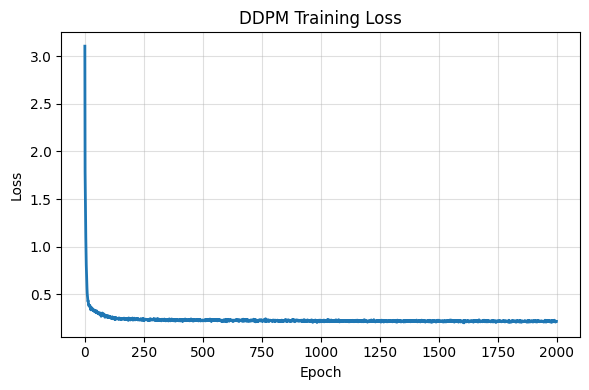

In [9]:
# ===== Cell 8: Main (Part 1) =====
if __name__ == "__main__":
    set_seed(CONFIG["seed"])

    # Build test system
    net_fn = getattr(pn, CONFIG["system"])
    net = net_fn()
    num_buses = len(net.bus)
    sn_mva = float(net.sn_mva)

    print(f"Using system: {CONFIG['system']} with {num_buses} buses, S_base={sn_mva} MVA")

    # Build Y-bus tensors (p.u.)
    G_t, B_t = build_Ybus_torch(net, device=CONFIG["device"])
    print("Y-bus built (p.u.).")

    # Ground-truth dataset via OPF (Sec. VI-A)
    dataset = make_dataset(net_fn, N=CONFIG["num_samples"], seed=CONFIG["seed"])
    assert len(dataset) > 0, "No OPF samples converged; adjust system or sampling range."

    # Basic stats
    B = num_buses
    print(f"\nDataset shape: {dataset.shape}")
    print(f"P [MW] min/max: {dataset[:, :B].min():.2f} / {dataset[:, :B].max():.2f}")
    print(f"Q [MVAr] min/max: {dataset[:, B:2*B].min():.2f} / {dataset[:, B:2*B].max():.2f}")
    print(f"V [p.u.] min/max: {dataset[:, 2*B:3*B].min():.3f} / {dataset[:, 2*B:3*B].max():.3f}")
    print(f"θ [rad] min/max: {dataset[:, 3*B:4*B].min():.3f} / {dataset[:, 3*B:4*B].max():.3f}")

    # Quick feasibility check on a few points (dP/dQ in p.u.)
    gt_tensor = dataset[:10].to(CONFIG["device"])
    gt_res = power_flow_residual(gt_tensor, G_t, B_t, sn_mva=sn_mva)
    gt_mismatch = torch.sqrt((gt_res ** 2).mean(dim=1)).detach().cpu().numpy()
    print(f"Ground-truth mismatch (p.u.) on 10 samples: mean={gt_mismatch.mean():.3e} ± {gt_mismatch.std():.1e}")

    # Train DDPM with variable decoupling
    den1, den2, normer, loss_hist = train_model(dataset, num_buses, CONFIG)

    # Plot training loss
    plt.figure(figsize=(6,4))
    plt.plot(loss_hist, lw=2)
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("DDPM Training Loss")
    plt.grid(True, alpha=0.4)
    plt.tight_layout(); plt.show()


In [10]:
# ===== Cell 9: Sampling helpers (guided/unguided) + Wasserstein =====
import torch
import numpy as np
from typing import Optional, Tuple, List

# Reuse DenoiserMLP and MinMaxNorm from Part 1
# Reuse power_flow_residual, inequality_residual, make_beta_schedule

def get_pq_bounds_from_dataset(dataset: torch.Tensor, B: int, margin: float = 0.00
                              ) -> Tuple[Tuple[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray]]:
    """
    Compute simple per-bus bounds for p and q from the real dataset.
    Adds an optional fractional 'margin' to widen the interval a bit.
    Returns (p_bounds=(pmin,pmax), q_bounds=(qmin,qmax)) as numpy arrays.
    """
    data_np = dataset.cpu().numpy()
    p = data_np[:, :B]
    q = data_np[:, B:2*B]

    pmin = p.min(axis=0); pmax = p.max(axis=0)
    qmin = q.min(axis=0); qmax = q.max(axis=0)

    if margin > 0:
        pspan = pmax - pmin; qspan = qmax - qmin
        pmin = pmin - margin * pspan
        pmax = pmax + margin * pspan
        qmin = qmin - margin * qspan
        qmax = qmax + margin * qspan

    return (pmin, pmax), (qmin, qmax)


@torch.no_grad()
def _predict_eps(den1, den2, x1_t, x2_t, t_scalar: int, device: str):
    """
    Small helper to run both denoisers at a given integer timestep t.
    """
    t_tensor = torch.tensor([t_scalar], device=device)
    eps1 = den1(x1_t, t_tensor)
    eps2 = den2(x2_t, t_tensor)
    return eps1, eps2


def _ddpm_posterior_step(x_t, x0_hat, betas, alphas, alpha_bar, t, z=None):
    """
    One reverse step using the x0-predicted posterior parameterization:
        x_{t-1} = coef1 * x0_hat + coef2 * x_t + sigma_t * z
    where:
        coef1 = sqrt(alpha_bar_{t-1}) * beta_t / (1 - alpha_bar_t)
        coef2 = sqrt(alpha_t) * (1 - alpha_bar_{t-1}) / (1 - alpha_bar_t)
        sigma_t^2 = beta_t * (1 - alpha_bar_{t-1}) / (1 - alpha_bar_t)
    """
    beta_t = betas[t]
    alpha_t = alphas[t]
    alpha_bar_prev = alpha_bar[t-1] if t > 0 else x_t.new_tensor(1.0)
    denom = (1 - alpha_bar[t]).clamp_min(1e-8)

    coef1 = torch.sqrt(alpha_bar_prev) * beta_t / denom
    coef2 = torch.sqrt(alpha_t) * (1 - alpha_bar_prev) / denom
    sigma_t = torch.sqrt(beta_t * (1 - alpha_bar_prev) / denom)

    if z is None:
        z = torch.zeros_like(x_t)

    return coef1 * x0_hat + coef2 * x_t + sigma_t * z


def load_checkpoint_for_sampling(ckpt_path: str, B: int, config: dict, device: str):
    """
    Load checkpoint and construct models + normalizer for sampling.
    """
    ckpt = torch.load(ckpt_path, map_location=device)
    assert ckpt["B"] == B, f"Checkpoint B={ckpt['B']} != current B={B}"

    den1 = DenoiserMLP(2*B, config["hidden_dim"], config["depth"]).to(device).eval()
    den2 = DenoiserMLP(2*B, config["hidden_dim"], config["depth"]).to(device).eval()
    den1.load_state_dict(ckpt["den1"])
    den2.load_state_dict(ckpt["den2"])

    normer = MinMaxNorm(ckpt["xmin"].to(device), ckpt["xmax"].to(device))
    # keep range from ckpt if present (same values as recomputed)
    if "range" in ckpt:
        normer.range = ckpt["range"].to(device)

    return den1, den2, normer


def sample_with_guidance_once(G_t: torch.Tensor,
                              B_t: torch.Tensor,
                              net,
                              sn_mva: float,
                              config: dict,
                              den1,
                              den2,
                              normer: MinMaxNorm,
                              p_bounds: Optional[Tuple[np.ndarray, np.ndarray]] = None,
                              q_bounds: Optional[Tuple[np.ndarray, np.ndarray]] = None,
                              lambda_guidance: Optional[float] = None,
                              track_residuals: bool = False):
    """
    Single sample from Alg. 5:
      1) denoise (Tweedie) -> \hat{x}_0 (normalized)
      2) guidance: \hat{x}_0' = \hat{x}_0 - λ_t ∇ (R_H + R_G)
      3) reverse diffusion posterior step
    Variable-decoupled sampling: states split between (p,θ) and (q,v).

    Returns:
      final_sample: 1 x (4B) numpy in physical units
      residual_history: list of residual norms per step (if tracked)
    """
    device = config["device"]
    T = config["diffusion_steps"]
    betas, alphas, alpha_bar = make_beta_schedule(T, config["beta_start"], config["beta_end"])
    betas = betas.to(device); alphas = alphas.to(device); alpha_bar = alpha_bar.to(device)

    lam = config["lambda_guidance"] if lambda_guidance is None else lambda_guidance

    Bdim = G_t.shape[0]
    # Start from Gaussian noise in normalized space
    x_t = torch.randn(1, 4*Bdim, device=device)

    residual_hist = [] if track_residuals else None

    # We'll maintain decoupled states for the current step
    # (store as concatenated 4B vector to keep book-keeping simpler)
    for t in reversed(range(T)):
        # Split into decoupled parts
        x1_t = torch.cat([x_t[:, :Bdim], x_t[:, 3*Bdim:4*Bdim]], dim=-1)   # (p, θ)
        x2_t = torch.cat([x_t[:, Bdim:2*Bdim], x_t[:, 2*Bdim:3*Bdim]], dim=-1)  # (q, v)

        # Predict noise for both decoupled parts
        with torch.no_grad():
            eps1, eps2 = _predict_eps(den1, den2, x1_t, x2_t, t, device)

        # Tweedie (eq. 6) to estimate clean sample \hat{x}_0 in normalized space
        sqrt_ab_t = torch.sqrt(alpha_bar[t]).clamp_min(1e-8)
        sqrt_1m_ab_t = torch.sqrt(1 - alpha_bar[t]).clamp_min(1e-8)

        x1_0 = (x1_t - sqrt_1m_ab_t * eps1) / sqrt_ab_t
        x2_0 = (x2_t - sqrt_1m_ab_t * eps2) / sqrt_ab_t

        # Recompose the 4B vector
        hat_x0_norm = torch.zeros_like(x_t)
        hat_x0_norm[:, :Bdim]          = x1_0[:, :Bdim]         # p
        hat_x0_norm[:, Bdim:2*Bdim]    = x2_0[:, :Bdim]         # q
        hat_x0_norm[:, 2*Bdim:3*Bdim]  = x2_0[:, Bdim:2*Bdim]   # v
        hat_x0_norm[:, 3*Bdim:4*Bdim]  = x1_0[:, Bdim:2*Bdim]   # θ

        # Optional: clamp normalized range to keep stability
        hat_x0_norm = hat_x0_norm.clamp(-3, 3)

        # ---- Guidance (Sec. IV): on the clean estimate, before posterior step ----
        if lam > 0 and t > 0:
            hat_x0_norm.requires_grad_(True)

            # Denormalize for physics evaluation; autograd handles the chain rule.
            x_phys = normer.denorm(hat_x0_norm)

            RH = (power_flow_residual(x_phys, G_t, B_t, sn_mva=sn_mva) ** 2).sum()
            RG = inequality_residual(x_phys, net, p_bounds=p_bounds, q_bounds=q_bounds)
            loss_phys = RH + RG

            if track_residuals:
                residual_hist.append(torch.sqrt(loss_phys).item())

            grad = torch.autograd.grad(loss_phys, hat_x0_norm, create_graph=False)[0]
            # Modulate guidance scale across time (stronger late as in your code)
            guidance_scale = lam * (1 - t / T)
            hat_x0_guided = (hat_x0_norm - guidance_scale * grad).detach().clamp(-3, 3)
        else:
            hat_x0_guided = hat_x0_norm.detach()

        # Split guided clean estimate again for posterior step
        hat_x0_g_p1 = torch.cat([hat_x0_guided[:, :Bdim], hat_x0_guided[:, 3*Bdim:4*Bdim]], dim=-1)
        hat_x0_g_p2 = torch.cat([hat_x0_guided[:, Bdim:2*Bdim], hat_x0_guided[:, 2*Bdim:3*Bdim]], dim=-1)

        # Noise for posterior sampling
        if t > 0:
            z = torch.randn_like(x_t)
            z1 = torch.cat([z[:, :Bdim], z[:, 3*Bdim:4*Bdim]], dim=-1)
            z2 = torch.cat([z[:, Bdim:2*Bdim], z[:, 2*Bdim:3*Bdim]], dim=-1)
        else:
            z1 = z2 = torch.zeros_like(x1_t)

        # Reverse posterior step for both decoupled states
        x1_tm1 = _ddpm_posterior_step(x1_t, hat_x0_g_p1, betas, alphas, alpha_bar, t, z1)
        x2_tm1 = _ddpm_posterior_step(x2_t, hat_x0_g_p2, betas, alphas, alpha_bar, t, z2)

        # Reassemble x_{t-1}
        x_t[:, :Bdim]          = x1_tm1[:, :Bdim]
        x_t[:, Bdim:2*Bdim]    = x2_tm1[:, :Bdim]
        x_t[:, 2*Bdim:3*Bdim]  = x2_tm1[:, Bdim:2*Bdim]
        x_t[:, 3*Bdim:4*Bdim]  = x1_tm1[:, Bdim:2*Bdim]

    # Final denormalization to physical units
    final_sample = normer.denorm(x_t).detach().cpu().numpy()
    return (final_sample, residual_hist) if track_residuals else (final_sample, None)


def generate_synthetic_dataset(num_samples: int,
                               guided: bool,
                               net,
                               G_t: torch.Tensor,
                               B_t: torch.Tensor,
                               sn_mva: float,
                               dataset: torch.Tensor,
                               config: dict,
                               track_first_residuals: bool = True,
                               bounds_margin: float = 0.00):
    """
    Generate many samples (guided or unguided).
    Loads models once, then reuses them.
    Returns:
      samples_np: [num_samples, 4B] array
      residual_history: list (only for the first sample if track_first_residuals and guided)
    """
    device = config["device"]
    B = G_t.shape[0]

    # Load models + normalizer from checkpoint
    den1, den2, normer = load_checkpoint_for_sampling("checkpoint.pth", B, config, device=device)

    # Optional simple bounds from dataset (helps RG enforce ranges)
    p_bounds, q_bounds = get_pq_bounds_from_dataset(dataset, B=B, margin=bounds_margin)

    lam = config["lambda_guidance"] if guided else 0.0

    samples = []
    residual_hist = None

    for i in tqdm(range(num_samples), desc=f"Sampling ({'guided' if guided else 'unguided'})"):
        track = (i == 0 and guided and track_first_residuals)
        sample_np, rh = sample_with_guidance_once(
            G_t, B_t, net, sn_mva, config,
            den1=den1, den2=den2, normer=normer,
            p_bounds=p_bounds, q_bounds=q_bounds,
            lambda_guidance=lam,
            track_residuals=track
        )
        samples.append(sample_np[0])
        if track:
            residual_hist = rh

    return np.array(samples), residual_hist


def compute_wasserstein_distance_multidim(data1: np.ndarray, data2: np.ndarray, seed: Optional[int] = None) -> float:
    """
    Multi-dimensional 1-Wasserstein distance (W1) with L2 ground cost via Hungarian algorithm (eq. 33).
    If sample sizes differ, both are subsampled to the min size.
    """
    assert data1.shape[1] == data2.shape[1], "Data dimensions must match."
    n = min(len(data1), len(data2))
    if seed is not None:
        rs = np.random.RandomState(seed)
        idx1 = rs.choice(len(data1), n, replace=False)
        idx2 = rs.choice(len(data2), n, replace=False)
        X = data1[idx1]
        Y = data2[idx2]
    else:
        X = data1[:n]
        Y = data2[:n]
    C = euclidean_distances(X, Y)
    row_ind, col_ind = linear_sum_assignment(C)
    return C[row_ind, col_ind].sum() / n


<>:102: SyntaxWarning: invalid escape sequence '\h'
<>:102: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-3178616198.py:102: SyntaxWarning: invalid escape sequence '\h'
  1) denoise (Tweedie) -> \hat{x}_0 (normalized)


Sampling (unguided): 100%|██████████| 1000/1000 [34:08<00:00,  2.05s/it]


Wasserstein (guided):   0.0564
Wasserstein (unguided): 0.0567


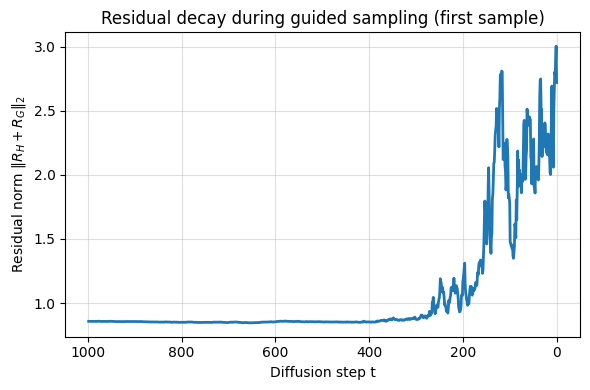

In [11]:
# ===== Cell 10: Generate guided & unguided datasets, W1, residual decay plot =====

# Ensure we have from Part 1:
#   net, G_t, B_t, sn_mva, dataset, CONFIG

num_M = CONFIG["num_synthetic_samples"]

# Guided
guided_data, residual_hist = generate_synthetic_dataset(
    num_samples=num_M,
    guided=True,
    net=net,
    G_t=G_t, B_t=B_t,
    sn_mva=sn_mva,
    dataset=dataset,
    config=CONFIG,
    track_first_residuals=True,
    bounds_margin=0.00,  # set to small (e.g., 0.05) if you want a slight slack on bounds
)

# Unguided
unguided_data, _ = generate_synthetic_dataset(
    num_samples=num_M,
    guided=False,
    net=net,
    G_t=G_t, B_t=B_t,
    sn_mva=sn_mva,
    dataset=dataset,
    config=CONFIG,
    track_first_residuals=False,
    bounds_margin=0.00,
)

ground_truth_data = dataset.cpu().numpy()
B = len(net.bus)

# Wasserstein distances (eq. 33)
w_guided = compute_wasserstein_distance_multidim(ground_truth_data, guided_data, seed=CONFIG["seed"])
w_unguided = compute_wasserstein_distance_multidim(ground_truth_data, unguided_data, seed=CONFIG["seed"])
print(f"Wasserstein (guided):   {w_guided:.4f}")
print(f"Wasserstein (unguided): {w_unguided:.4f}")

# Residual decay during guided sampling (first sample)
if residual_hist is not None:
    plt.figure(figsize=(6,4))
    plt.plot(residual_hist, lw=2)
    plt.gca().invert_xaxis()  # t goes T->0 in our loop; invert to show progress toward 0
    plt.xlabel("Diffusion step t")
    plt.ylabel(r"Residual norm $\|R_H + R_G\|_2$")
    plt.title("Residual decay during guided sampling (first sample)")
    plt.grid(True, alpha=0.4)
    plt.tight_layout()
    plt.show()


In [12]:
# ===== Cell 11: Constraint satisfaction (mismatch stats in p.u.) =====
def mismatch_stats(data_np: np.ndarray, G_t: torch.Tensor, B_t: torch.Tensor, sn_mva: float, device: str):
    X = torch.tensor(data_np, dtype=torch.float32, device=device)
    res = power_flow_residual(X, G_t, B_t, sn_mva=sn_mva)
    # RMSE per sample across all buses & both (P,Q)
    per_sample = torch.sqrt((res**2).mean(dim=1)).detach().cpu().numpy()
    return per_sample.mean(), per_sample.std()

mu_gt, sd_gt = mismatch_stats(ground_truth_data, G_t, B_t, sn_mva, CONFIG["device"])
mu_gd, sd_gd = mismatch_stats(guided_data,       G_t, B_t, sn_mva, CONFIG["device"])
mu_ug, sd_ug = mismatch_stats(unguided_data,     G_t, B_t, sn_mva, CONFIG["device"])

print(f"Mismatch ||H|| (p.u.) — Ground truth: mean={mu_gt:.3e} ± {sd_gt:.1e}")
print(f"Mismatch ||H|| (p.u.) — Guided:       mean={mu_gd:.3e} ± {sd_gd:.1e}")
print(f"Mismatch ||H|| (p.u.) — Unguided:     mean={mu_ug:.3e} ± {sd_ug:.1e}")


Mismatch ||H|| (p.u.) — Ground truth: mean=1.045e-01 ± 1.3e-03
Mismatch ||H|| (p.u.) — Guided:       mean=1.045e-01 ± 1.0e-03
Mismatch ||H|| (p.u.) — Unguided:     mean=1.046e-01 ± 1.0e-03


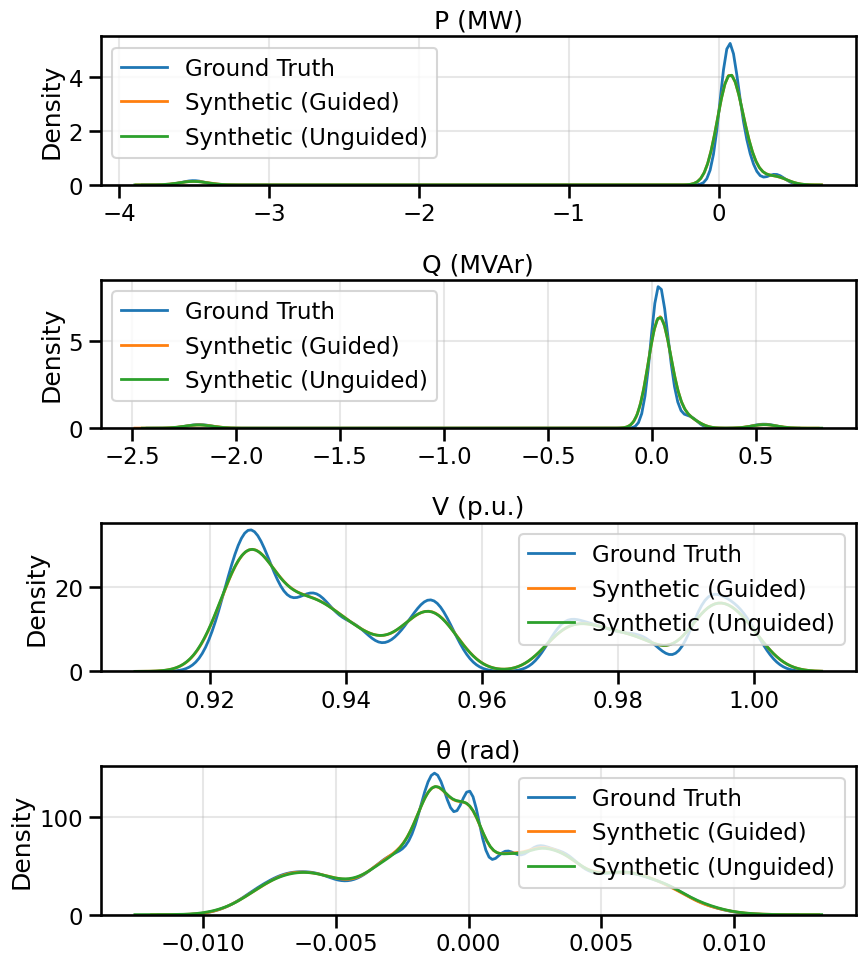

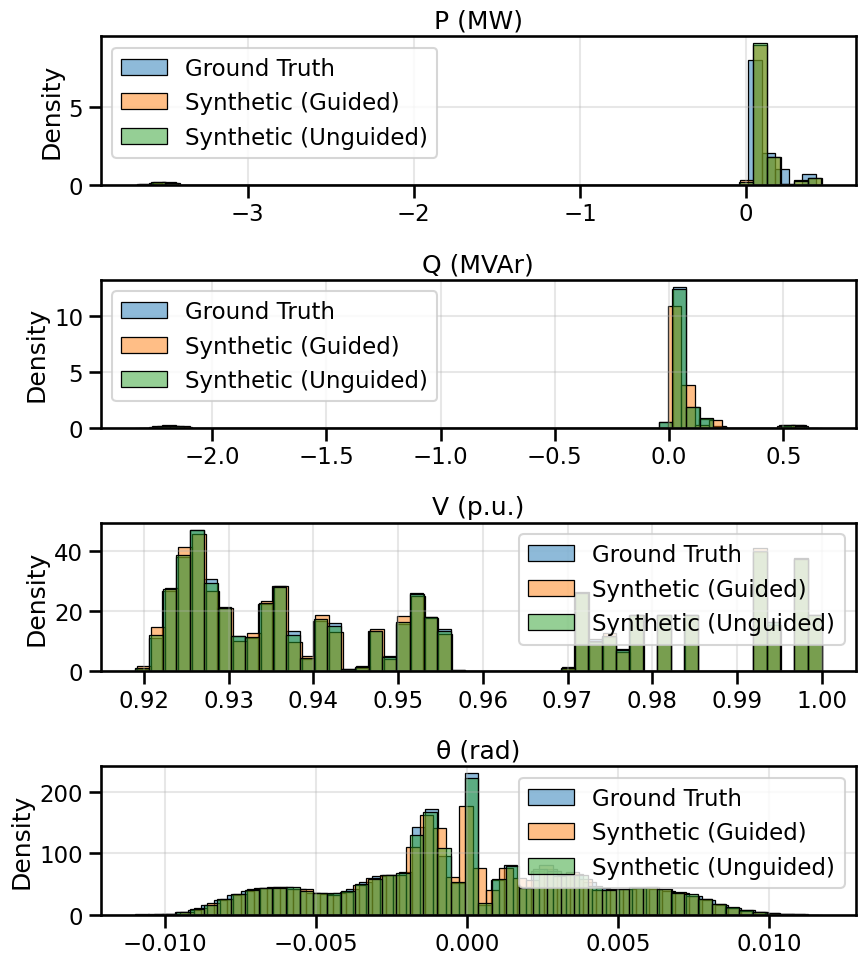

In [13]:
# ===== Cell 12: Global distribution plots (flattened KDE + histogram) =====
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")

var_names = ['P (MW)', 'Q (MVAr)', 'V (p.u.)', 'θ (rad)']
B = len(net.bus)

# KDE comparison (flattened across buses)
plt.figure(figsize=(9, 10))
for i in range(4):
    start = i * B
    end = (i + 1) * B
    plt.subplot(4, 1, i+1)
    sns.kdeplot(ground_truth_data[:, start:end].ravel(), label="Ground Truth", lw=2)
    sns.kdeplot(guided_data[:, start:end].ravel(),       label="Synthetic (Guided)", lw=2)
    sns.kdeplot(unguided_data[:, start:end].ravel(),     label="Synthetic (Unguided)", lw=2)
    plt.title(var_names[i])
    plt.legend()
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Histogram comparison (flattened across buses)
plt.figure(figsize=(9, 10))
for i in range(4):
    start = i * B
    end = (i + 1) * B
    plt.subplot(4, 1, i+1)
    sns.histplot(ground_truth_data[:, start:end].ravel(), label="Ground Truth", bins=50, stat="density", alpha=0.5)
    sns.histplot(guided_data[:, start:end].ravel(),       label="Synthetic (Guided)", bins=50, stat="density", alpha=0.5)
    sns.histplot(unguided_data[:, start:end].ravel(),     label="Synthetic (Unguided)", bins=50, stat="density", alpha=0.5)
    plt.title(var_names[i])
    plt.legend()
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


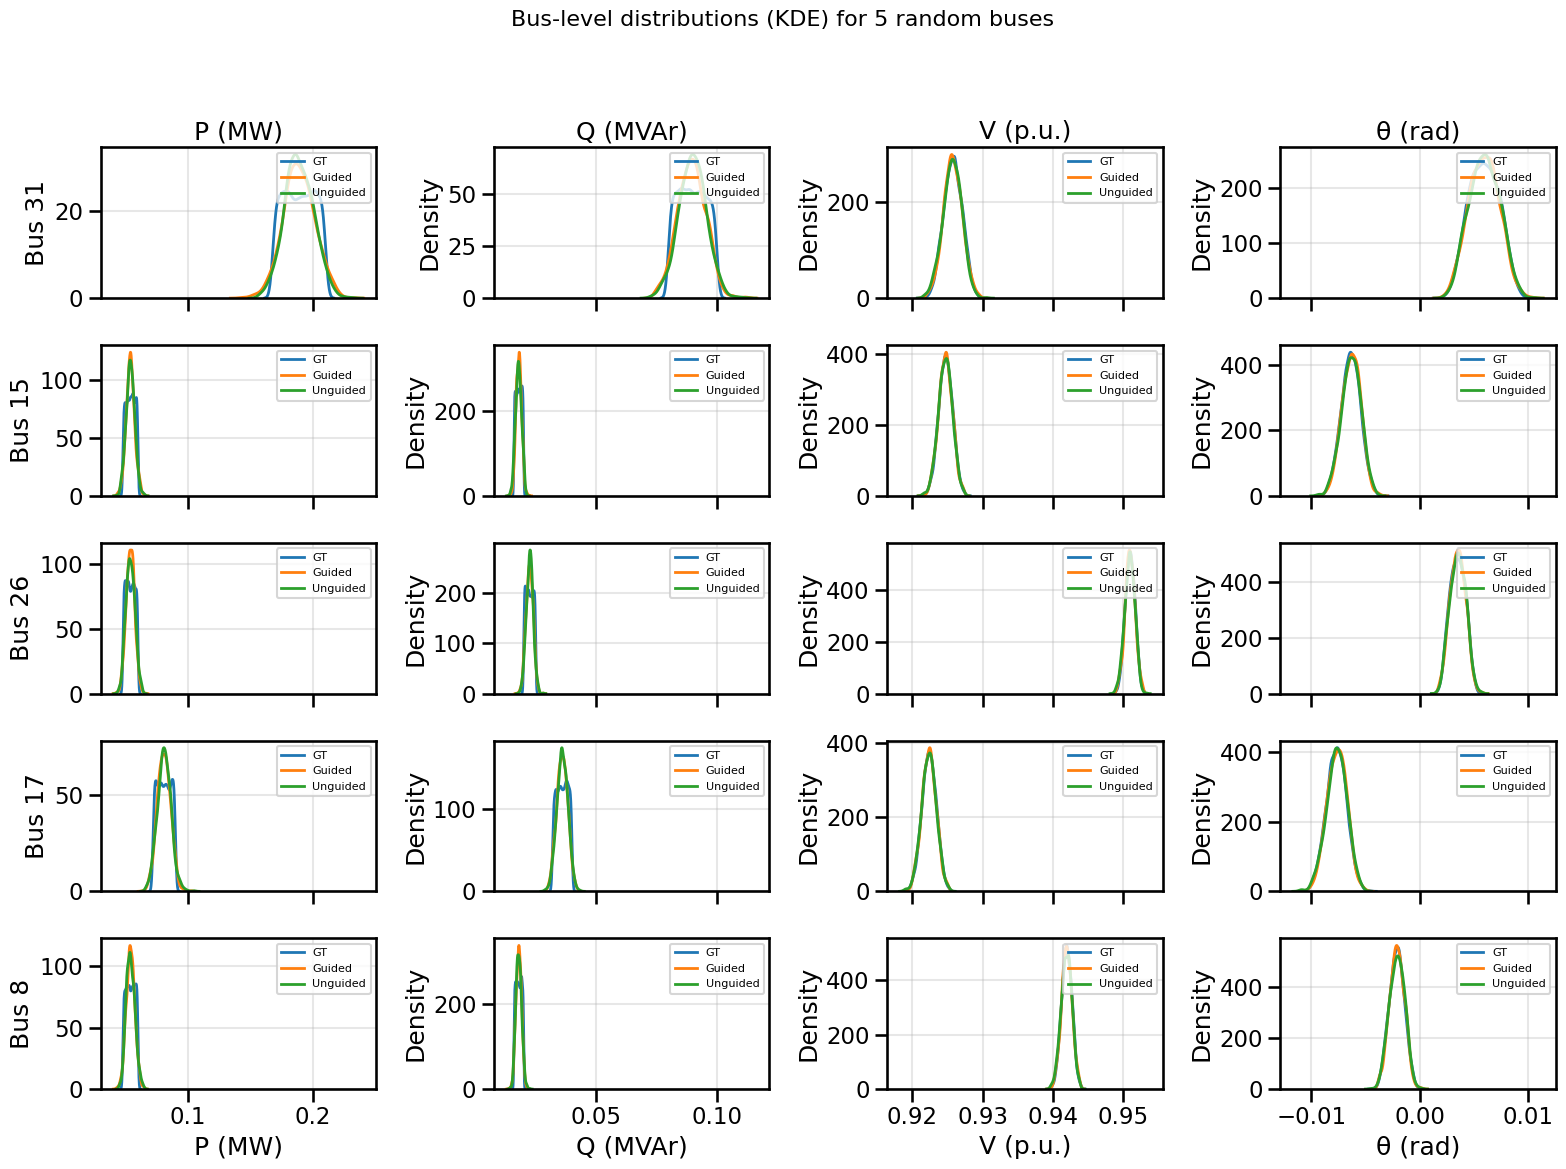

In [14]:
# ===== Cell 13: Bus-level distributions for 5 random buses (KDE) =====
np.random.seed(CONFIG["seed"])
selected_buses = np.random.choice(B, 5, replace=False)

fig, axs = plt.subplots(5, 4, figsize=(16, 12), sharex='col')
for row, bidx in enumerate(selected_buses):
    for col, (label, offset) in enumerate(zip(var_names, [0, B, 2*B, 3*B])):
        gi = ground_truth_data[:, offset + bidx]
        gd = guided_data[:,        offset + bidx]
        ug = unguided_data[:,      offset + bidx]
        ax = axs[row, col]
        sns.kdeplot(gi, label="GT", ax=ax, lw=2)
        sns.kdeplot(gd, label="Guided", ax=ax, lw=2)
        sns.kdeplot(ug, label="Unguided", ax=ax, lw=2)
        if row == 0:
            ax.set_title(label)
        if col == 0:
            ax.set_ylabel(f"Bus {bidx}")
        ax.grid(True, alpha=0.3)
        if row == len(selected_buses)-1:
            ax.set_xlabel(label)
        ax.legend(fontsize=8, loc='upper right')
plt.suptitle("Bus-level distributions (KDE) for 5 random buses", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


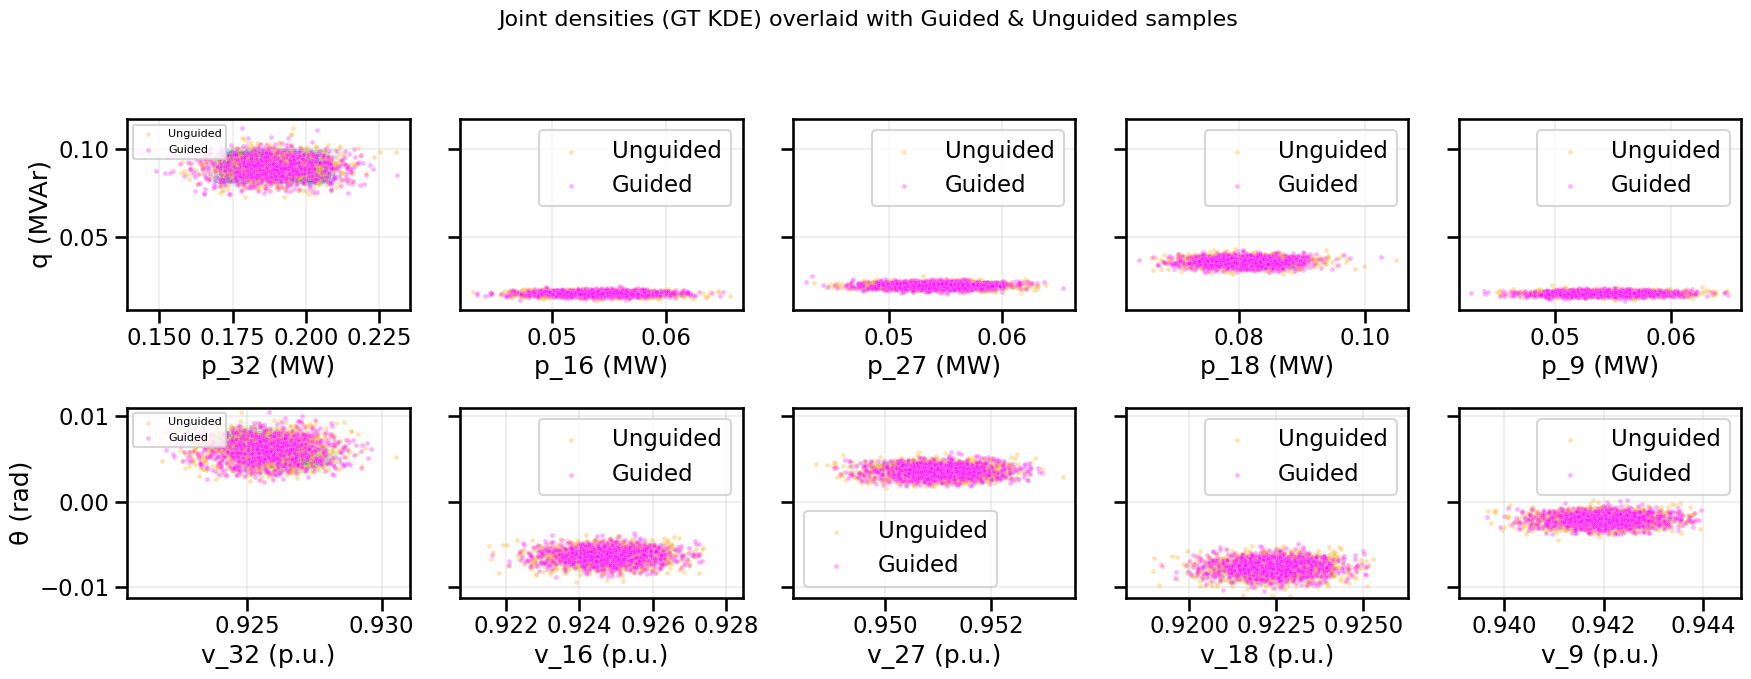

In [15]:
# ===== Cell 14: Joint density (q vs p) and (θ vs v) for 5 random buses =====
np.random.seed(CONFIG["seed"])
sel = np.random.choice(B, 5, replace=False)
base_kv = net.bus.vn_kv.values  # to plot v in kV if you wish

fig, axs = plt.subplots(2, 5, figsize=(18, 7), sharey='row')

for col, bus in enumerate(sel):
    # Top row: q vs p
    ax = axs[0, col]
    sns.kdeplot(x=ground_truth_data[:, bus], y=ground_truth_data[:, B + bus],
                fill=True, cmap="Blues", alpha=0.5, ax=ax, thresh=0.05)
    sns.scatterplot(x=unguided_data[:, bus], y=unguided_data[:, B + bus],
                    color="orange", alpha=0.3, label="Unguided", ax=ax, s=12)
    sns.scatterplot(x=guided_data[:, bus], y=guided_data[:, B + bus],
                    color="magenta", alpha=0.3, label="Guided", ax=ax, s=12)
    ax.set_xlabel(f"p_{bus+1} (MW)")
    if col == 0:
        ax.set_ylabel("q (MVAr)")
    if col == 0:
        ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.2)

    # Bottom row: θ vs v (optionally in kV)
    ax = axs[1, col]
    v_gt = ground_truth_data[:, 2*B + bus]  # p.u.
    theta_gt = ground_truth_data[:, 3*B + bus]
    v_ug = unguided_data[:, 2*B + bus]
    th_ug = unguided_data[:, 3*B + bus]
    v_gd = guided_data[:, 2*B + bus]
    th_gd = guided_data[:, 3*B + bus]

    sns.kdeplot(x=v_gt, y=theta_gt,
                fill=True, cmap="Greens", alpha=0.5, ax=ax, thresh=0.05)
    sns.scatterplot(x=v_ug, y=th_ug,
                    color="orange", alpha=0.3, label="Unguided", ax=ax, s=12)
    sns.scatterplot(x=v_gd, y=th_gd,
                    color="magenta", alpha=0.3, label="Guided", ax=ax, s=12)
    ax.set_xlabel(f"v_{bus+1} (p.u.)")
    if col == 0:
        ax.set_ylabel("θ (rad)")
    if col == 0:
        ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.2)

plt.suptitle("Joint densities (GT KDE) overlaid with Guided & Unguided samples", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


/tmp/ipython-input-2825118199.py:23: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


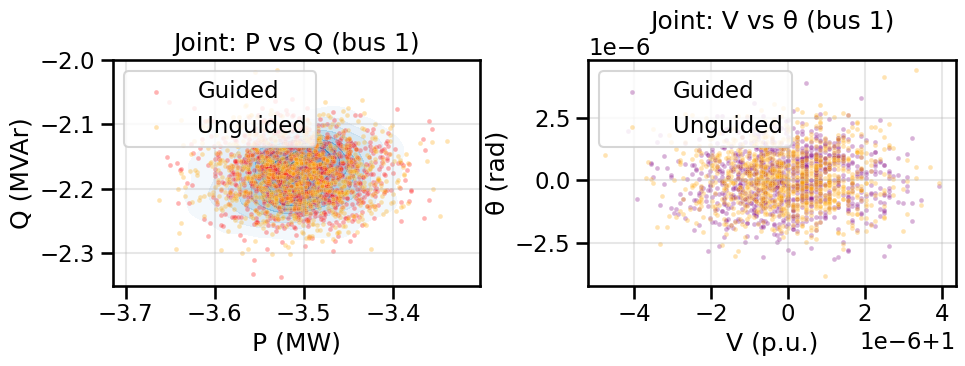

In [16]:
# ===== Cell 15: Simple joint plots for bus 1 (index 0) =====
bus0 = 0

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.kdeplot(
    x=ground_truth_data[:, bus0], y=ground_truth_data[:, B + bus0],
    fill=True, cmap="Blues", alpha=0.5, label="GT", thresh=0.05
)
sns.scatterplot(
    x=guided_data[:, bus0], y=guided_data[:, B + bus0],
    color="red", alpha=0.3, label="Guided", s=12
)
sns.scatterplot(
    x=unguided_data[:, bus0], y=unguided_data[:, B + bus0],
    color="orange", alpha=0.3, label="Unguided", s=12
)
plt.title("Joint: P vs Q (bus 1)")
plt.xlabel("P (MW)"); plt.ylabel("Q (MVAr)"); plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
sns.kdeplot(
    x=ground_truth_data[:, 2*B + bus0], y=ground_truth_data[:, 3*B + bus0],
    fill=True, cmap="Greens", alpha=0.5, label="GT", thresh=0.05
)
sns.scatterplot(
    x=guided_data[:, 2*B + bus0], y=guided_data[:, 3*B + bus0],
    color="purple", alpha=0.3, label="Guided", s=12
)
sns.scatterplot(
    x=unguided_data[:, 2*B + bus0], y=unguided_data[:, 3*B + bus0],
    color="orange", alpha=0.3, label="Unguided", s=12
)
plt.title("Joint: V vs θ (bus 1)")
plt.xlabel("V (p.u.)"); plt.ylabel("θ (rad)"); plt.legend(); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [17]:
# ===== Cell 16: Downstream ML task: mapping (p,q) -> (v,θ) =====
import sklearn.model_selection as skms
import sklearn.neural_network as sknn
from sklearn.metrics import mean_squared_error

X_gt = ground_truth_data[:, :2*B]
y_gt = ground_truth_data[:, 2*B:4*B]

X_gd = guided_data[:, :2*B]
y_gd = guided_data[:, 2*B:4*B]

# Train-test on GT; train two regressors: one on GT, one on Guided
X_train_gt, X_test_gt, y_train_gt, y_test_gt = skms.train_test_split(X_gt, y_gt, test_size=0.3, random_state=CONFIG['seed'])
X_train_gd, X_test_gd, y_train_gd, y_test_gd = skms.train_test_split(X_gd, y_gd, test_size=0.3, random_state=CONFIG['seed'])

def train_mlp(X, y, seed=42):
    mlp = sknn.MLPRegressor(
        hidden_layer_sizes=(128, 128),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=seed
    )
    mlp.fit(X, y)
    return mlp

print("Training MLP on ground-truth...")
mlp_gt = train_mlp(X_train_gt, y_train_gt, seed=CONFIG['seed'])

print("Training MLP on guided synthetic...")
mlp_gd = train_mlp(X_train_gd, y_train_gd, seed=CONFIG['seed'])

# Evaluate both on the same GT test set (to compare utility)
y_pred_gt = mlp_gt.predict(X_test_gt)
y_pred_gd = mlp_gd.predict(X_test_gt)

mse_gt = mean_squared_error(y_test_gt, y_pred_gt)
mse_gd = mean_squared_error(y_test_gt, y_pred_gd)

print(f"MSE (GT-trained, test on GT):        {mse_gt:.6f}")
print(f"MSE (Guided-trained, test on GT):    {mse_gd:.6f}")


Training MLP on ground-truth...
Training MLP on guided synthetic...
MSE (GT-trained, test on GT):        0.000053
MSE (Guided-trained, test on GT):    0.000072


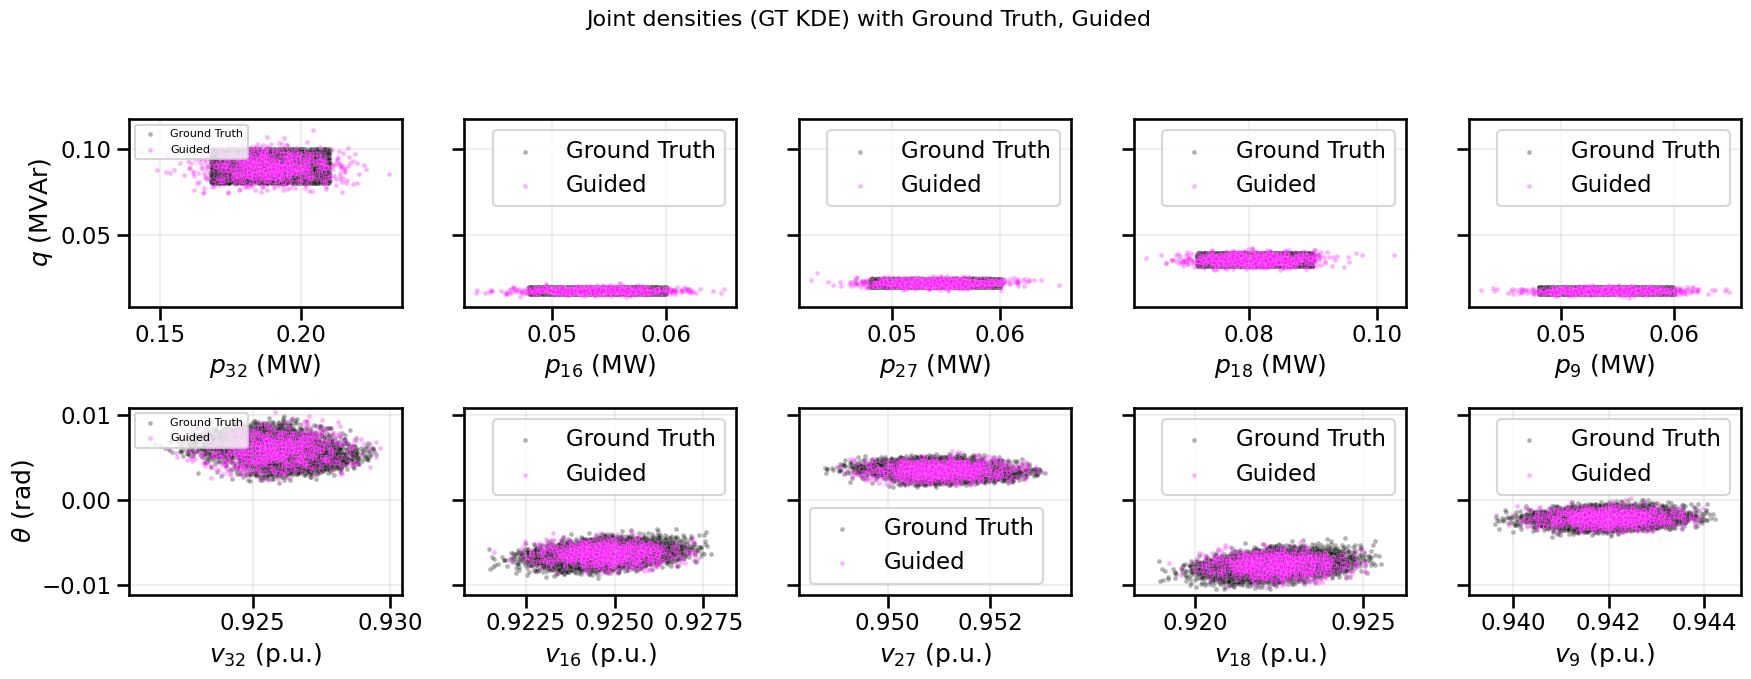

In [20]:
np.random.seed(CONFIG["seed"])
sel = np.random.choice(B, 5, replace=False)
base_kv = net.bus.vn_kv.values  # to plot v in kV if you wish

fig, axs = plt.subplots(2, 5, figsize=(18, 7), sharey='row')

for col, bus in enumerate(sel):
    # --------- TOP ROW: q vs p ---------
    ax = axs[0, col]
    # KDE background (ground truth density)
    sns.kdeplot(
        x=ground_truth_data[:, bus],
        y=ground_truth_data[:, B + bus],
        fill=True, cmap="Blues", alpha=0.4, ax=ax, thresh=0.05
    )
    # Add explicit scatter points for GT
    sns.scatterplot(
        x=ground_truth_data[:, bus],
        y=ground_truth_data[:, B + bus],
        color="black", alpha=0.3, label="Ground Truth", ax=ax, s=12
    )
    # # Unguided
    # sns.scatterplot(
    #     x=unguided_data[:, bus],
    #     y=unguided_data[:, B + bus],
    #     color="orange", alpha=0.3, label="Unguided", ax=ax, s=12
    # )
    # Guided
    sns.scatterplot(
        x=guided_data[:, bus],
        y=guided_data[:, B + bus],
        color="magenta", alpha=0.3, label="Guided", ax=ax, s=12
    )
    ax.set_xlabel(f"$p_{{{bus+1}}}$ (MW)")
    if col == 0:
        ax.set_ylabel("$q$ (MVAr)")
    if col == 0:
        ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.2)

    # --------- BOTTOM ROW: θ vs v ---------
    ax = axs[1, col]
    v_gt = ground_truth_data[:, 2*B + bus]  # p.u.
    theta_gt = ground_truth_data[:, 3*B + bus]
    # v_ug = unguided_data[:, 2*B + bus]
    # th_ug = unguided_data[:, 3*B + bus]
    v_gd = guided_data[:, 2*B + bus]
    th_gd = guided_data[:, 3*B + bus]

    # KDE for GT
    sns.kdeplot(
        x=v_gt, y=theta_gt,
        fill=True, cmap="Greens", alpha=0.4, ax=ax, thresh=0.05
    )
    # Ground truth scatter
    sns.scatterplot(
        x=v_gt, y=theta_gt,
        color="black", alpha=0.3, label="Ground Truth", ax=ax, s=12
    )
    # # Unguided
    # sns.scatterplot(
    #     x=v_ug, y=th_ug,
    #     color="orange", alpha=0.3, label="Unguided", ax=ax, s=12
    # )
    # Guided
    sns.scatterplot(
        x=v_gd, y=th_gd,
        color="magenta", alpha=0.3, label="Guided", ax=ax, s=12
    )
    ax.set_xlabel(f"$v_{{{bus+1}}}$ (p.u.)")
    if col == 0:
        ax.set_ylabel(r"$\theta$ (rad)")
    if col == 0:
        ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.2)

plt.suptitle("Joint densities (GT KDE) with Ground Truth, Guided", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()